In [2877]:
import os

import numpy as np
import numpy.linalg as la
from numpy import fft

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import AsinhStretch
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData

from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars

from scipy.ndimage import shift

stretch = AsinhStretch()

plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'none'

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [1918]:
def norm(i): 
    return np.sqrt(i.real**2 + i.imag**2)

def get_power_spectrum(fft_result):
    # Step 2: Shift the zero-frequency component to the center
    fft_shifted = np.fft.fftshift(fft_result)

    # Step 3: Compute the power spectrum (magnitude squared of the FFT result)
    power_spectrum = np.abs(fft_shifted)**2
    return power_spectrum

def get_pixel_center_coordinate(fits_path):
    with fits.open(fits_path) as hdul:
        wcs = WCS(hdul['SCI'].header)
        ny, nx = hdul['SCI'].data.shape
        center_x = (nx - 1) / 2
        center_y = (ny - 1) / 2
        sky_coord = wcs.pixel_to_world(center_x, center_y)
        return center_x, center_y, sky_coord

Prepare data

In [57]:
IMG_DIR = '/quasar/data/GO1764/NIRCam/redux_v01/'

img_paths = []

# Load F250M data
for filename in os.listdir(IMG_DIR): 
    if 'jw01764001001_02101' in filename and 'nrcblong' in filename:
        img_paths.append(os.path.join(IMG_DIR, filename))
img_paths.sort()

img_paths

['/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00006_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00007_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00008_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00009_nrcblong_cal_bsub_aligned.fits']

In [58]:
agn_coord = SkyCoord("J100758.26+211529.2", unit=(u.hourangle, u.deg), frame='icrs')

agn_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (151.99275, 21.25811111)>

Image Cutout

In [59]:
def create_cutout_fits(fits_path, cutout_path, coord, radius):
    '''
    Parameters: 
        fits_path:      string
        output_path:    string
        coord:          SkyCoord
        radius:         float (in arcsec)
    '''
    with fits.open(fits_path) as hdul:
        # read file
        header = hdul['SCI'].header
        # wcs.sip = None

        wcs = WCS(header)
        data = hdul['SCI'].data
        pixel_scale = wcs.proj_plane_pixel_scales()[0].value # degrees per pixel
        radius_pix = int(radius/3600/pixel_scale)
        size = (radius_pix*2, radius_pix*2)

        # Create the cutout
        cutout = Cutout2D(data, coord, size, wcs=wcs)
        hdul['SCI'].header.update(cutout.wcs.to_header())

        # Create new FITS HDUs
        new_hdul = fits.HDUList([fits.PrimaryHDU(header=hdul[0].header)])
        for hdu_name in ['SCI', 'ERR', 'DQ', 'AREA', 'VAR_POISSON', 'VAR_RNOISE', 'VAR_FLAT']:
            if hdu_name in hdul:
                hdu_data = Cutout2D(hdul[hdu_name].data, coord, size, wcs=wcs)
                new_hdu = fits.ImageHDU(data=hdu_data.data, header=hdul[hdu_name].header, name=hdu_name)
                new_hdu.header.update(hdu_data.wcs.to_header())
                new_hdul.append(new_hdu)

        # Write the new cutout to a FITS file
        new_hdul.writeto(cutout_path, overwrite=False)
        print(f"Cutout saved to {cutout_path}")

In [2005]:
radius = 2 # arcsec
cutout_dir = '/quasar/yichenliu/cutout'
cutout_paths = []
for fits_path in img_paths: 
    print(f' processing {fits_path}')
    directory = os.path.dirname(fits_path)
    filename = os.path.basename(fits_path)
    cutout_path = os.path.join(cutout_dir, filename[:-5]+'_cutout.fits')
    try: 
        create_cutout_fits(fits_path, cutout_path, agn_coord, radius)
    except OSError as E: 
        print(f'  ERROR: {E}')
    cutout_paths.append(cutout_path)
    # break

 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned.fits
Cutout saved to /quasar/yichenliu/cutout/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned_cutout.fits
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned.fits


Set DATE-AVG to '2023-05-10T01:57:32.636' from MJD-AVG.
Set DATE-END to '2023-05-10T02:01:07.371' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:05:57.275' from MJD-AVG.
Set DATE-END to '2023-05-10T02:09:32.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.934391 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540070416.745 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:14:32.667' from MJD-AVG.
Set DATE-END to '2023-05-10T02:18:07.402' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.938060 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540122949.033 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Cutout saved to /quasar/yichenliu/cutout/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned_cutout.fits
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned.fits
Cutout saved to /quasar/yichenliu/cutout/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned_cutout.fits
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned.fits
Cutout saved to /quasar/yichenliu/cutout/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned_cutout.fits
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned.fits


Set DATE-AVG to '2023-05-10T02:22:57.306' from MJD-AVG.
Set DATE-END to '2023-05-10T02:26:32.041' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.941320 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540169631.670 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:31:32.634' from MJD-AVG.
Set DATE-END to '2023-05-10T02:35:07.369' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.944987 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540222135.322 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:39:57.273' from MJD-AVG.
Set DATE-END to '2023-05-10T02:43:32.008' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.948247 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540268792.514 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:48:32.665' from MJD-AVG.
Set DATE-END to '2023-05-10T02:52:07.400' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.951913 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540321267.547 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Cutout saved to /quasar/yichenliu/cutout/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned_cutout.fits
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00006_nrcblong_cal_bsub_aligned.fits
Cutout saved to /quasar/yichenliu/cutout/jw01764001001_02101_00006_nrcblong_cal_bsub_aligned_cutout.fits
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00007_nrcblong_cal_bsub_aligned.fits
Cutout saved to /quasar/yichenliu/cutout/jw01764001001_02101_00007_nrcblong_cal_bsub_aligned_cutout.fits
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00008_nrcblong_cal_bsub_aligned.fits


Set DATE-AVG to '2023-05-10T02:56:57.304' from MJD-AVG.
Set DATE-END to '2023-05-10T03:00:32.039' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.955171 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540367899.307 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T03:05:32.632' from MJD-AVG.
Set DATE-END to '2023-05-10T03:09:07.367' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.958836 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540420345.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Cutout saved to /quasar/yichenliu/cutout/jw01764001001_02101_00008_nrcblong_cal_bsub_aligned_cutout.fits
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00009_nrcblong_cal_bsub_aligned.fits
Cutout saved to /quasar/yichenliu/cutout/jw01764001001_02101_00009_nrcblong_cal_bsub_aligned_cutout.fits


display cutouts

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
(array(30.243), arra

Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.934391 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540070416.745 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.938060 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540122949.033 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.941320 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540169631.670 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.944987 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540222135.322 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.948247 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540268792.514 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.951913 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540321267.547 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.955171 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540367899.307 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
(array(30.878), arra

Set OBSGEO-B to   -21.958836 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540420345.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


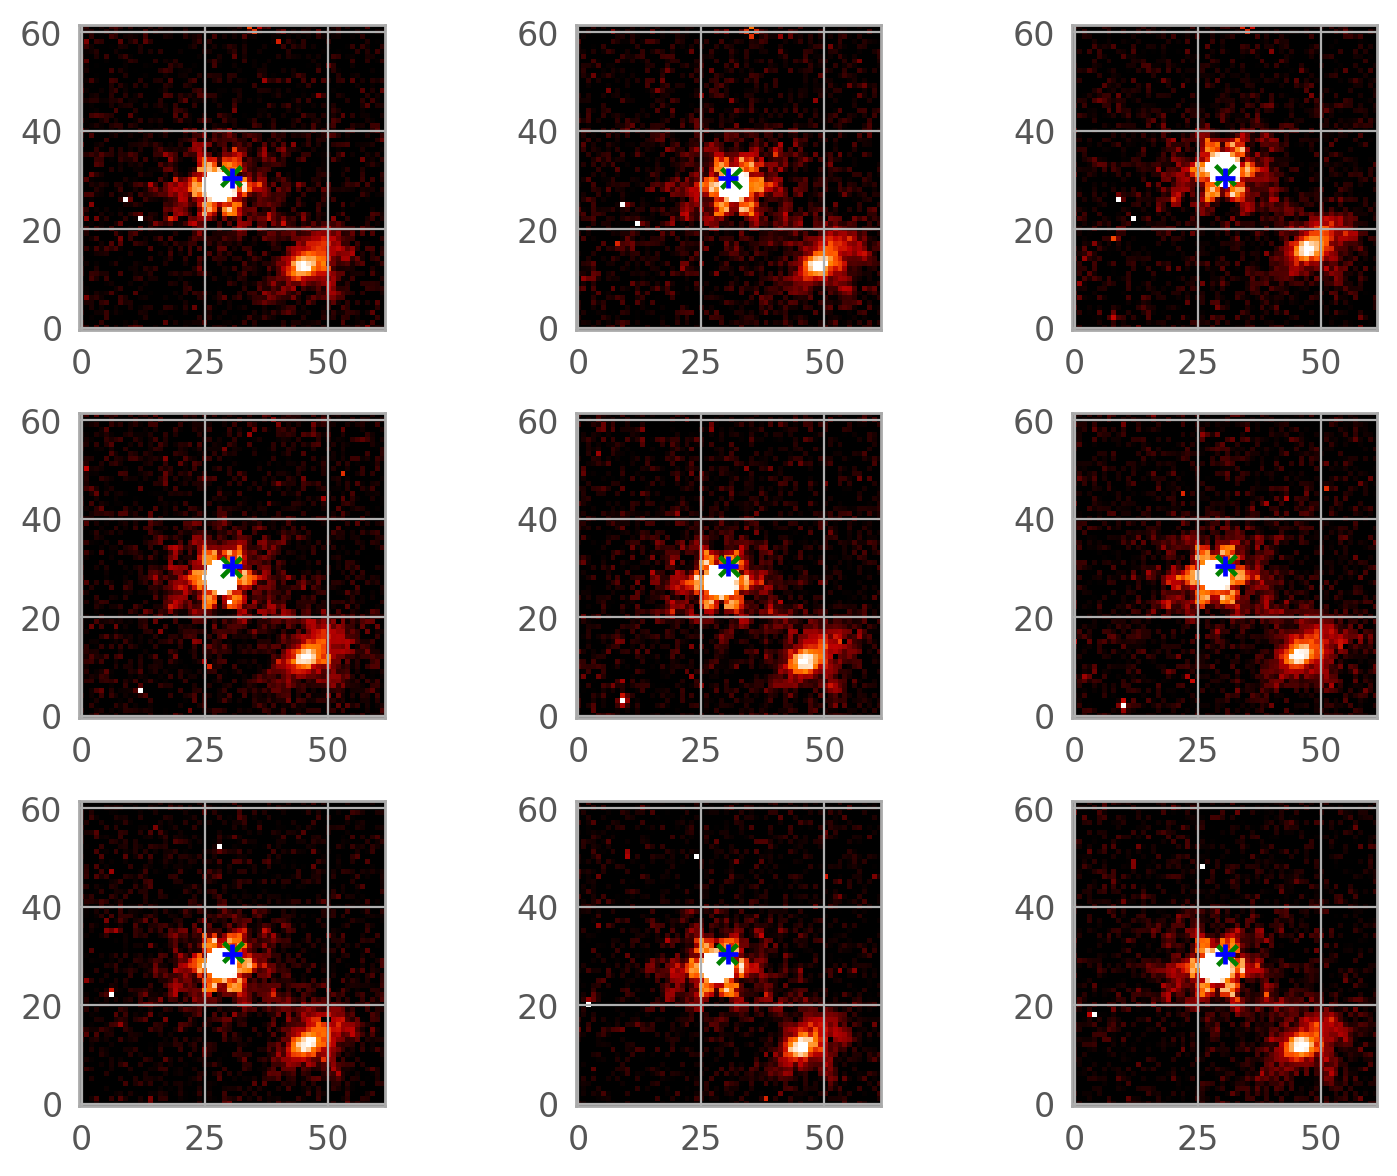

In [2006]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat

agn_pixels = []

for i in range(9): 
    with fits.open(cutout_paths[i]) as hdul: 
        data = hdul[1].data
        wcs = WCS(hdul[1].header)
        agn_pixel = wcs.world_to_pixel(agn_coord)
        print(agn_pixel)
        axs[i].imshow(stretch(data))
        axs[i].scatter(agn_pixel[0], agn_pixel[1], marker='x', c='g', s=50)
        x, y, _ = get_pixel_center_coordinate(cutout_paths[i])
        axs[i].scatter(x, y, marker='+', c='b', s=50)
        agn_pixels.append(agn_pixel)
        # axs[i].grid(False)

agn_pixels = np.array(agn_pixels)

plt.tight_layout()

## perform addition

Manually find its center

In [3319]:
cx, cy, _ = get_pixel_center_coordinate(cutout_paths[0])

cx, cy

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(30.5, 30.5)

In [3320]:
centroids = []

for i in range(9): 
    with fits.open(cutout_paths[i]) as hdul: 
        data = hdul[1].data
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=3.0, threshold=20.0*std)
    sources = daofind(data - median)
    # print(len(sources))
    distances_to_center = (sources['xcentroid'] - cx)**2 + (sources['ycentroid'] - cy)**2
    source = sources[distances_to_center==np.min(distances_to_center)][0]
    x = source['xcentroid']
    y = source['ycentroid']
    centroids.append([x, y])
centroids = np.array(centroids)

centroids = centroids[:4]

centroids

array([[28.096, 28.544],
       [31.689, 28.848],
       [30.395, 32.036],
       [28.441, 27.918]])

IndexError: index 4 is out of bounds for axis 0 with size 4

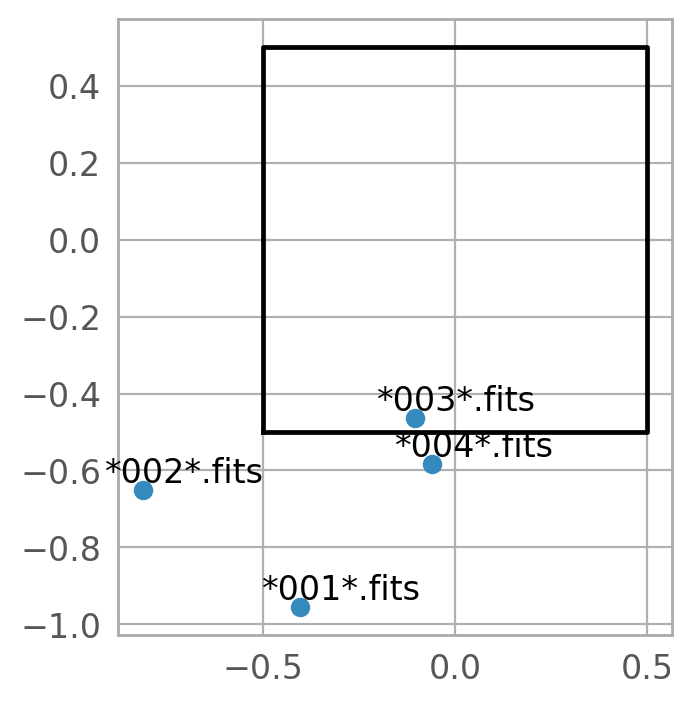

In [3321]:
centroids_floor = np.around(centroids).astype(np.int64)
centroids_dec = centroids - centroids_floor

centroids_dec -= 0.5

plt.figure(figsize=[4, 4])
plt.scatter(*centroids_dec.T)
plt.plot([-0.5, 0.5, 0.5, -0.5, -0.5], [-0.5, -0.5, 0.5, 0.5, -0.5], c='k')
plt.gca().set_aspect('equal')
for i in range(9): 
    plt.text(centroids_dec[i, 0]-0.1, centroids_dec[i, 1]+0.02, '*'+cutout_paths[i][47:50]+'*.fits')
# plt.plot([0, 1], [1/3, 1/3], c='k')
# plt.plot([0, 1], [2/3, 2/3], c='k')
# plt.plot([1/3, 1/3], [0, 1], c='k')
# plt.plot([2/3, 2/3], [0, 1], c='k')

# manual_shift = np.array([[0, 1], [1, 2], [1, 0], [0, 2], [0, 0], [2, 1], [2, 0], [1, 1], [2, 2]])

In [3322]:

# factor = 3
# nx0, ny0 = data.shape
# nx = nx0*factor
# ny = ny0*factor
# X, Y = np.meshgrid(np.arange(nx)/nx, np.arange(ny)/ny)

# centroids_large = centroids*factor - nx//2
# # centroids_large = (centroids*factor).astype(np.int64) - nx//2
# # centroids_large = np.floor(centroids).astype(np.int64)*factor + manual_shift - nx//2
# # centroids_large = (centroids).astype(np.int64)*factor + np.array(np.meshgrid([0, 1, 2], [0, 1, 2])).reshape(2, 9).T


# plt.figure(figsize=[4, 4])
# plt.scatter(*centroids_large.T)
# for i in range(9): 
#     plt.text(centroids_large[i, 0]+0.01, centroids_large[i, 1]+0.01, cutout_paths[i][47:50])
# # plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], c='k')
# # plt.plot([0, 1], [1/3, 1/3], c='k')
# # plt.plot([0, 1], [2/3, 2/3], c='k')
# # plt.plot([1/3, 1/3], [0, 1], c='k')
# # plt.plot([2/3, 2/3], [0, 1], c='k')

# centroids_large

In [2077]:
# fig, axs = plt.subplots(3, 3)
# axs = axs.flat

# for i in range(9): 
#     with fits.open(cutout_paths[i]) as hdul: 
#         data = hdul[1].data
#         axs[i].imshow(data)
#         axs[i].scatter(*centroids[i], marker='x')
#         axs[i].set_xlim(25, 35)
#         axs[i].set_ylim(25, 35)
#         axs[i].grid(False)

# plt.tight_layout()

read cutouts

In [3325]:
factor = 2

orig_atlas = []
for cutout_path in cutout_paths: 
    with fits.open(cutout_path) as hdul: 
        data = hdul[1].data
        orig_atlas.append(data)

# orig_atlas = orig_atlas[:4]

In [2816]:
# TEST BLOCK

# orig_atlas = test_atlas[:-1]
# centroids_large = -np.array([[0, 0],
#                             [1, 0],
#                             [2, 0],
#                             [0, 1],
#                             [1, 1],
#                             [2, 1],
#                             [0, 2],
#                             [1, 2],
#                             [2, 2]])[:-1]

factor = 2

# orig_atlas = test_atlas_2x
# # centroids_large = np.array([[0, 0],
# #                             [1, 0],
# #                             [0, 1],
# #                             [1, 1]])

# centroids_floor = np.array([[14]*2]*4)

# centroids_dec = -np.array([[0, 0],
#                           [0.5, 0],
#                           [0, 0.5],
#                           [0.5, 0.5]])

centroids_floor = np.array([[9]*2]*4)
orig_atlas = test_atlas
centroids_dec = np.array([[0, 0], 
                     [-1/3, 0],
                     [0, -1/3],
                     [-1/3, -1/3]])


Pad the images to align the centers

In [2817]:
aligned_atlas = []
centerx_max = np.max(centroids_floor[:, 0])
centerx_min = np.min(centroids_floor[:, 0])
centery_max = np.max(centroids_floor[:, 1])
centery_min = np.min(centroids_floor[:, 1])
pad = np.max([centerx_max-centerx_min, centery_max-centery_min]) 
nx, ny = orig_atlas[0].shape
nx_aligned = nx + pad
ny_aligned = ny + pad
print(nx, ny, nx_aligned, ny_aligned)

for i in range(9):
    aligned_data = np.zeros((nx_aligned, ny_aligned))
    dx = nx_aligned//2 - centroids_floor[i, 1] - 1
    dy = nx_aligned//2 - centroids_floor[i, 0] - 1
    print(dx, dx+nx, dy, dy+ny, nx//2, ny//2, centroids_floor[i, 0], centroids_floor[i, 1])
    aligned_data[dx:dx+nx, dy:dy+ny] = orig_atlas[i]
    aligned_atlas.append(aligned_data)

20 20 20 20
0 20 0 20 10 10 9 9
0 20 0 20 10 10 9 9
0 20 0 20 10 10 9 9
0 20 0 20 10 10 9 9


IndexError: index 4 is out of bounds for axis 0 with size 4

IndexError: list index out of range

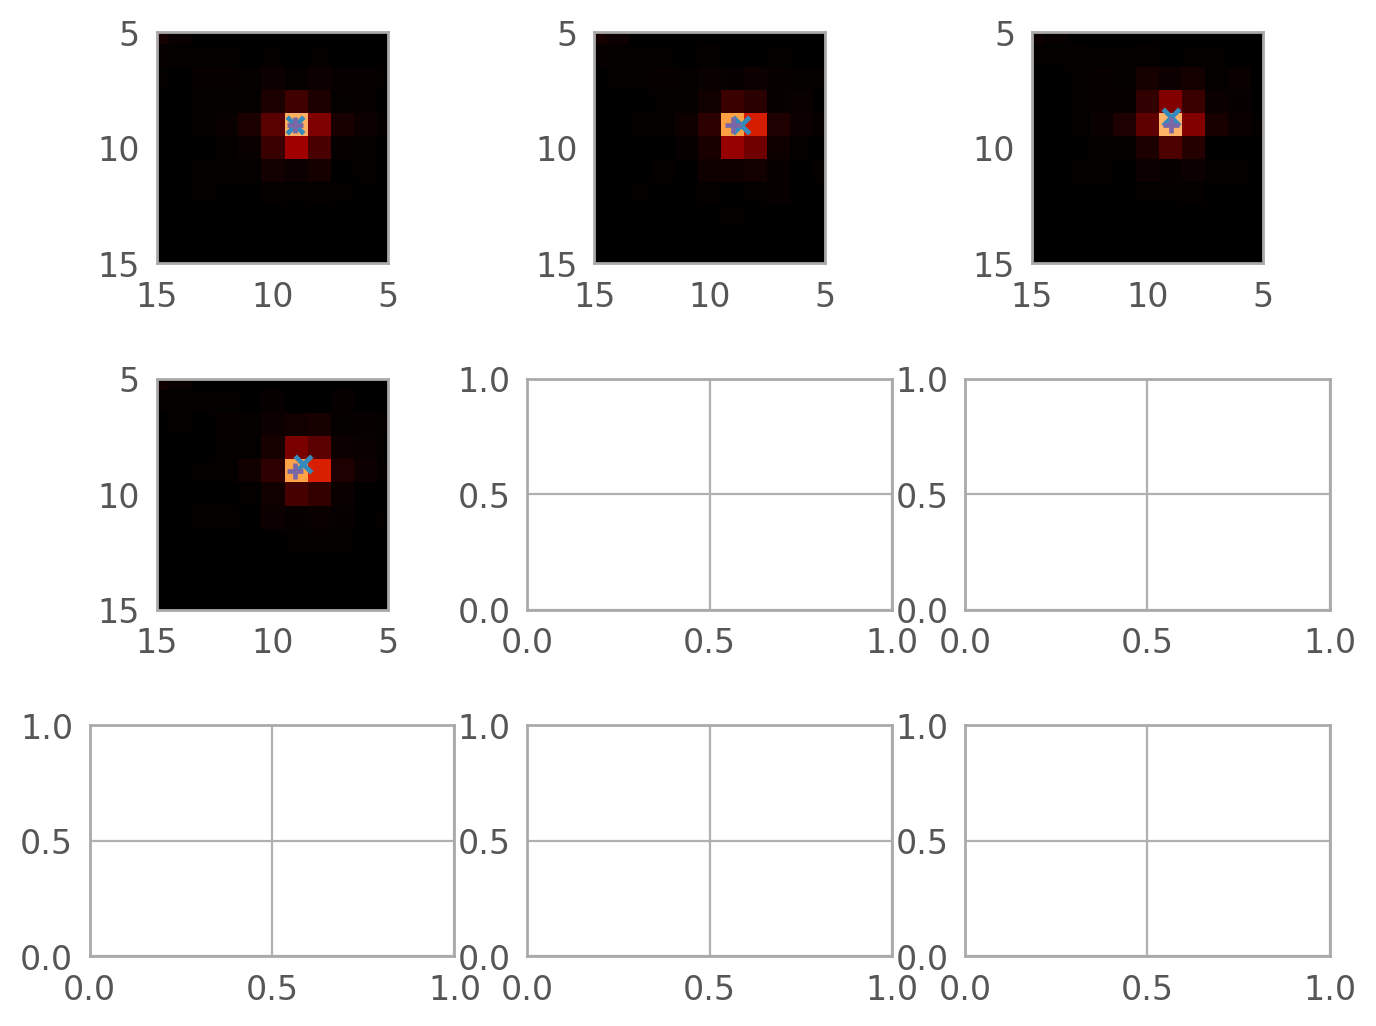

In [2818]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat

for i in range(9): 
    data = aligned_atlas[i]
    qso_center = [nx_aligned//2 - 1 + centroids_dec[i, 0], 
              ny_aligned//2 - 1 + centroids_dec[i, 1]]
    img_center = [nx_aligned//2 - 1, ny_aligned//2 - 1]
    axs[i].imshow(np.arcsinh(data), vmin=0, vmax=5)
    axs[i].scatter(*qso_center, marker='x')
    axs[i].scatter(*img_center, marker='+')
    # axs[i].set_xlim(30, 35)
    # axs[i].set_ylim(30, 35)
    axs[i].set_xlim(int(nx/2)+5, int(nx/2)-5)
    axs[i].set_ylim(int(ny/2)+5, int(ny/2)-5)
    axs[i].grid(False)

plt.tight_layout()
plt.show()

In [2819]:
centroids_large = centroids_dec*factor

enlarge images

In [2820]:
N_image = len(aligned_atlas)
nx0, ny0 = aligned_atlas[0].shape
nx = nx0*factor
ny = ny0*factor

large_atlas = []
for data in aligned_atlas: 
    large_data = np.zeros((nx, ny), dtype=data.dtype)
    large_data[::factor, ::factor] = data
    # large_data = np.repeat(np.repeat(data, 3, axis=0), 3, axis=1)
    large_atlas.append(large_data)

naive coaddition

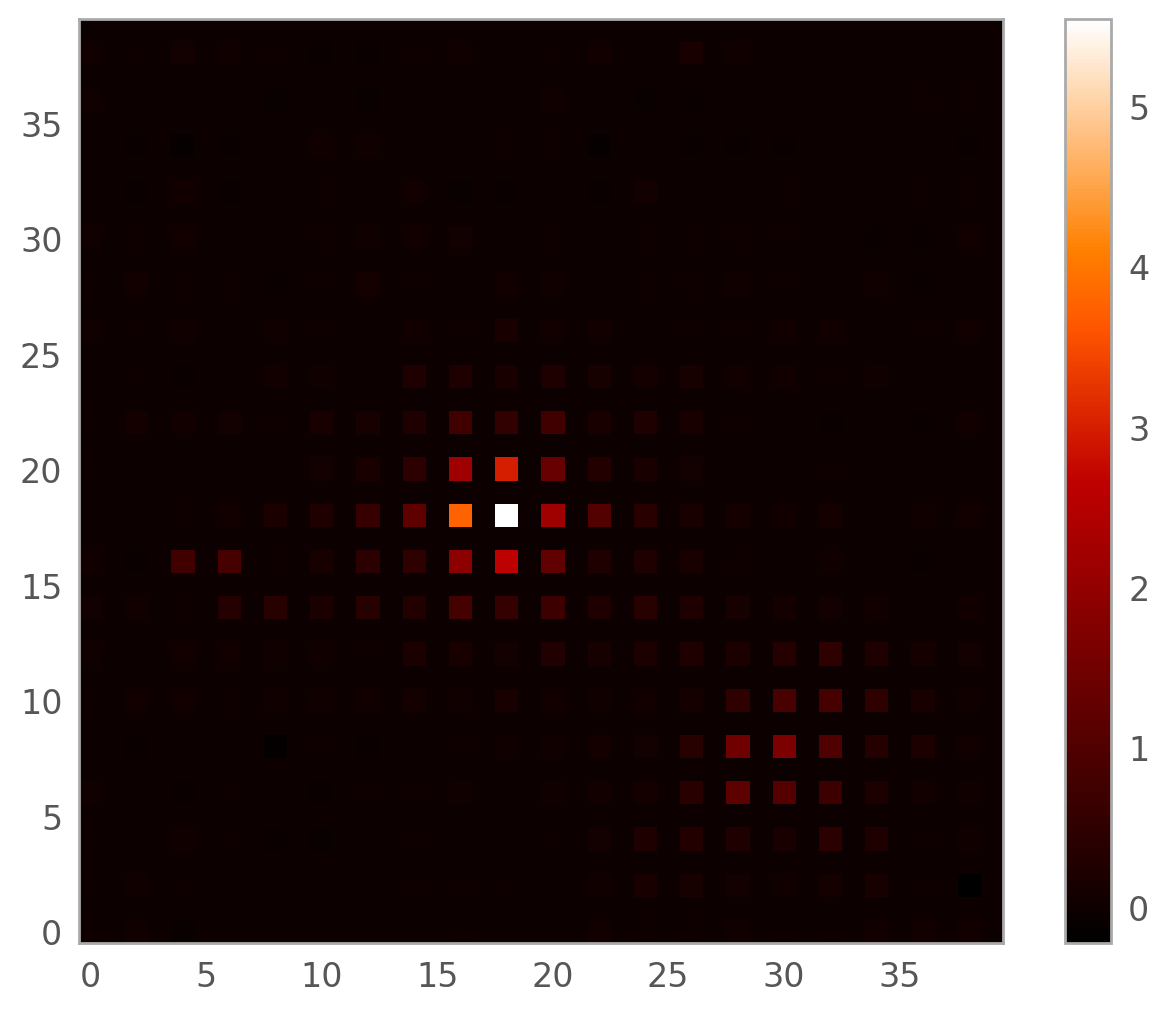

In [2821]:
# centroids_naive = np.array(np.meshgrid([0, 1, 2], [0, 1, 2])).reshape(2, 9).T

interp = np.zeros((nx, ny))
for i in range(N_image): 
    large_data = large_atlas[i]
    dx = int(centroids_large[i, 0])
    dy = int(centroids_large[i, 1])
    interp += np.roll(np.roll(large_data, dx, axis=1), dy, axis=0)
plt.imshow(np.arcsinh(interp))#, vmin=0, vmax=2)
# plt.imshow(interp, vmin=0, vmax=1)
plt.grid(False)
plt.colorbar()

Construct the 3-D ($9\times ny \times nx$) detection matrix $\hat{\textbf D}$

In [2822]:
Y, X = np.meshgrid(np.arange(nx)/nx, np.arange(ny)/ny)

D_hat = []
for i in range(N_image): 
    large_data = large_atlas[i]
    large_data_hat = fft.fft2(large_data)
    # dx = centroids[i, 0]
    # dy = centroids[i, 1]
    # dx = int(dx)
    # dy = int(dy)
    dx = -centroids_large[i, 0]
    dy = -centroids_large[i, 1]
    large_data_hat_shifted = large_data_hat*np.exp(-2*np.pi*1j*(X*dx+Y*dy))
    D_hat.append(large_data_hat_shifted)
    # D_hat.append(large_data_hat)
    print(dx, dy)
D_hat = np.array(D_hat, dtype=large_data_hat.dtype)

-0.0 -0.0
0.6666666666666666 -0.0
-0.0 0.6666666666666666
0.6666666666666666 0.6666666666666666


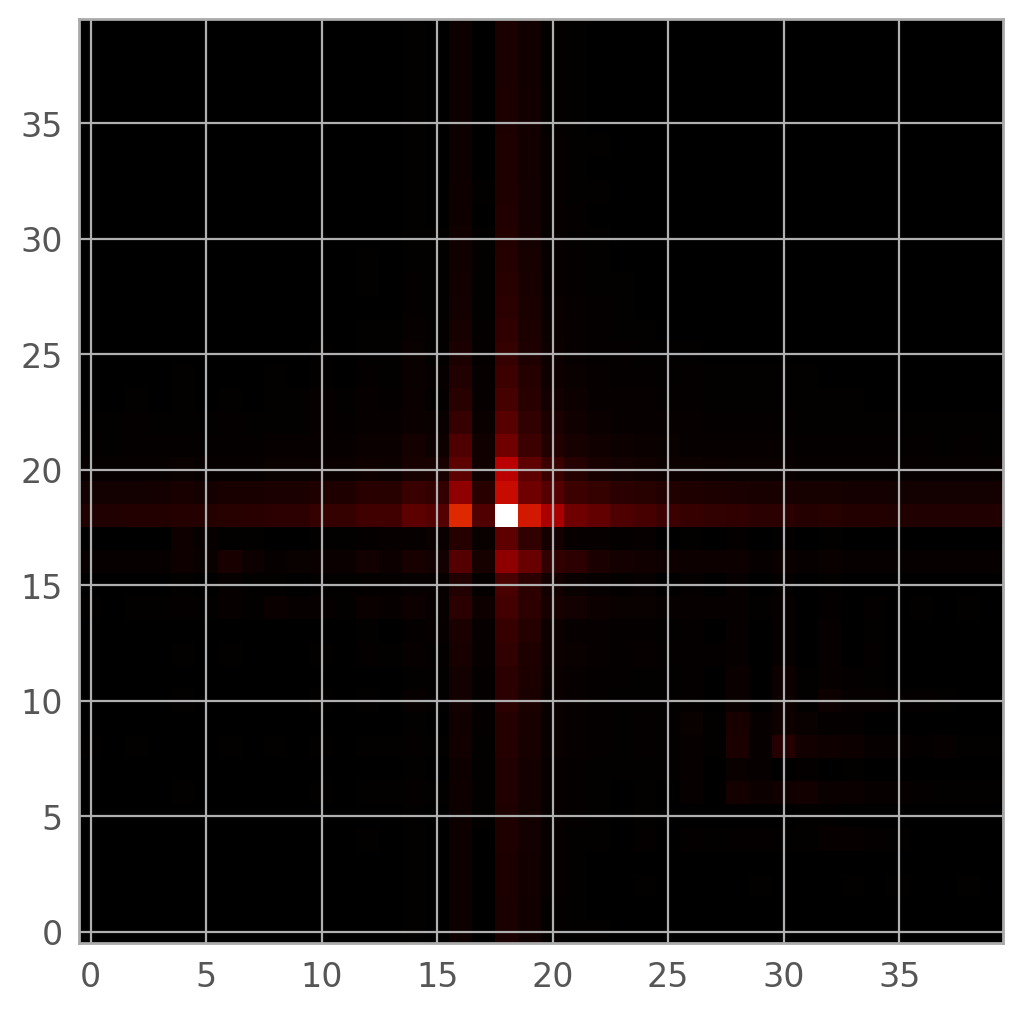

In [2823]:
plt.imshow(np.sum([np.arcsinh(norm(fft.ifft2(D_hat[i]))) for i in range(N_image)], axis=0))
# plt.imshow(np.arcsinh(fft.ifft2(D_hat[1])).real)

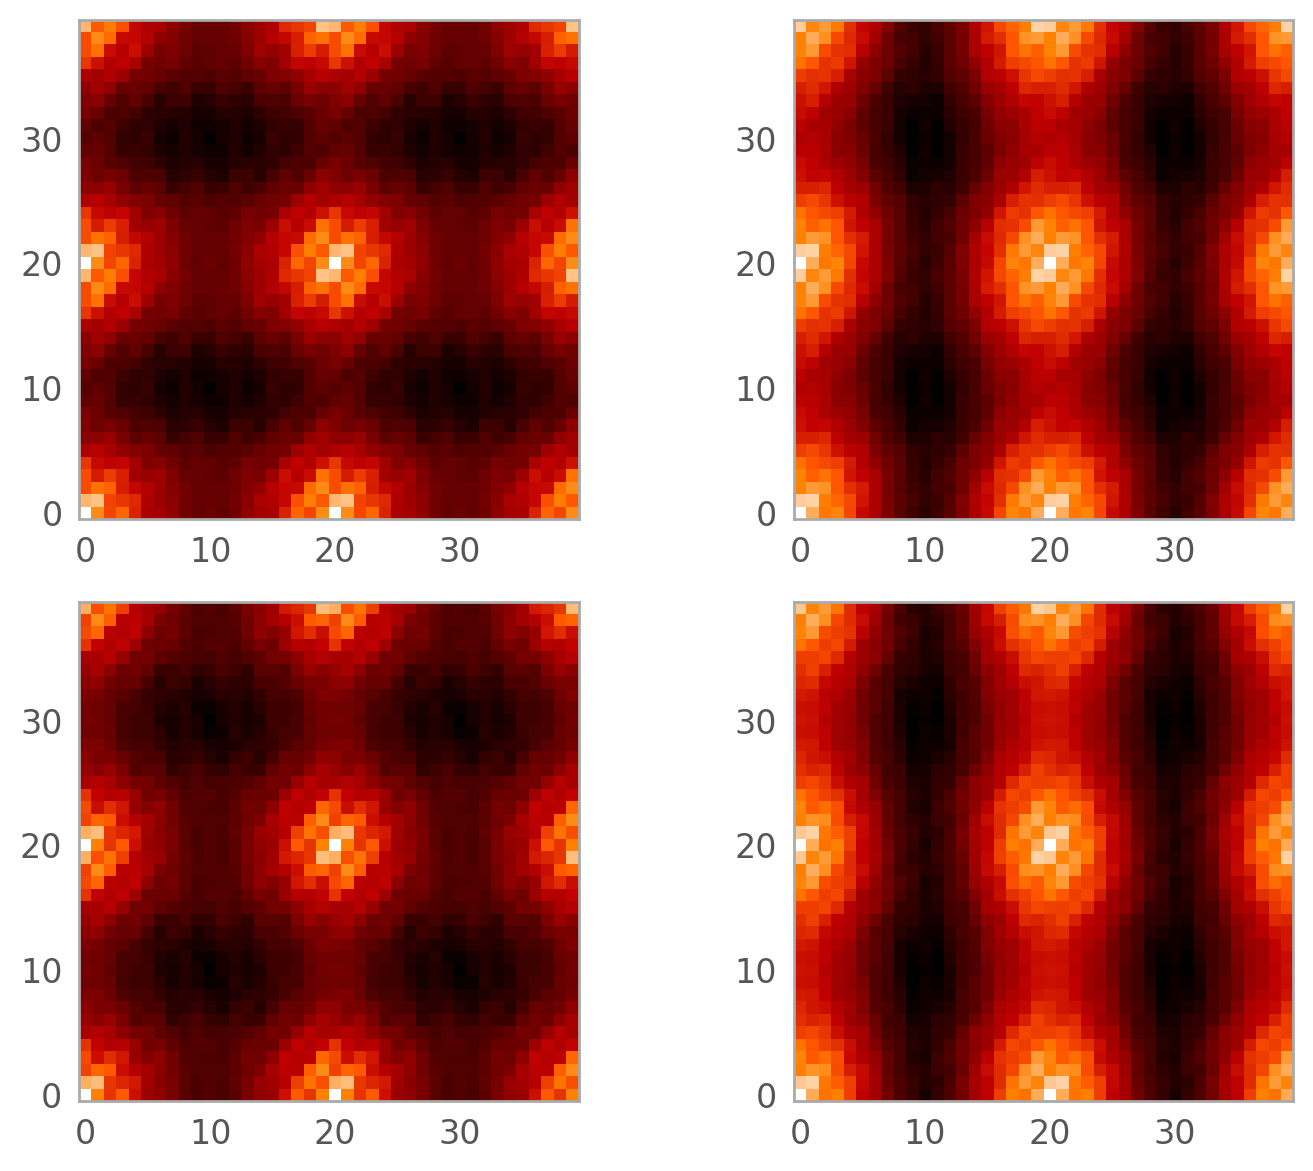

In [2824]:
fig, axs = plt.subplots(factor, factor)
axs = axs.flat
for i in range(factor**2): 
    data = get_power_spectrum(D_hat[i])
    # print(data.shape)
    axs[i].imshow(np.arcsinh(data))
    axs[i].grid(False)

plt.tight_layout()

Construct the 2-D ($9\times9$) transformation matrix $\hat{\mathbf\Phi}$

$$
\hat{\mathbf\Phi}=\frac{1}{9}\left(\begin{array}{cccc}
1 & e^{-\pi i x_1} & e^{-x y_1} & \dots & e^{-\pi i\left(2x_1+2y_1\right)} \\
1 & e^{-\pi i x_2} & e^{-x y_2} & \dots & e^{-x i\left(2x_2+2y_2\right)} \\
\vdots & \vdots & \vdots & \dots & \vdots \\
1 & e^{-\pi i x_n} & e^{-x y_n} & \dots & e^{-\pi i\left(2x_n+2y_n\right)}
\end{array}\right)
$$

0 -0.0 0 -0.0 0.0
0 -0.0 1 -0.0 0.0
1 -0.0 0 -0.0 0.0
1 -0.0 1 -0.0 0.0
0 0.6666666666666666 0 -0.0 -0.0
0 0.6666666666666666 1 -0.0 -0.0
1 0.6666666666666666 0 -0.0 -0.6981317007977318
1 0.6666666666666666 1 -0.0 -0.6981317007977318
0 -0.0 0 0.6666666666666666 -0.0
0 -0.0 1 0.6666666666666666 -0.6981317007977318
1 -0.0 0 0.6666666666666666 -0.0
1 -0.0 1 0.6666666666666666 -0.6981317007977318
0 0.6666666666666666 0 0.6666666666666666 -0.0
0 0.6666666666666666 1 0.6666666666666666 -0.6981317007977318
1 0.6666666666666666 0 0.6666666666666666 -0.6981317007977318
1 0.6666666666666666 1 0.6666666666666666 -1.3962634015954636


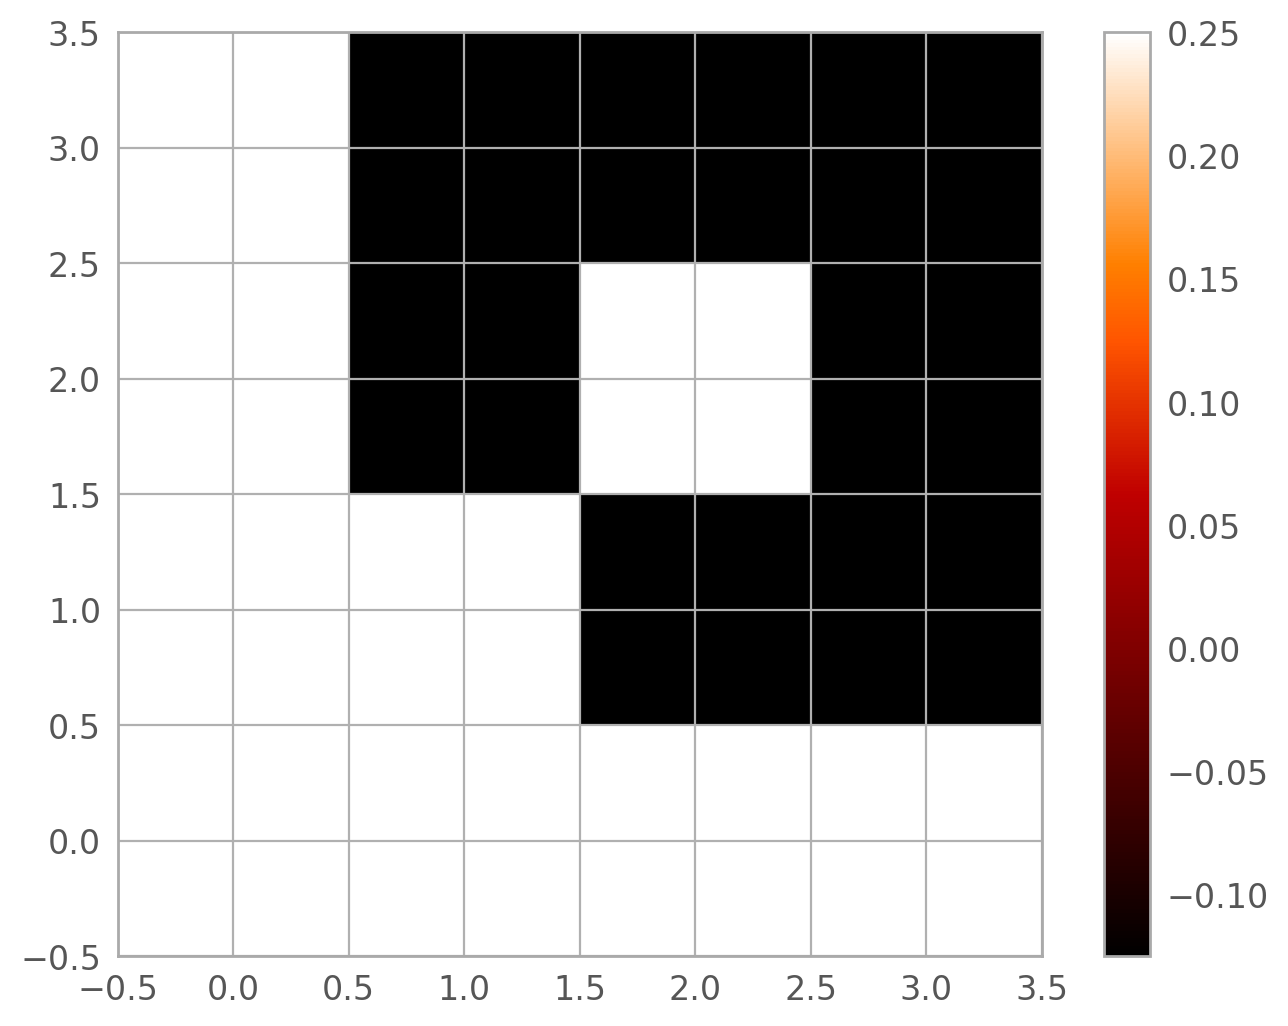

In [2825]:
# x = centroids.T[0] - centroids[0, 0]
# y = centroids.T[1] - centroids[0, 1]

Phi_hat = np.zeros((N_image, factor**2), dtype=D_hat.dtype)
for i in range(N_image): 
    for j in range(factor**2): 
        dx = -centroids_large[i, 0]
        dy = -centroids_large[i, 1]
        mx = j//factor
        my = j%factor
        print(mx, dx, my, dy, -np.pi*(mx*dx+my*dy)/3)
        Phi_hat[i, j] = np.exp(-2*np.pi*1j*(mx*dx+my*dy)/factor)
Phi_hat = Phi_hat/N_image




plt.imshow(Phi_hat.real)
plt.colorbar()

In [2826]:
Phi_hat

array([[ 0.25 +0.j   ,  0.25 +0.j   ,  0.25 +0.j   ,  0.25 +0.j   ],
       [ 0.25 -0.j   ,  0.25 -0.j   , -0.125-0.217j, -0.125-0.217j],
       [ 0.25 -0.j   , -0.125-0.217j,  0.25 -0.j   , -0.125-0.217j],
       [ 0.25 -0.j   , -0.125-0.217j, -0.125-0.217j, -0.125+0.217j]])

Solve for $\hat{\mathbf F}$ in the linear equation $\hat{\mathbf\Phi} \hat{\mathbf F} = \hat{\mathbf D}$:

In [2827]:
_, nx, ny = D_hat.shape

D_hat_flat = D_hat.reshape(N_image, nx*ny)

F_hat_flat = la.lstsq(Phi_hat, D_hat_flat)[0]

F_hat = F_hat_flat.reshape(factor**2, nx, ny)

/tmp/ipykernel_1814209/3783655684.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F_hat_flat = la.lstsq(Phi_hat, D_hat_flat)[0]


get the inverse of $\hat{\mathbf\Phi}$

In [2828]:
Phi_hat_inv = la.inv(Phi_hat)

coeffs = Phi_hat_inv[:, 0]
coeffs

array([0.667+1.155j, 1.333+0.j   , 1.333+0.j   , 0.667-1.155j])

In [2829]:
# coeffs /= norm(coeffs)

In [2830]:
# I = Phi_hat_inv @ Phi_hat

# plt.imshow(norm(I))
# plt.colorbar()

In [2831]:
F_hat = np.zeros(D_hat[0].shape, dtype=np.complex128)

i = 0

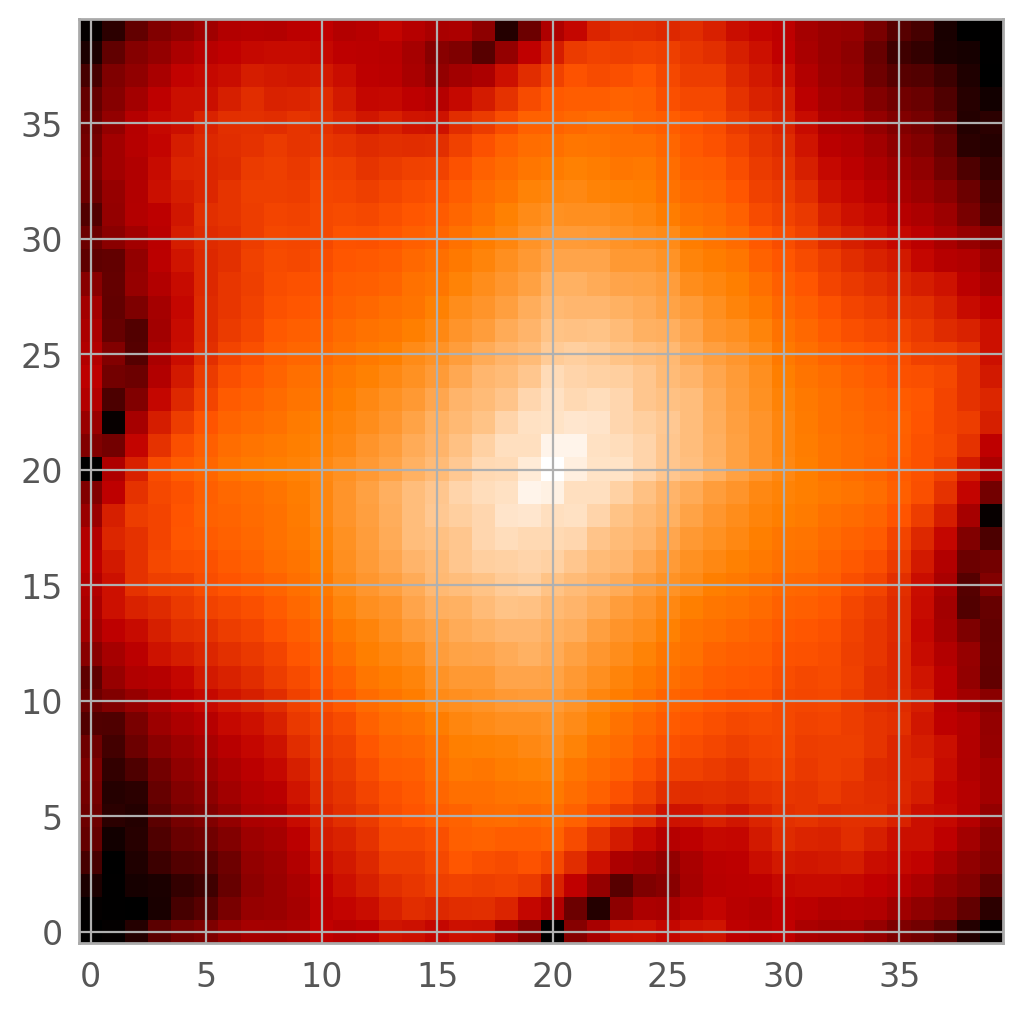

In [2835]:
F_hat += coeffs[i]*D_hat[i]

i += 1

pow = get_power_spectrum(F_hat)

plt.imshow(np.log(pow+1), vmin=0)

Get the real representation $F$

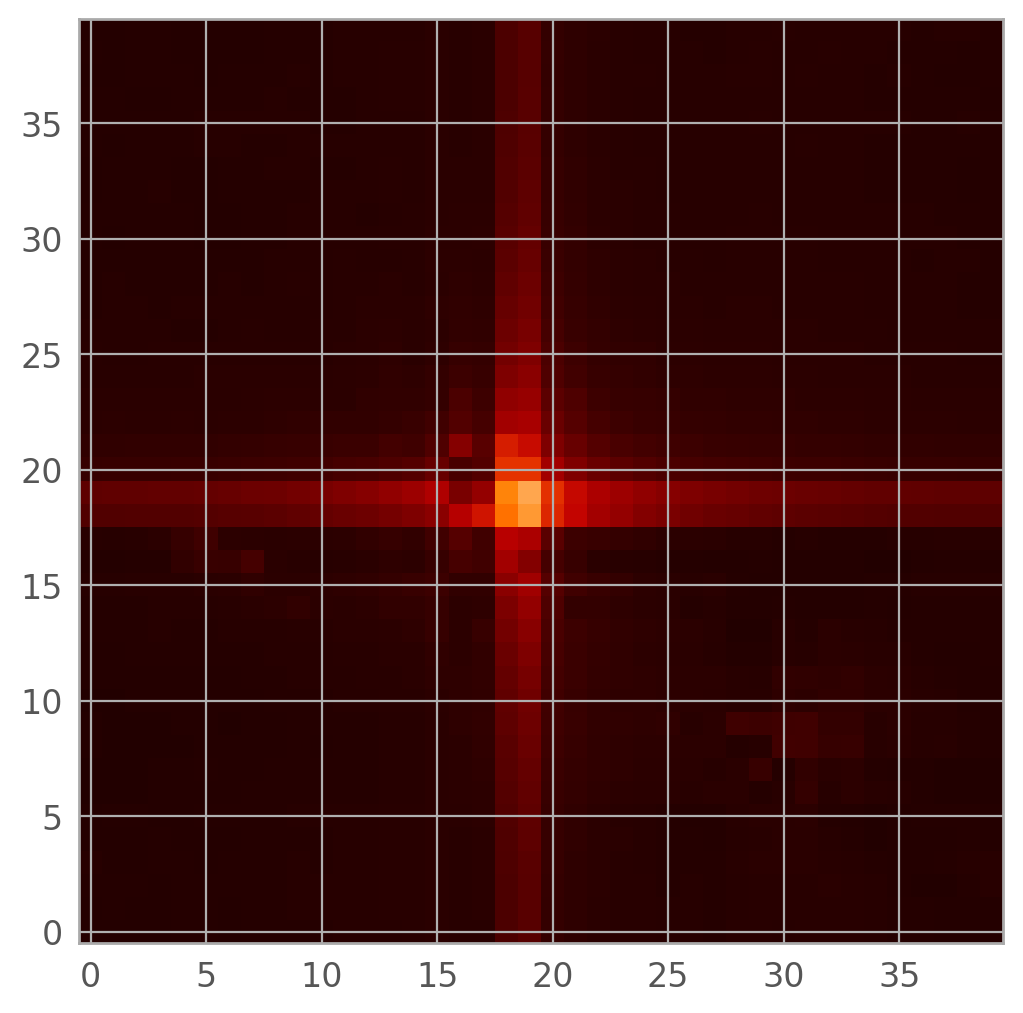

In [2836]:
F = norm(fft.ifft2(F_hat))
plt.imshow(np.arcsinh(F), vmin=-0.5, vmax=5)

# plt.imshow(np.arcsinh(orig), vmin=-0.5, vmax=5)

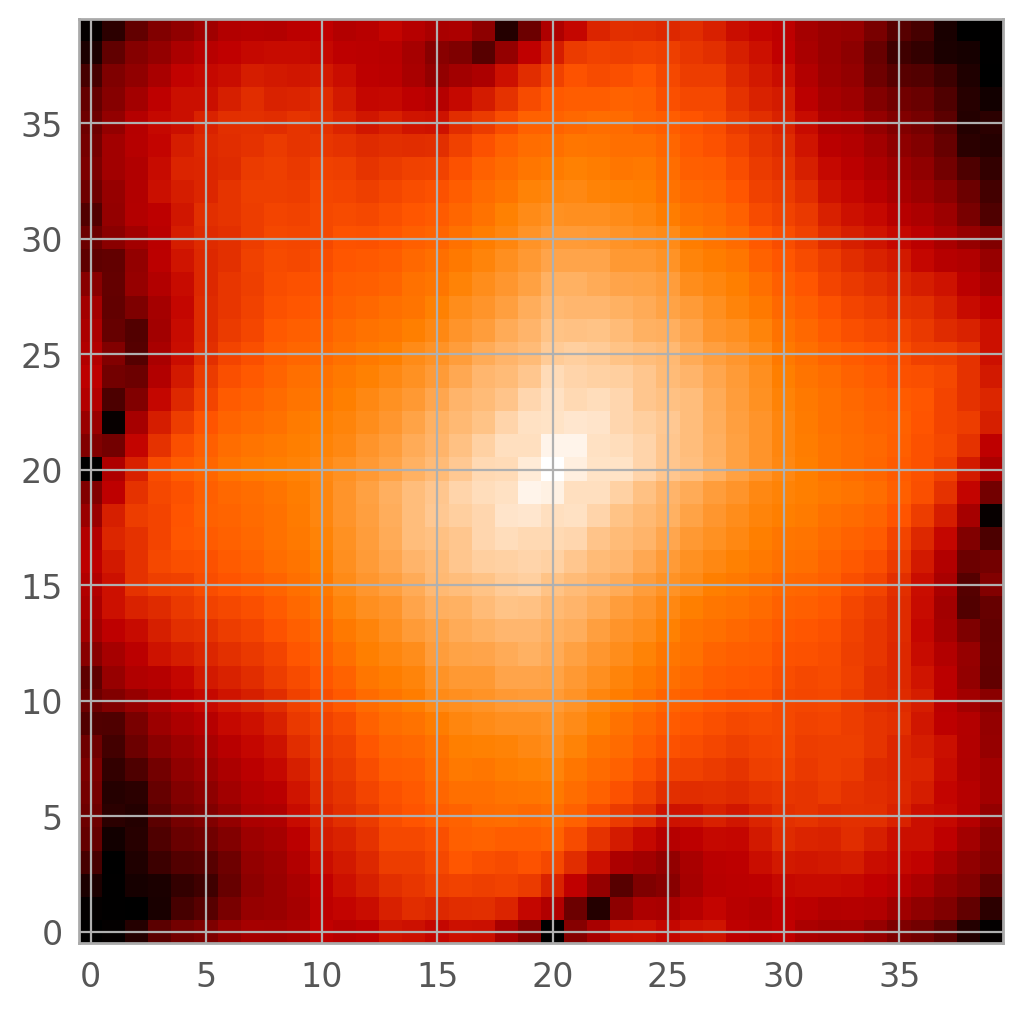

In [2837]:

pow = get_power_spectrum(fft.fft2(norm(fft.ifft2(F_hat))))
pow = get_power_spectrum(fft.fft2(fft.ifft2(F_hat)))

plt.imshow(np.log(pow+1))

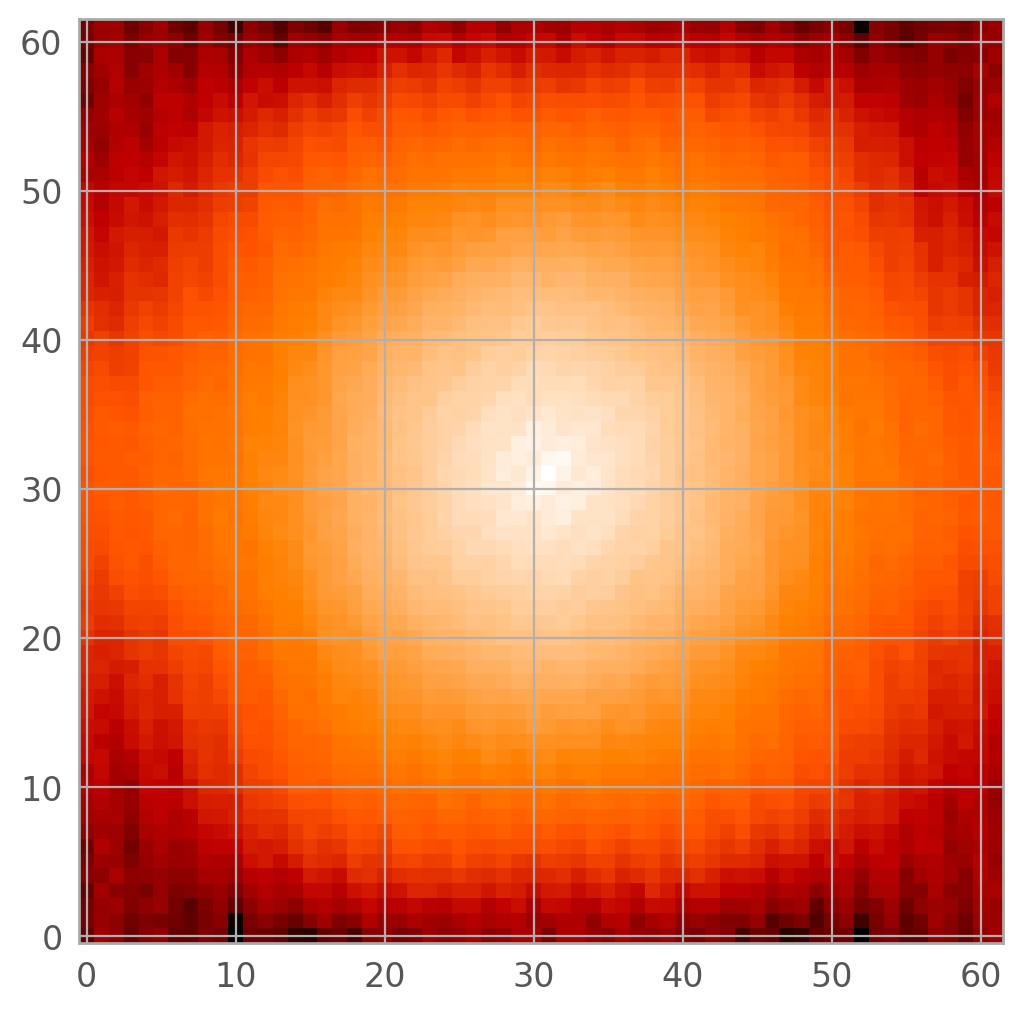

In [2838]:
pow = get_power_spectrum(fft.fft2(orig))

plt.imshow(np.log(pow+1))

In [2039]:
# dxf = np.mean(centroids_large[:, 0])
# dyf = np.mean(centroids_large[:, 1])
# F = norm(fft.ifft2(F_hat[0]*np.exp(-2*np.pi*1j*(X*dxf+Y*dyf))))
# plt.imshow(np.arcsinh(F))#, vmin=0, vmax=1)

F = norm(fft.ifft2(F_hat[0]))
plt.imshow(np.arcsinh(F))#, vmin=-0.5, vmax=5)


# sampled_F = F.reshape(nx//10, 10, ny//10, 10).mean(axis=(1, 3))
# plt.imshow(np.arcsinh(sampled_F))


IndexError: index -2 is out of bounds for axis 0 with size 1

TypeError: Invalid shape (132,) for image data

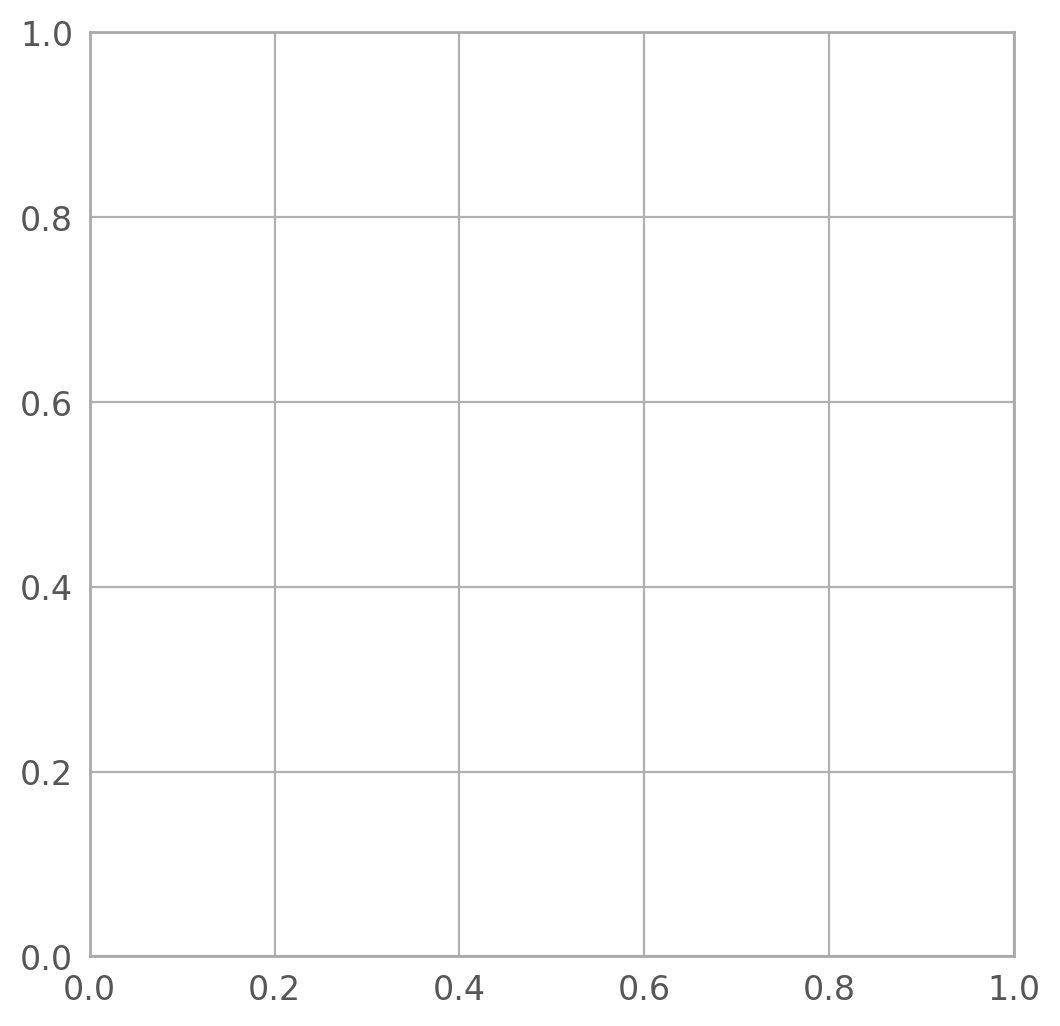

In [2040]:

pow = get_power_spectrum(F_hat[0])
plt.imshow(np.log(pow+1))

TEST 2-D Image

array([[ 0.   ,  0.   ],
       [ 0.   , -0.333],
       [ 0.   , -0.667],
       [-0.333,  0.   ],
       [-0.333, -0.333],
       [-0.333, -0.667],
       [-0.667,  0.   ],
       [-0.667, -0.333],
       [-0.667, -0.667]])

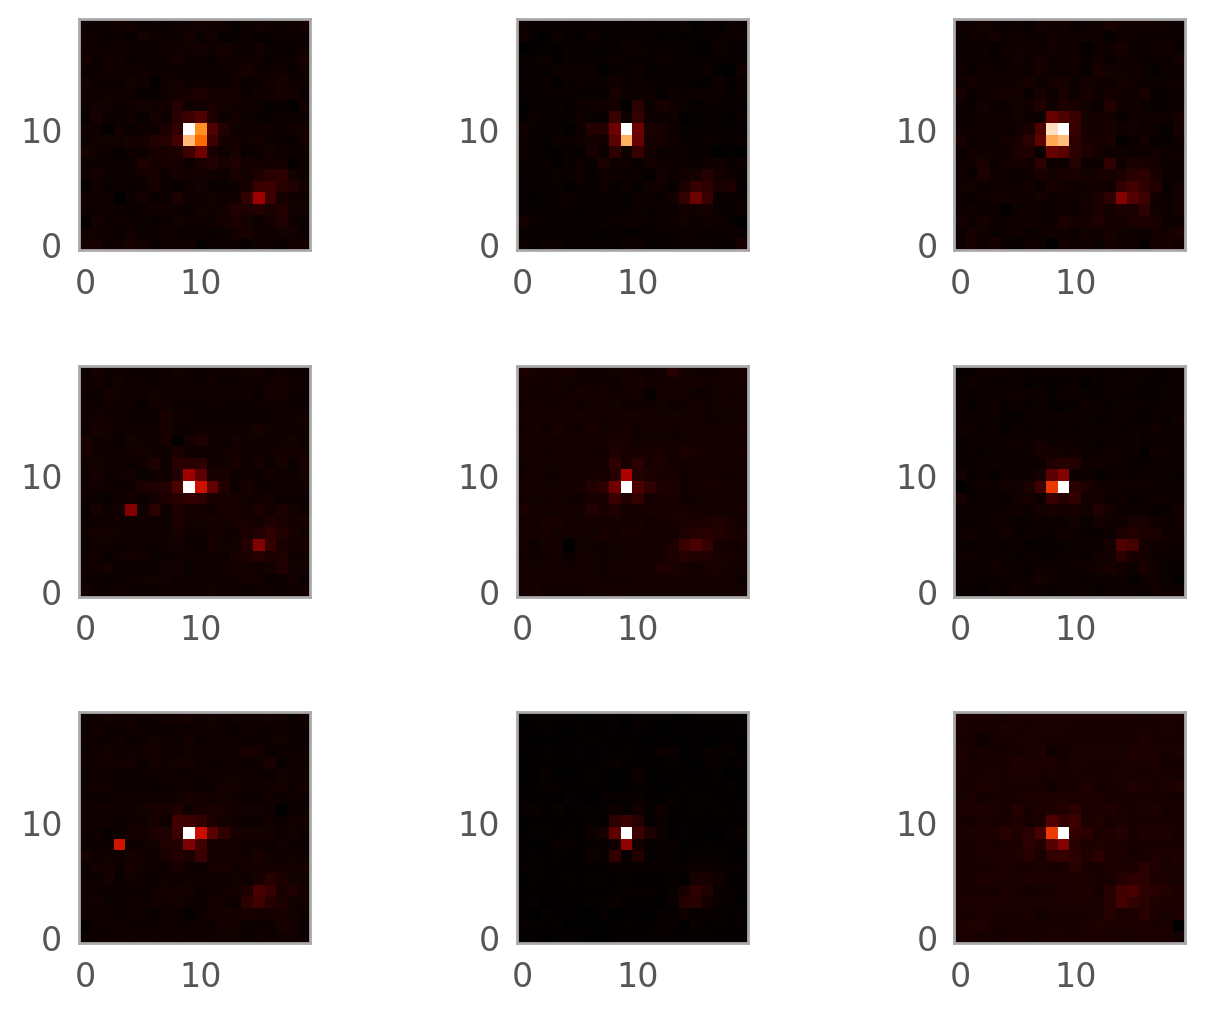

In [3551]:
nx = 60
ny = 60

with fits.open(cutout_paths[0]) as hdul: 
    orig = hdul[1].data

centroids = []
test_atlas = []
for i in range(3): 
    for j in range(3): 
        test_slice = orig[i:60+i:3, j:60+j:3]
        # test_slice = orig[i:60+i, j:60+j].reshape(20, 3, 20, 3).mean(axis=(1, 3))
        # test_slice = stretch(shift(orig, (-i/3, -j/3)))
        test_atlas.append(test_slice)
        centroids.append([-i/3, -j/3])
centroids = np.array(centroids)

fig, axs = plt.subplots(3, 3)
axs = axs.flat
for i in range(9): 
    data = test_atlas[i]
    # print(data.shape)
    axs[i].imshow(np.arcsinh(data))
    axs[i].grid(False)

centroids

In [3513]:
# # real data


# test_atlas = orig_atlas.copy()
# centroids = np.array(centroids_dec)

# fig, axs = plt.subplots(3, 3)
# axs = axs.flat
# for i in range(9): 
#     data = test_atlas[i]
#     # print(data.shape)
#     axs[i].imshow(np.arcsinh(data))
#     axs[i].grid(False)

# centroids

In [3514]:
# factor = 2

# test_atlas = test_atlas[:4]
# # centroids = np.array([centroids[i] for i in [0, 1, 3, 4]])
# centroids = -centroids[:4]

In [3552]:
factor = 2

test_atlas = [test_atlas[i] for i in [0, 1, 6, 8]]
# centroids = np.array([centroids[i] for i in [0, 1, 3, 4]])
centroids = np.array([[0, 0], 
                     [-1/3, 0],
                     [0, -2/3],
                     [-2/3, -2/3]])


In [3553]:
shifted_atlas = test_atlas

factor = 2
old_shape = shifted_atlas[0].shape
new_shape = (old_shape[0]*factor, old_shape[1]*factor)
large_atlas = []
for data in shifted_atlas: 
    large_data = np.zeros(new_shape, dtype=data.dtype)
    large_data[::factor, ::factor] = data
    # large_data = np.repeat(np.repeat(data, 3, axis=0), 3, axis=1)
    large_atlas.append(large_data)

In [3554]:
factor_temp = 3
interp = np.zeros((factor_temp*20, factor_temp*20))
for i in range(factor_temp**2): 
    large_data = large_atlas[i]
    nx, ny = large_data.shape
    dx = int(centroids[i, 0]*factor_temp)
    dy = int(centroids[i, 1]*factor_temp)
    print(dx, dy, )
    interp[dx:dx+nx:factor_temp, dy:dy+ny:factor_temp] = large_data[::factor_temp, ::factor_temp]
    # plt.scatter()
plt.imshow(np.arcsinh(interp))

0 0
-1 0


ValueError: could not broadcast input array from shape (14,14) into shape (0,14)

-0.0 -0.0
0.6666666666666666 -0.0
-0.0 1.3333333333333333
1.3333333333333333 1.3333333333333333


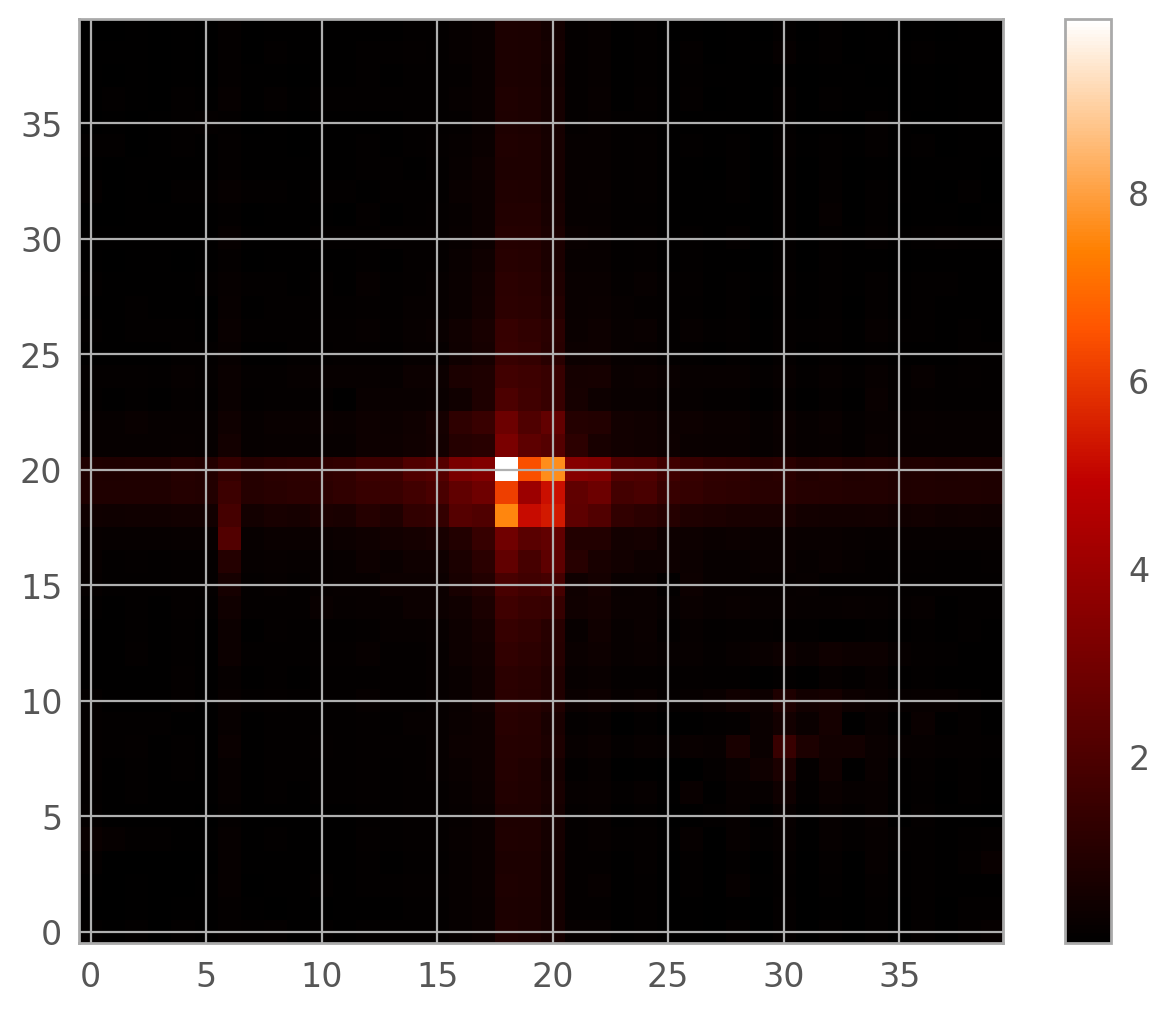

In [3555]:
nx, ny = test_atlas[0].shape

X, Y = np.meshgrid(np.arange(factor*nx)/(factor*nx), np.arange(factor*ny)/(factor*ny))

D_hat = []
for i in range(len(large_atlas)): 
    large_data = large_atlas[i]
    large_data_hat = fft.fft2(large_data)#, axes=(-1, -2))
    dx = -centroids[i, 0]*factor
    dy = -centroids[i, 1]*factor
    print(dx, dy)
    large_data_hat = large_data_hat*np.exp(-2*np.pi*1j*(X*dx+Y*dy))
    D_hat.append(large_data_hat)
D_hat = np.array(D_hat, dtype=large_data_hat.dtype)

plt.imshow(np.sum([np.arcsinh(norm(fft.ifft2(D_hat[i]))) for i in range(factor**2)], axis=0))
# plt.imshow(np.arcsinh(fft.ifft2(D_hat[0])).real + np.arcsinh(fft.ifft2(D_hat[3])).real)
plt.colorbar()

IndexError: index 4 is out of bounds for axis 0 with size 4

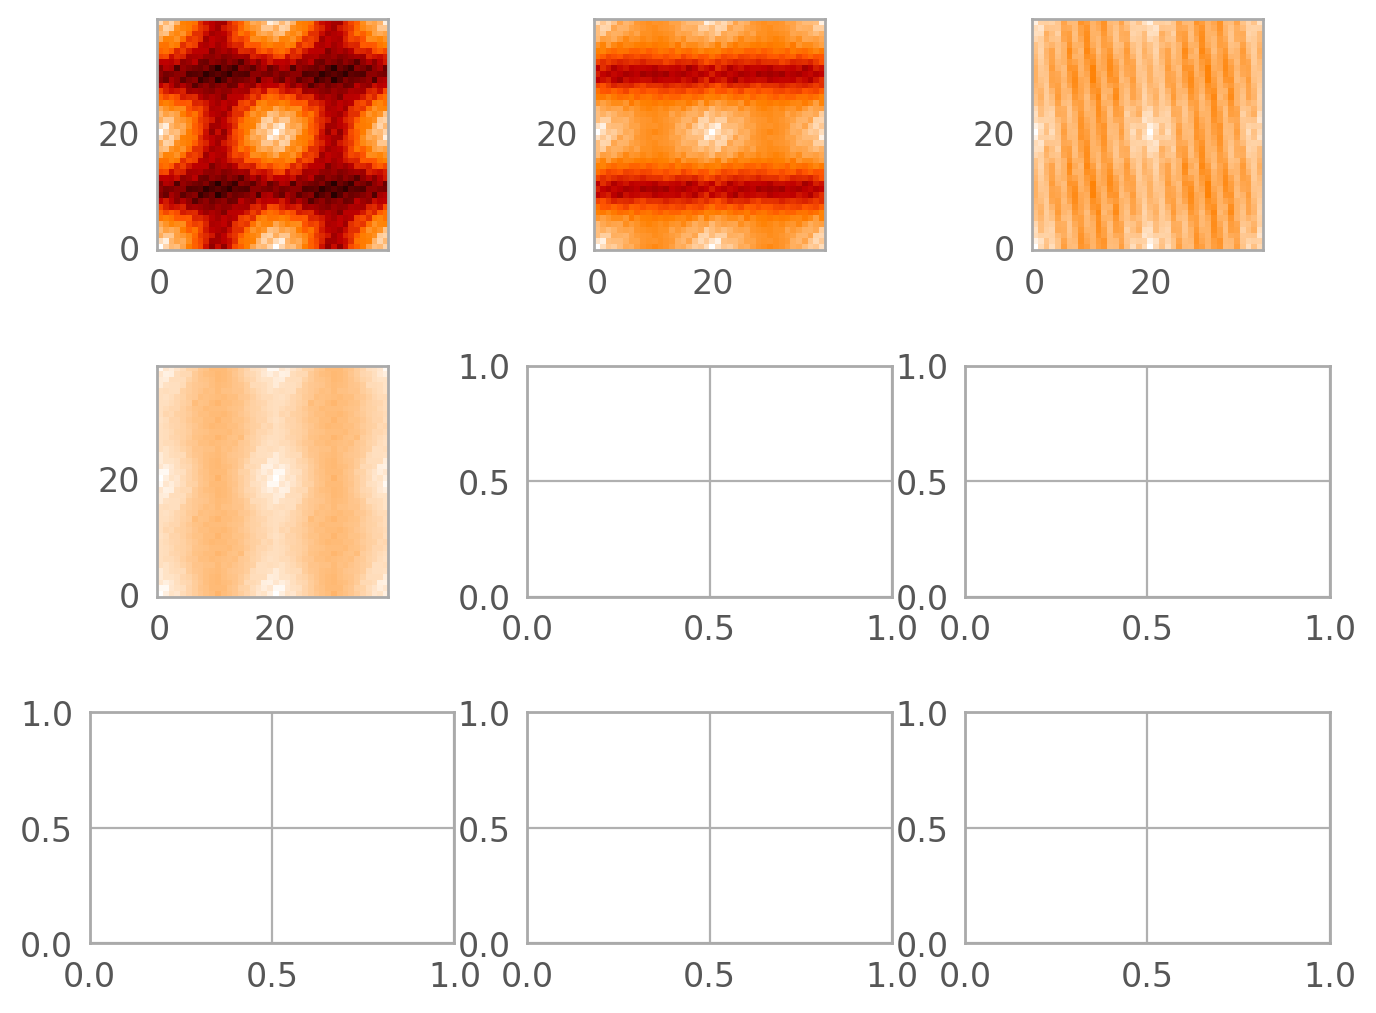

In [3556]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat
for i in range(9): 
    pow = get_power_spectrum(D_hat[i])
    # print(pow.shape)
    axs[i].imshow(np.log(pow+1), vmin=0)
    axs[i].grid(False)

plt.tight_layout()

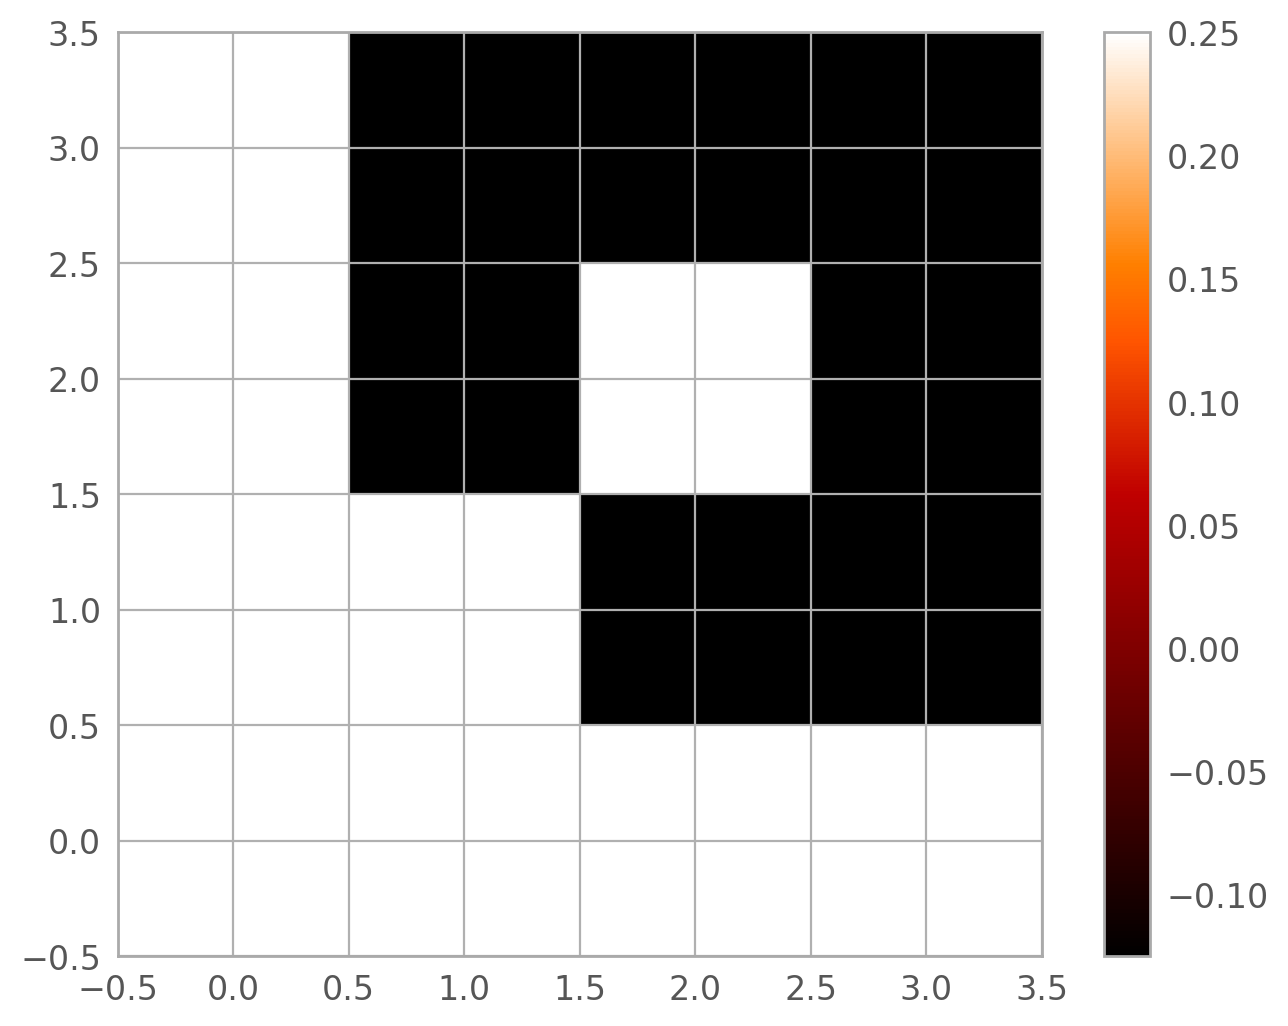

In [3557]:
Phi_hat = np.zeros((factor**2, factor**2), dtype=D_hat.dtype)
for i in range(factor**2): 
    for j in range(factor**2): 
        dx = -centroids[i, 0]*factor
        dy = -centroids[i, 1]*factor
        mx = j//factor
        my = j%factor
        # print(mx, dx, my, dy, -2*np.pi*(mx*dx+my*dy)/3)
        # print(-2*np.pi*(mx*dx+my*dy)/factor)
        Phi_hat[i, j] = np.exp(-2*np.pi*1j*(mx*dx+my*dy)/factor)
        # print(mx*dx+my*dy)
Phi_hat = Phi_hat/factor**2

# (Phi_hat*factor**2)

plt.imshow(Phi_hat.real)
plt.colorbar()

In [3558]:
_, nx, ny = D_hat.shape

D_hat_flat = D_hat.reshape(factor**2, nx*ny)

F_hat_flat = la.lstsq(Phi_hat, D_hat_flat)[0]

F_hat = F_hat_flat.reshape(factor**2, nx, ny)

/tmp/ipykernel_1814209/2298936315.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F_hat_flat = la.lstsq(Phi_hat, D_hat_flat)[0]


In [3559]:
# F_hat_flat = la.inv(Phi_hat) @ D_hat_flat
# F_hat = F_hat_flat.reshape(9, nx, ny)

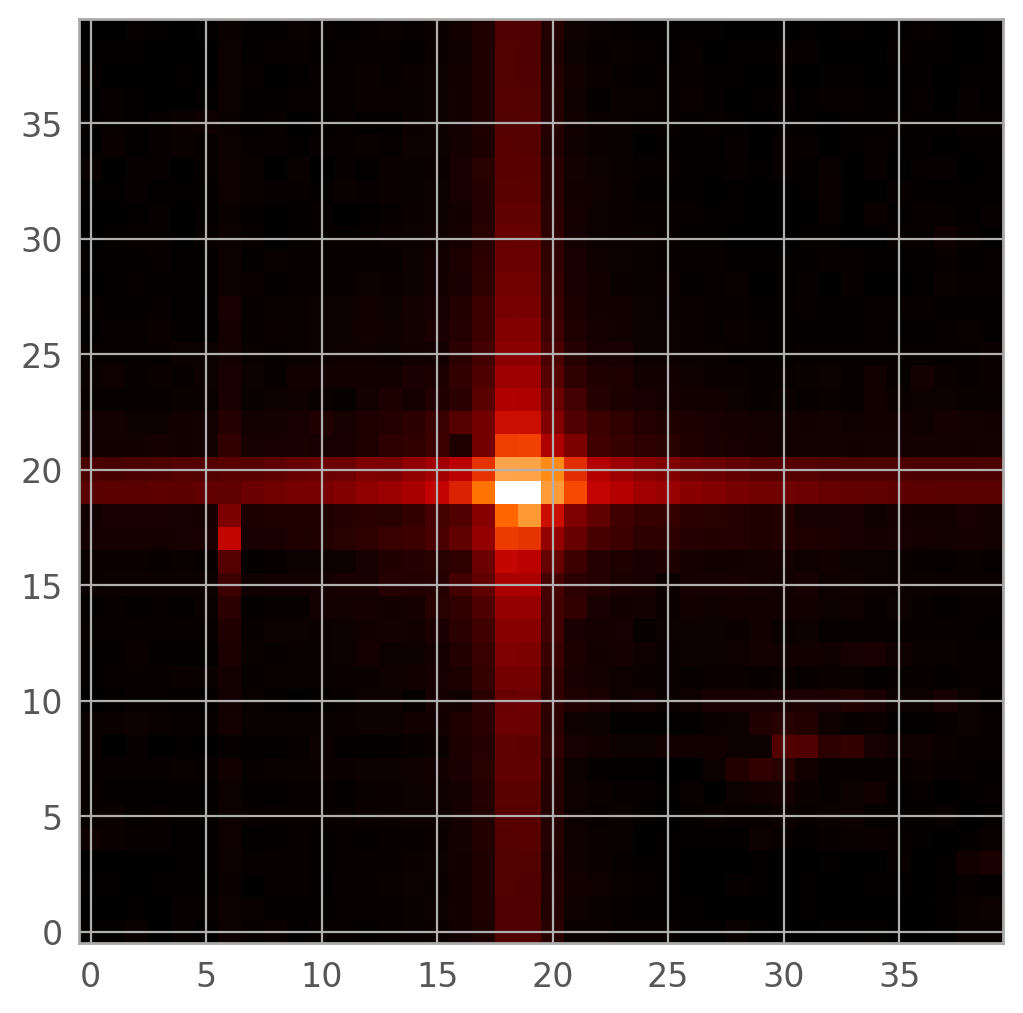

In [3560]:
F = norm(fft.ifft2(F_hat[0]))

# plt.imshow(stretch(F[::3, ::3]))
plt.imshow(np.arcsinh(F))

# plt.imshow(np.arcsinh(F[::3, ::3]))

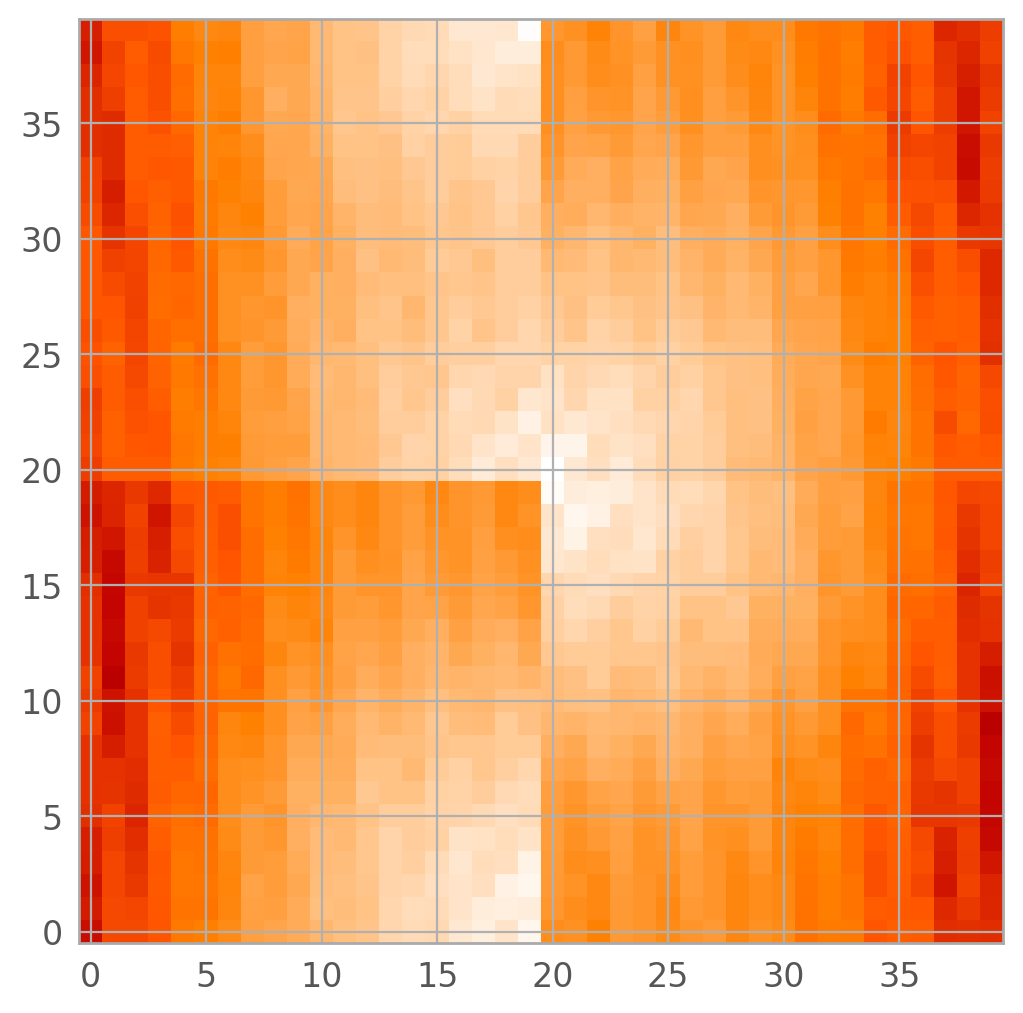

In [3561]:
pow = get_power_spectrum(F_hat[0])
plt.imshow(np.log(pow+1), vmin=0)

In [3562]:
Phi_hat_inv = la.inv(Phi_hat)

coeffs = Phi_hat_inv[:, 0]
coeffs

array([1.333+0.j   , 0.667+1.155j, 0.667-1.155j, 1.333-0.j   ])

In [3563]:
norm(coeffs)

array([1.333, 1.333, 1.333, 1.333])

In [3564]:
coefs

array([[0.667+1.155j, 1.333-0.j   ],
       [1.333+0.j   , 0.667-1.155j],
       [1.333+0.j   , 0.667+1.155j],
       [0.667-1.155j, 1.333+0.j   ]])

IndexError: index 4 is out of bounds for axis 0 with size 4

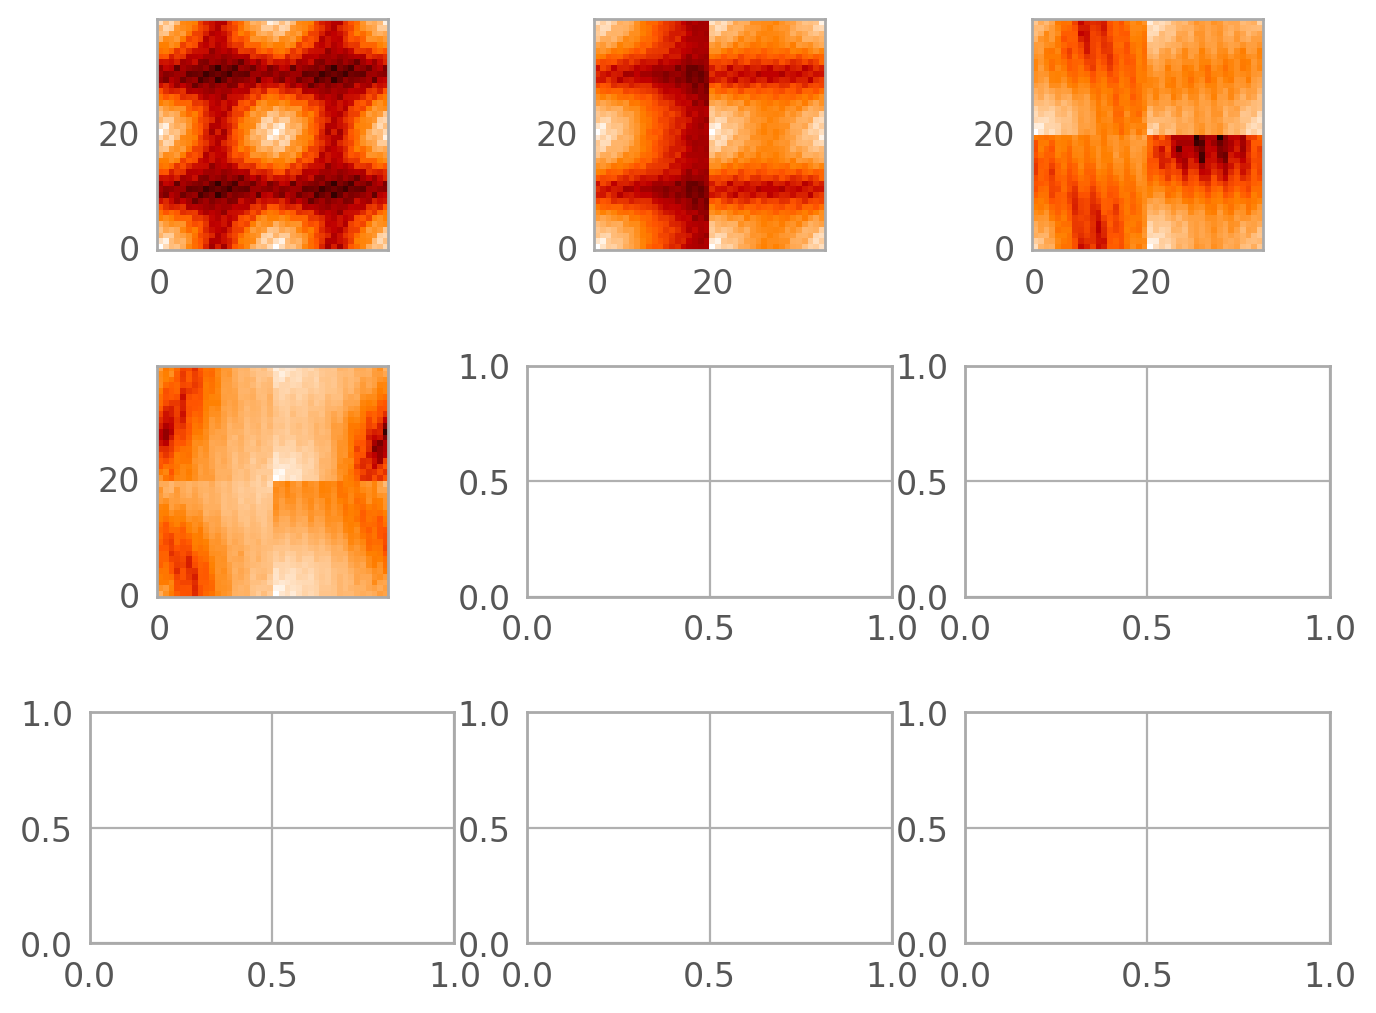

In [3565]:
F_hat = np.zeros(D_hat[0].shape, dtype=np.complex128)

fig, axs = plt.subplots(3, 3)
axs = axs.flat
for i in range(9):
    # F_hat += coefs[i, 0]*D_hat[i]
    # # F_hat += coefs[i, 1]*D_hat[i]
    F_hat += coeffs[i]*D_hat[i]
    
    pow = get_power_spectrum(F_hat)
    # print(pow.shape)
    axs[i].imshow(np.log(pow+1), vmin=0)
    axs[i].grid(False)

plt.tight_layout()

# pow = get_power_spectrum(F_hat)

# plt.imshow(np.log(pow+1), vmin=0)

In [3566]:
print(norm(coeffs4))

coeffs4

[[1.333 1.333 1.333 1.333]
 [1.333 1.333 1.333 1.333]
 [1.333 1.333 1.333 1.333]
 [1.333 1.333 1.333 1.333]]


array([[1.333-0.j   , 0.667+1.155j, 0.667-1.155j, 1.333+0.j   ],
       [0.667-1.155j, 1.333+0.j   , 1.333-0.j   , 0.667+1.155j],
       [0.667+1.155j, 1.333-0.j   , 1.333+0.j   , 0.667-1.155j],
       [1.333+0.j   , 0.667-1.155j, 0.667+1.155j, 1.333-0.j   ]])

In [3567]:
centroids += 1/6

centroids

array([[ 0.167,  0.167],
       [-0.167,  0.167],
       [ 0.167, -0.5  ],
       [-0.5  , -0.5  ]])

-0.3333333333333333 -0.3333333333333333
0.3333333333333333 -0.3333333333333333
-0.3333333333333333 1.0
1.0 1.0


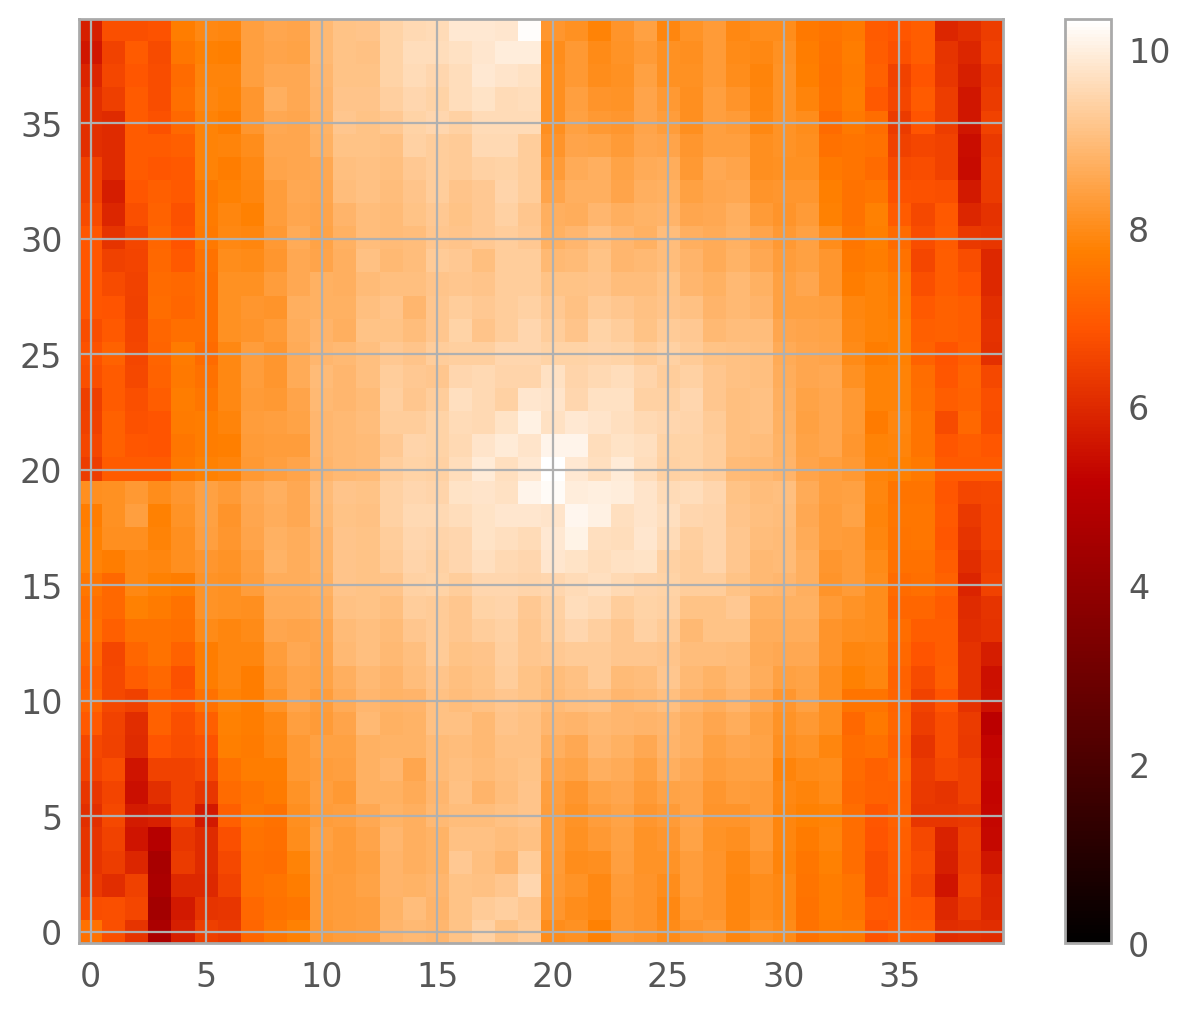

In [3571]:
F_hat_test = np.zeros(large_atlas[0].shape, dtype=np.complex128)

# for i in range(len(large_atlas)): 

sel = [(0.667+1.155j), (0.667-1.155j), 1.333]

i = 0


large_data = large_atlas[i]
# plt.imshow(large_data)
# plt.colorbar()
# plt.show()
large_data_hat = fft.fft2(large_data)
dx = -centroids[i, 0]*factor
dy = -centroids[i, 1]*factor
print(dx, dy)
large_data_hat = large_data_hat*np.exp(-2*np.pi*1j*(X*dx+Y*dy))
large_data_hat[:nx//2, :nx//2] = large_data_hat[:nx//2, :nx//2]*coeffs4[0, i]
large_data_hat[:nx//2, nx//2:] = large_data_hat[:nx//2, nx//2:]*coeffs4[0, i]
large_data_hat[nx//2:, :nx//2] = large_data_hat[nx//2:, :nx//2]*coeffs4[0, i]
large_data_hat[nx//2:, nx//2:] = large_data_hat[nx//2:, nx//2:]*(0.667+1.155j)
F_hat_test += large_data_hat

pow = get_power_spectrum(F_hat_test)

plt.imshow(np.log(pow+1), vmin=0)
# plt.imshow(F_hat_test.real, vmin=0)
# plt.colorbar()
# plt.show()

i += 1


large_data = large_atlas[i]
# plt.imshow(large_data)
# plt.colorbar()
# plt.show()
large_data_hat = fft.fft2(large_data)
dx = -centroids[i, 0]*factor
dy = -centroids[i, 1]*factor
print(dx, dy)
large_data_hat = large_data_hat*np.exp(-2*np.pi*1j*(X*dx+Y*dy))
large_data_hat[:nx//2, :nx//2] = large_data_hat[:nx//2, :nx//2]*coeffs4[3, i]
large_data_hat[:nx//2, nx//2:] = large_data_hat[:nx//2, nx//2:]*coeffs4[3, i]
large_data_hat[nx//2:, :nx//2] = large_data_hat[nx//2:, :nx//2]*coeffs4[3, i]
large_data_hat[nx//2:, nx//2:] = large_data_hat[nx//2:, nx//2:]*(0.667+1.155j)
F_hat_test += large_data_hat

pow = get_power_spectrum(F_hat_test)

plt.imshow(np.log(pow+1), vmin=0)
# plt.imshow(F_hat_test.real, vmin=0)
# plt.colorbar()
# plt.show()

i += 1


large_data = large_atlas[i]
# plt.imshow(large_data)
# plt.colorbar()
# plt.show()
large_data_hat = fft.fft2(large_data)
dx = -centroids[i, 0]*factor
dy = -centroids[i, 1]*factor
print(dx, dy)
large_data_hat = large_data_hat*np.exp(-2*np.pi*1j*(X*dx+Y*dy))
large_data_hat[:nx//2, :nx//2] = large_data_hat[:nx//2, :nx//2]*coeffs4[2, i]
large_data_hat[:nx//2, nx//2:] = large_data_hat[:nx//2, nx//2:]*coeffs4[2, i]
large_data_hat[nx//2:, :nx//2] = large_data_hat[nx//2:, :nx//2]*coeffs4[2, i]
large_data_hat[nx//2:, nx//2:] = large_data_hat[nx//2:, nx//2:]*(0.667-1.155j)
F_hat_test += large_data_hat

pow = get_power_spectrum(F_hat_test)

plt.imshow(np.log(pow+1), vmin=0)
# plt.colorbar()
# plt.show()

i += 1


large_data = large_atlas[i]
# plt.imshow(large_data)
# plt.colorbar()
# plt.show()
large_data_hat = fft.fft2(large_data)
dx = -centroids[i, 0]*factor
dy = -centroids[i, 1]*factor
print(dx, dy)
large_data_hat = large_data_hat*np.exp(-2*np.pi*1j*(X*dx+Y*dy))
large_data_hat[:nx//2, :nx//2] = large_data_hat[:nx//2, :nx//2]*coeffs4[1, i]
large_data_hat[:nx//2, nx//2:] = large_data_hat[:nx//2, nx//2:]*coeffs4[1, i]
large_data_hat[nx//2:, :nx//2] = large_data_hat[nx//2:, :nx//2]*coeffs4[1, i]
large_data_hat[nx//2:, nx//2:] = large_data_hat[nx//2:, nx//2:]*1.333
F_hat_test += large_data_hat

pow = get_power_spectrum(F_hat_test)

plt.imshow(np.log(pow+1), vmin=0)
plt.colorbar()
plt.show()

i += 1

(0.667+1.155j) (0.667+1.155j) (0.667+1.155j) (0.667+1.155j)
-0.3333333333333333 -0.3333333333333333
0.3333333333333333 -0.3333333333333333
-0.3333333333333333 1.0
1.0 1.0
(0.667+1.155j) (0.667+1.155j) (0.667+1.155j) (0.667-1.155j)
-0.3333333333333333 -0.3333333333333333
0.3333333333333333 -0.3333333333333333
-0.3333333333333333 1.0
1.0 1.0
(0.667+1.155j) (0.667+1.155j) (0.667+1.155j) 1.333
-0.3333333333333333 -0.3333333333333333
0.3333333333333333 -0.3333333333333333
-0.3333333333333333 1.0
1.0 1.0
(0.667+1.155j) (0.667+1.155j) (0.667-1.155j) (0.667+1.155j)
-0.3333333333333333 -0.3333333333333333
0.3333333333333333 -0.3333333333333333
-0.3333333333333333 1.0
1.0 1.0
(0.667+1.155j) (0.667+1.155j) (0.667-1.155j) (0.667-1.155j)
-0.3333333333333333 -0.3333333333333333
0.3333333333333333 -0.3333333333333333
-0.3333333333333333 1.0
1.0 1.0
(0.667+1.155j) (0.667+1.155j) (0.667-1.155j) 1.333
-0.3333333333333333 -0.3333333333333333
0.3333333333333333 -0.3333333333333333
-0.3333333333333333 1.0


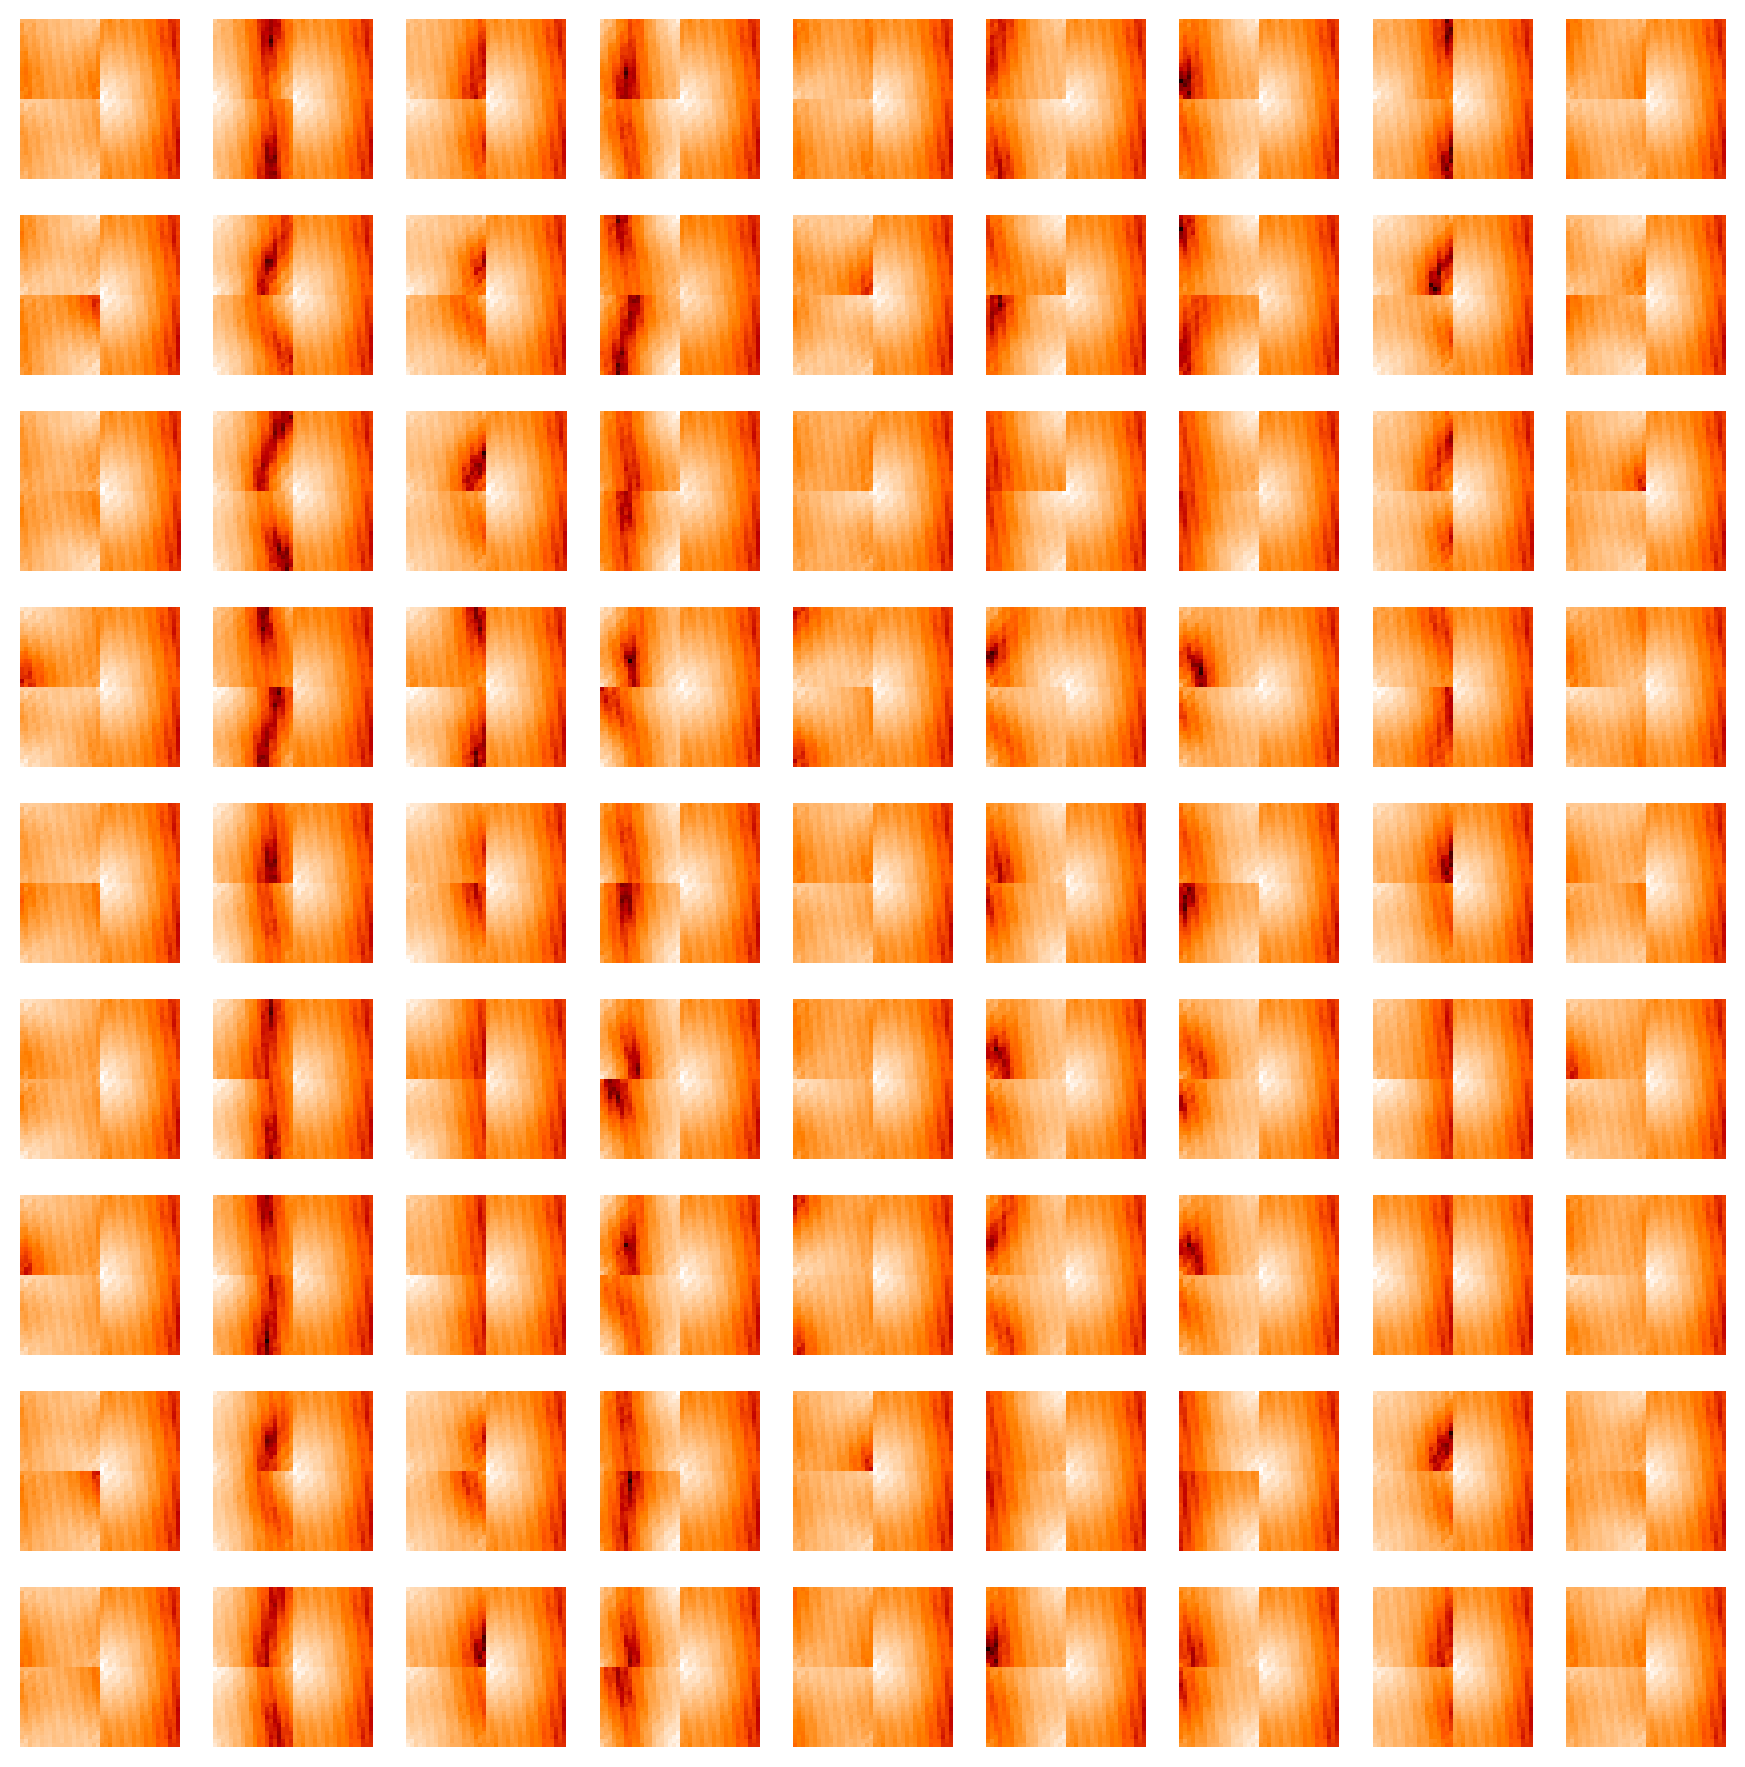

In [3574]:


# for i in range(len(large_atlas)): 

sel = [(0.667+1.155j), (0.667-1.155j), 1.333]

FF = []
coeffss = []
for j1, j2, j3, j4 in list(product(*([[(0.667+1.155j), (0.667-1.155j), 1.333]]*4))):
    print(j1, j2, j3, j4)
    coeffss.append([j1, j2, j3, j4])

    i = 0

    F_hat_test = np.zeros(large_atlas[0].shape, dtype=np.complex128)
    large_data = large_atlas[i]
    # plt.imshow(large_data)
    # plt.colorbar()
    # plt.show()
    large_data_hat = fft.fft2(large_data)
    dx = -centroids[i, 0]*factor
    dy = -centroids[i, 1]*factor
    print(dx, dy)
    large_data_hat = large_data_hat*np.exp(-2*np.pi*1j*(X*dx+Y*dy))
    large_data_hat[:nx//2, :nx//2] = large_data_hat[:nx//2, :nx//2]*coeffs4[0, i]
    large_data_hat[:nx//2, nx//2:] = large_data_hat[:nx//2, nx//2:]*j1
    large_data_hat[nx//2:, :nx//2] = large_data_hat[nx//2:, :nx//2]*coeffs4[0, i]
    large_data_hat[nx//2:, nx//2:] = large_data_hat[nx//2:, nx//2:]*j1
    F_hat_test += large_data_hat

    pow = get_power_spectrum(F_hat_test)

    # plt.imshow(np.log(pow+1), vmin=0)
    # plt.imshow(F_hat_test.real, vmin=0)
    # plt.colorbar()
    # plt.show()

    i += 1


    large_data = large_atlas[i]
    # plt.imshow(large_data)
    # plt.colorbar()
    # plt.show()
    large_data_hat = fft.fft2(large_data)
    dx = -centroids[i, 0]*factor
    dy = -centroids[i, 1]*factor
    print(dx, dy)
    large_data_hat = large_data_hat*np.exp(-2*np.pi*1j*(X*dx+Y*dy))
    large_data_hat[:nx//2, :nx//2] = large_data_hat[:nx//2, :nx//2]*coeffs4[3, i]
    large_data_hat[:nx//2, nx//2:] = large_data_hat[:nx//2, nx//2:]*j2
    large_data_hat[nx//2:, :nx//2] = large_data_hat[nx//2:, :nx//2]*coeffs4[3, i]
    large_data_hat[nx//2:, nx//2:] = large_data_hat[nx//2:, nx//2:]*j2
    F_hat_test += large_data_hat

    pow = get_power_spectrum(F_hat_test)

    # plt.imshow(np.log(pow+1), vmin=0)
    # plt.imshow(F_hat_test.real, vmin=0)
    # plt.colorbar()
    # plt.show()

    i += 1


    large_data = large_atlas[i]
    # plt.imshow(large_data)
    # plt.colorbar()
    # plt.show()
    large_data_hat = fft.fft2(large_data)
    dx = -centroids[i, 0]*factor
    dy = -centroids[i, 1]*factor
    print(dx, dy)
    large_data_hat = large_data_hat*np.exp(-2*np.pi*1j*(X*dx+Y*dy))
    large_data_hat[:nx//2, :nx//2] = large_data_hat[:nx//2, :nx//2]*coeffs4[2, i]
    large_data_hat[:nx//2, nx//2:] = large_data_hat[:nx//2, nx//2:]*j3
    large_data_hat[nx//2:, :nx//2] = large_data_hat[nx//2:, :nx//2]*coeffs4[2, i]
    large_data_hat[nx//2:, nx//2:] = large_data_hat[nx//2:, nx//2:]*j3
    F_hat_test += large_data_hat

    pow = get_power_spectrum(F_hat_test)

    # plt.imshow(np.log(pow+1), vmin=0)
    # plt.colorbar()
    # plt.show()

    i += 1


    large_data = large_atlas[i]
    # plt.imshow(large_data)
    # plt.colorbar()
    # plt.show()
    large_data_hat = fft.fft2(large_data)
    dx = -centroids[i, 0]*factor
    dy = -centroids[i, 1]*factor
    print(dx, dy)
    large_data_hat = large_data_hat*np.exp(-2*np.pi*1j*(X*dx+Y*dy))
    large_data_hat[:nx//2, :nx//2] = large_data_hat[:nx//2, :nx//2]*coeffs4[1, i]
    large_data_hat[:nx//2, nx//2:] = large_data_hat[:nx//2, nx//2:]*j4
    large_data_hat[nx//2:, :nx//2] = large_data_hat[nx//2:, :nx//2]*coeffs4[1, i]
    large_data_hat[nx//2:, nx//2:] = large_data_hat[nx//2:, nx//2:]*j4
    F_hat_test += large_data_hat

    pow = get_power_spectrum(F_hat_test)

    # plt.imshow(np.log(pow+1), vmin=0)
    # plt.colorbar()
    # plt.show()

    i += 1

    FF.append(F_hat_test)

fig, axs = plt.subplots(9, 9, figsize=[9, 9])
axs = axs.flat

for i in range(81):
    pow = get_power_spectrum(FF[i])
    axs[i].imshow(np.log(pow+1), vmin=0)
    axs[i].axis('off')
plt.tight_layout()

In [3570]:
coeffss[5]

[(0.667+1.155j), (0.667+1.155j), (0.667-1.155j), 1.333]

In [3573]:
coeffs4[0, i]

IndexError: index 80 is out of bounds for axis 1 with size 4

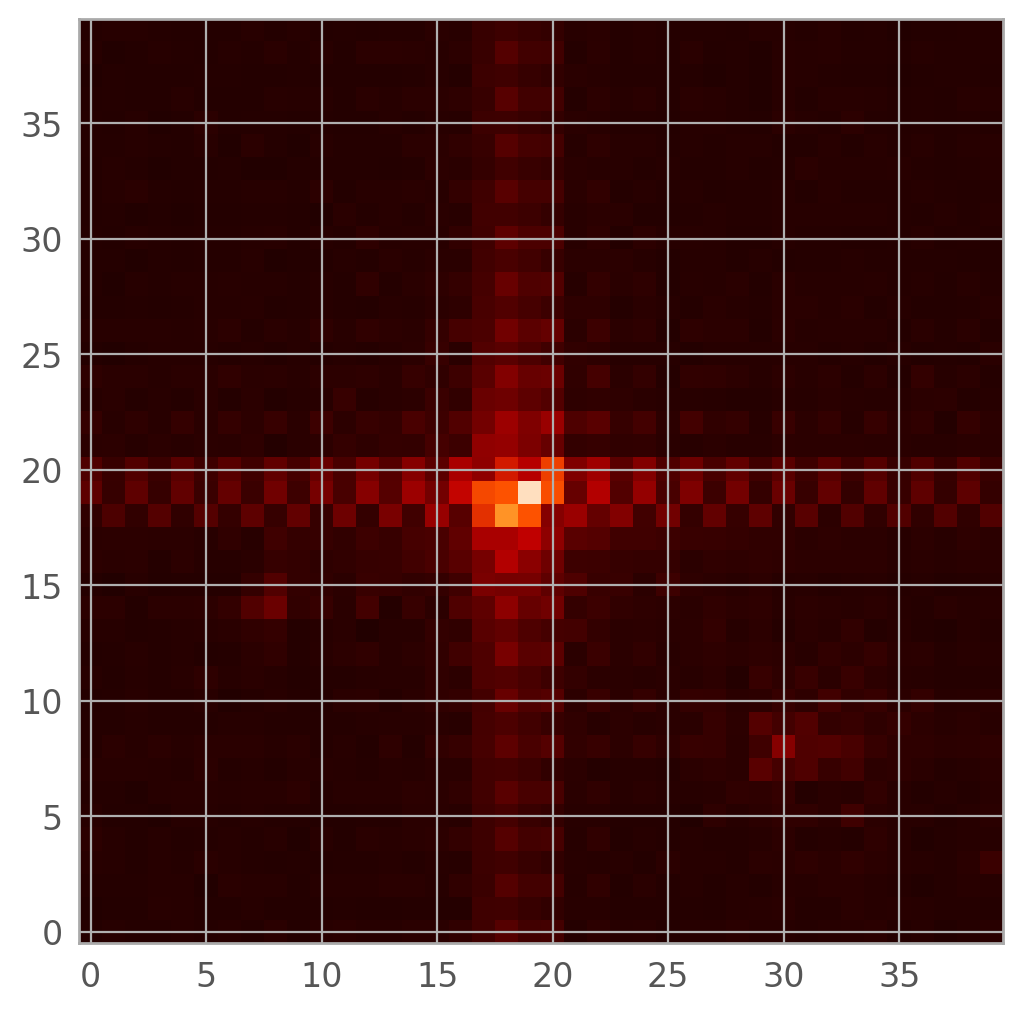

In [3035]:
plt.imshow(np.arcsinh(norm(fft.ifft2(F_hat_test))), vmin=-0.5, vmax=5)

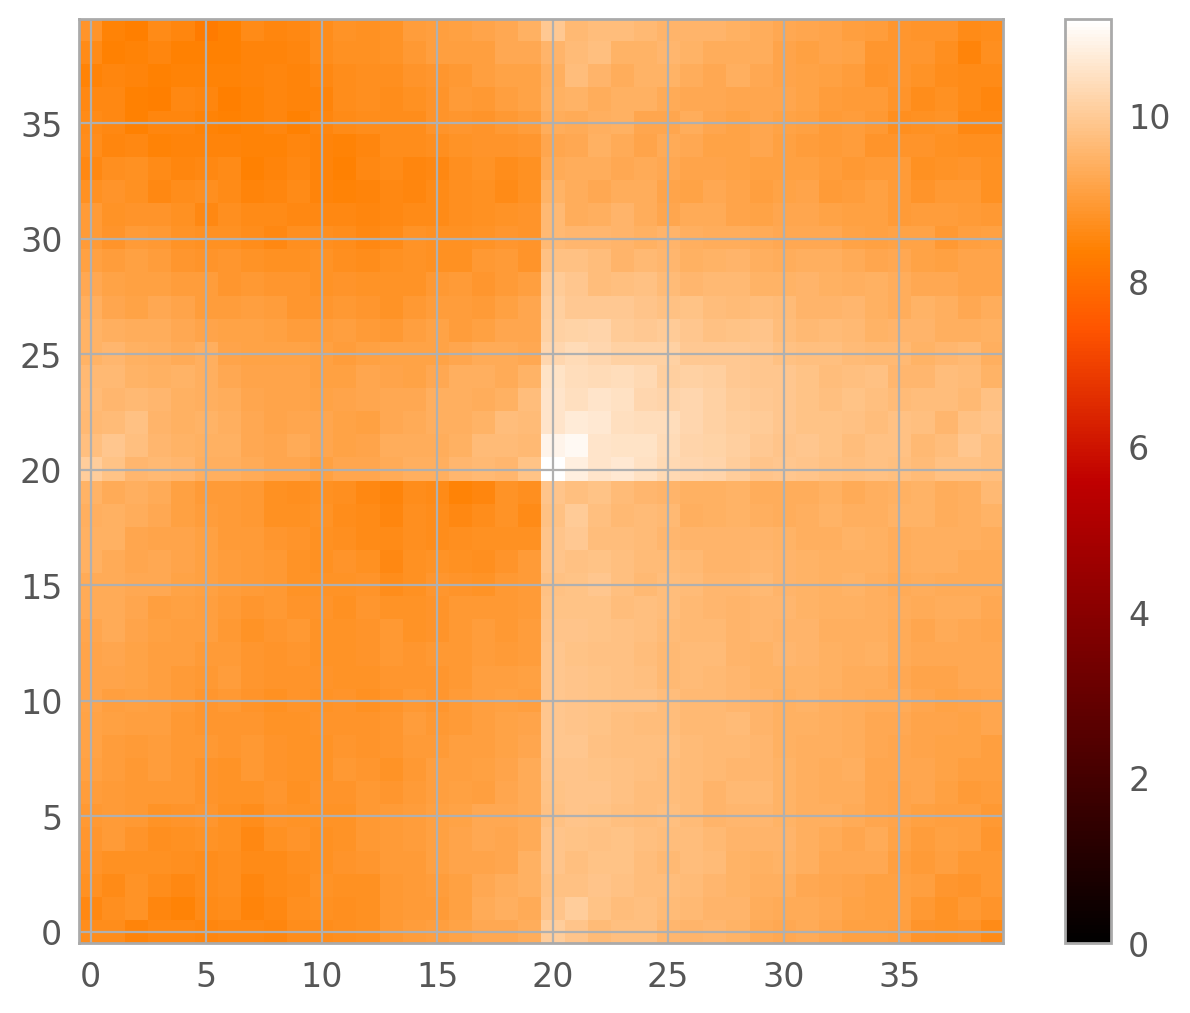

In [3438]:
F_hat = np.zeros(D_hat[0].shape, dtype=np.complex128)

i = 0
F_hat += coeffs[0]*D_hat[0]
F_hat += coeffs[1]*D_hat[1]
F_hat += coeffs[2]*D_hat[2]
F_hat += coeffs[3]*D_hat[3]

# F_hat += 0.66*np.exp(-2*np.pi*(0/12)*1j)*D_hat[0]

# F_hat += 1.33*np.exp(-2*np.pi*(2/12)*1j)*D_hat[1]

# F_hat += 1.33*np.exp(-2*np.pi*(2/12)*1j)*D_hat[3]

# F_hat += 0.66*np.exp(-2*np.pi*(4/12)*1j)*D_hat[4]



pow = get_power_spectrum(F_hat)

plt.imshow(np.log(pow+1), vmin=0)
plt.colorbar()

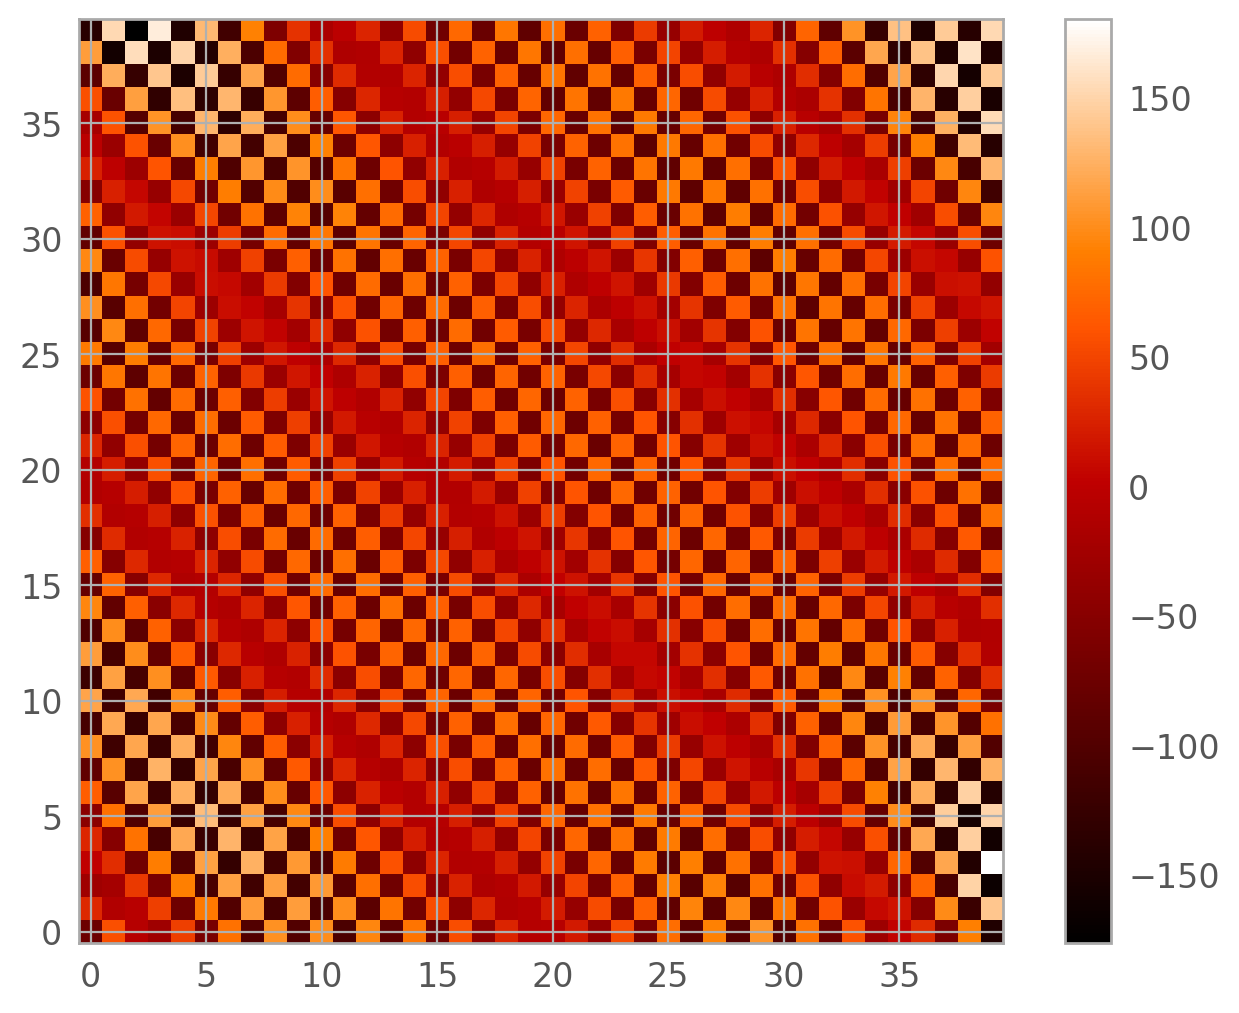

In [2377]:
plt.imshow((F_hat).imag)
plt.colorbar()

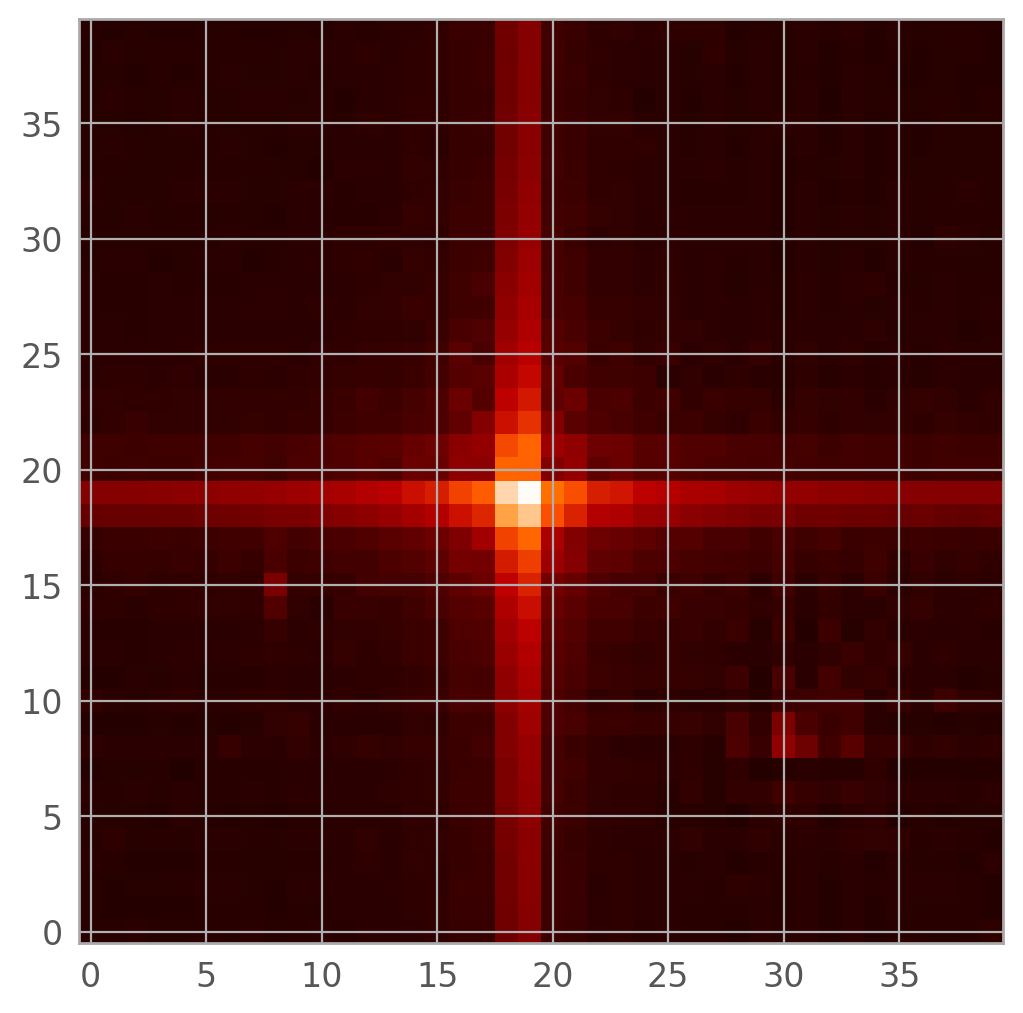

In [2338]:
# plt.imshow(stretch(norm(fft.ifft2(F_hat - np.min(F_hat)))))


plt.imshow(np.arcsinh(F), vmin=-0.5, vmax=5)

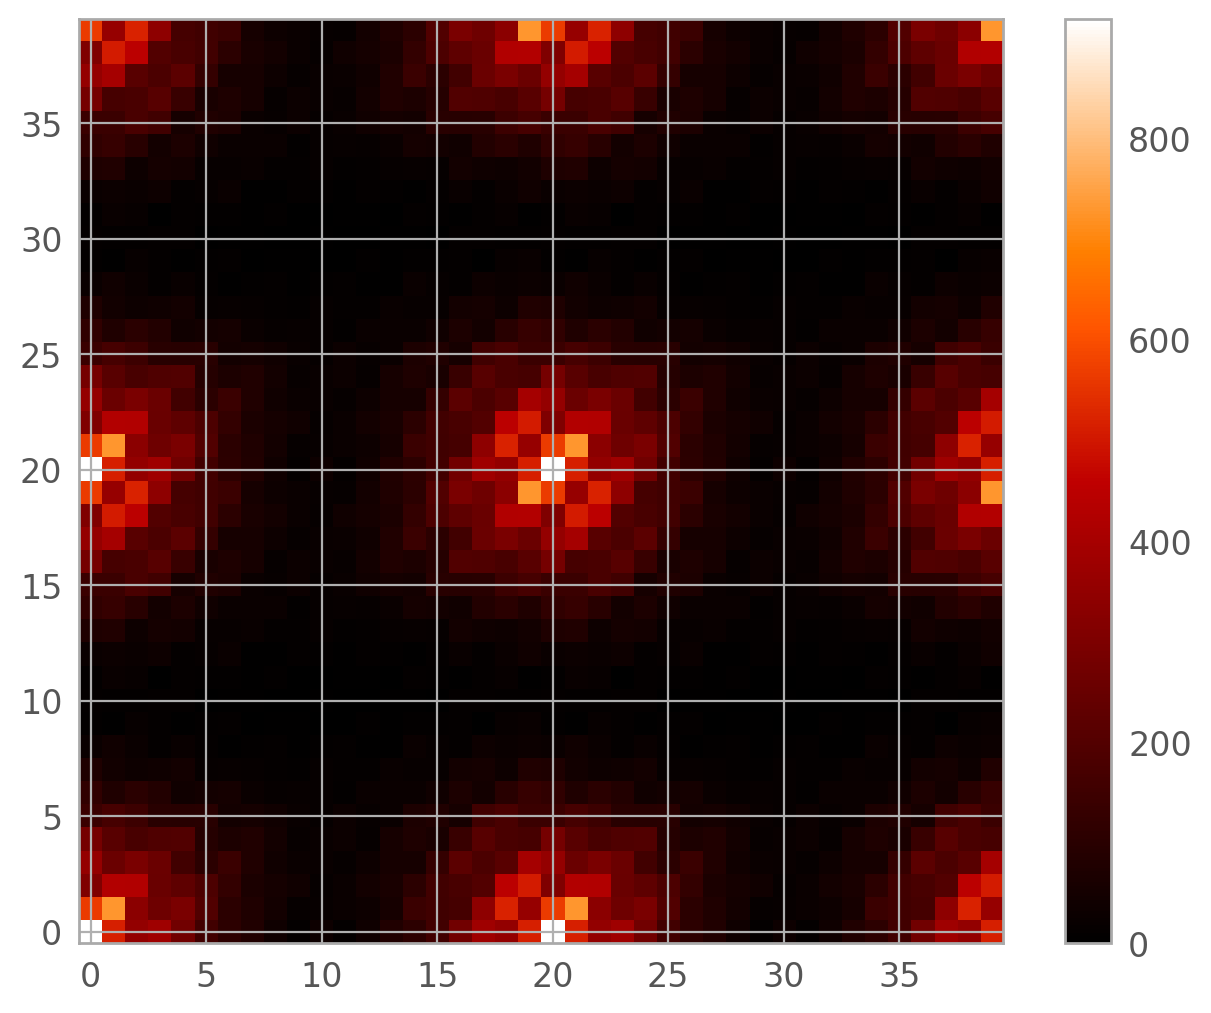

In [2339]:
D0 = (Phi_hat @ F_hat_flat)[0].reshape(40, 40)

pow = get_power_spectrum(D0)

plt.imshow(pow, vmin=0)
plt.colorbar()

In [2195]:
Phi_hat @ Phi_hat_inv

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.-0.j,  0.-0.j,  0.+0.j],
       [ 0.+0.j, -0.-0.j,  1.-0.j,  0.+0.j],
       [ 0.+0.j,  0.-0.j,  0.-0.j,  1.+0.j]])

In [2399]:
COEFS = np.array(COEFS).reshape(4, 2)
COEFS

array([[0.667+1.155j, 1.333-0.j   ],
       [1.333+0.j   , 0.667-1.155j],
       [1.333+0.j   , 0.667+1.155j],
       [0.667-1.155j, 1.333+0.j   ]])

In [2400]:
coefs = COEFS.copy()

TEST 1D

In [313]:
a = np.array([1, 0, 3, 0, 5, 0, 7, 0])
b = np.array([2, 0, 4, 0, 6, 0, 8, 0])
c = np.array([0, 1, 0, 3, 0, 5, 0, 7])
d = np.array([0, 2, 0, 4, 0, 6, 0, 8])

a_hat = fft.fft(a)
b_hat = fft.fft(b)
c_hat = fft.fft(c)
d_hat = fft.fft(d)

f = np.array([1, 2, 3, 4, 5, 6, 7, 8])
f_hat = fft.fft(f)

In [347]:
# D0_hat = np.concatenate([f_hat[4:]+f_hat[:4], f_hat[4:]+f_hat[:4]])/2

# fft.ifft(D0_hat).real

array([ 6.,  0.,  8.,  0., 10.,  0., 12.,  0.])

In [345]:
# x0 = 1

# Dx0_hat = np.concatenate([f_hat[:4]+np.roll(f_hat, 4)[4:]*np.exp(np.pi*1j*x0), f_hat[:4]+np.roll(f_hat, 4)[4:]*np.exp(-np.pi*1j*x0)])/2

# fft.ifft(Dx0_hat).real

array([ 0.00000000e+00,  2.43882596e-17, -2.77555756e-17,  5.41163633e-17,
        5.55111512e-17,  1.42145194e-16, -2.77555756e-17, -2.20649817e-16])

In [495]:
D0_hat = (f_hat+np.roll(f_hat, 4))/2

norm(fft.ifft(D0_hat))

array([1., 0., 3., 0., 5., 0., 7., 0.])

In [497]:
x0 = 1/2

Dx0_hat = (f_hat+np.roll(f_hat, 4)*np.exp(np.pi*1j*x0))/2

norm(fft.ifft(Dx0_hat))

array([0.70710678, 1.41421356, 2.12132034, 2.82842712, 3.53553391,
       4.24264069, 4.94974747, 5.65685425])

In [492]:
def norm(i): return np.sqrt(i.real**2 + i.imag**2)

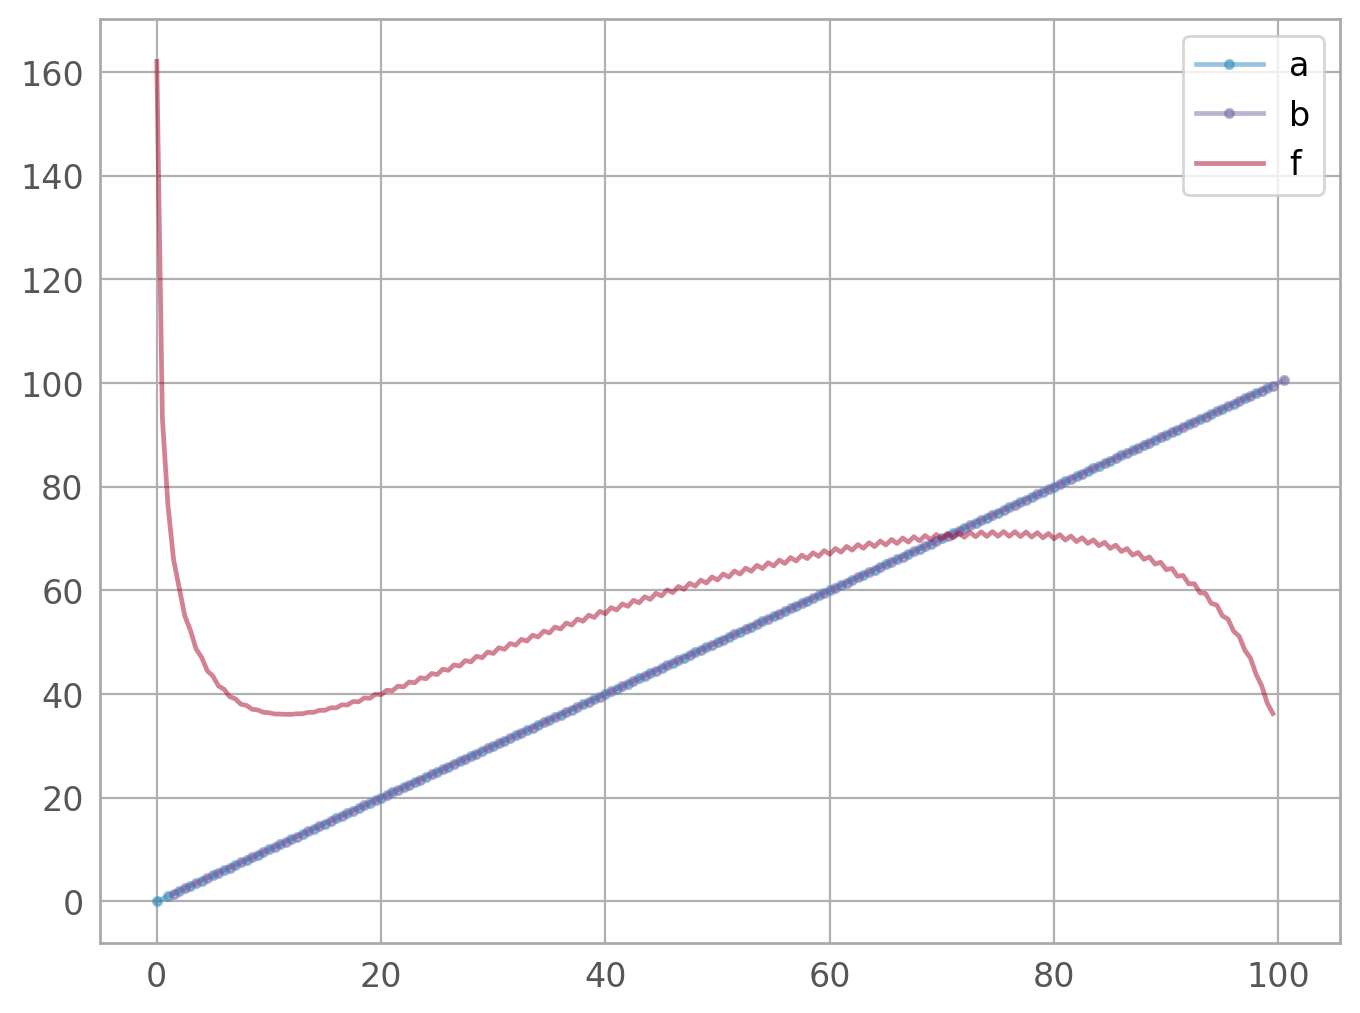

In [935]:
f = np.arange(100)

x0 = 1.5 # enlarged scale

# a = np.array([1, 0, 3, 0, 5, 0, 7, 0, 9, 0, 11, 0])
# b = np.array([2, 0, 4, 0, 6, 0, 8, 0, 10, 0, 12, 0]) + 0.1 # 3/4 shift
a = np.zeros(200)
a[::2] = f
b = np.zeros(200)
b[::2] = f + x0

a_hat = fft.fft(a)
b_hat = fft.fft(b)

X = np.arange(200)/200 # phase does not matter i.e. 1, 2, 3... === 0, 1, 2...

b_hat_shifted = b_hat*np.exp(-2*np.pi*1j*X*x0)

# # x0=1 simplified
# F_hat = a_hat + b_hat_shifted

# general case
F_hat = 2*(b_hat_shifted - np.exp(-np.pi*1j*x0)*a_hat)/(1 - np.exp(-np.pi*1j*x0))

# norm(fft.ifft(F_hat))

plt.plot(np.arange(100), a[::2], label='a', alpha=0.5, marker='.')
plt.plot(np.arange(100)+x0, b[::2], label='b', alpha=0.5, marker='.')
plt.plot(np.arange(0, 100, 0.5), norm(fft.ifft(F_hat)), label='f', alpha=0.5)
plt.legend()

plt.show()

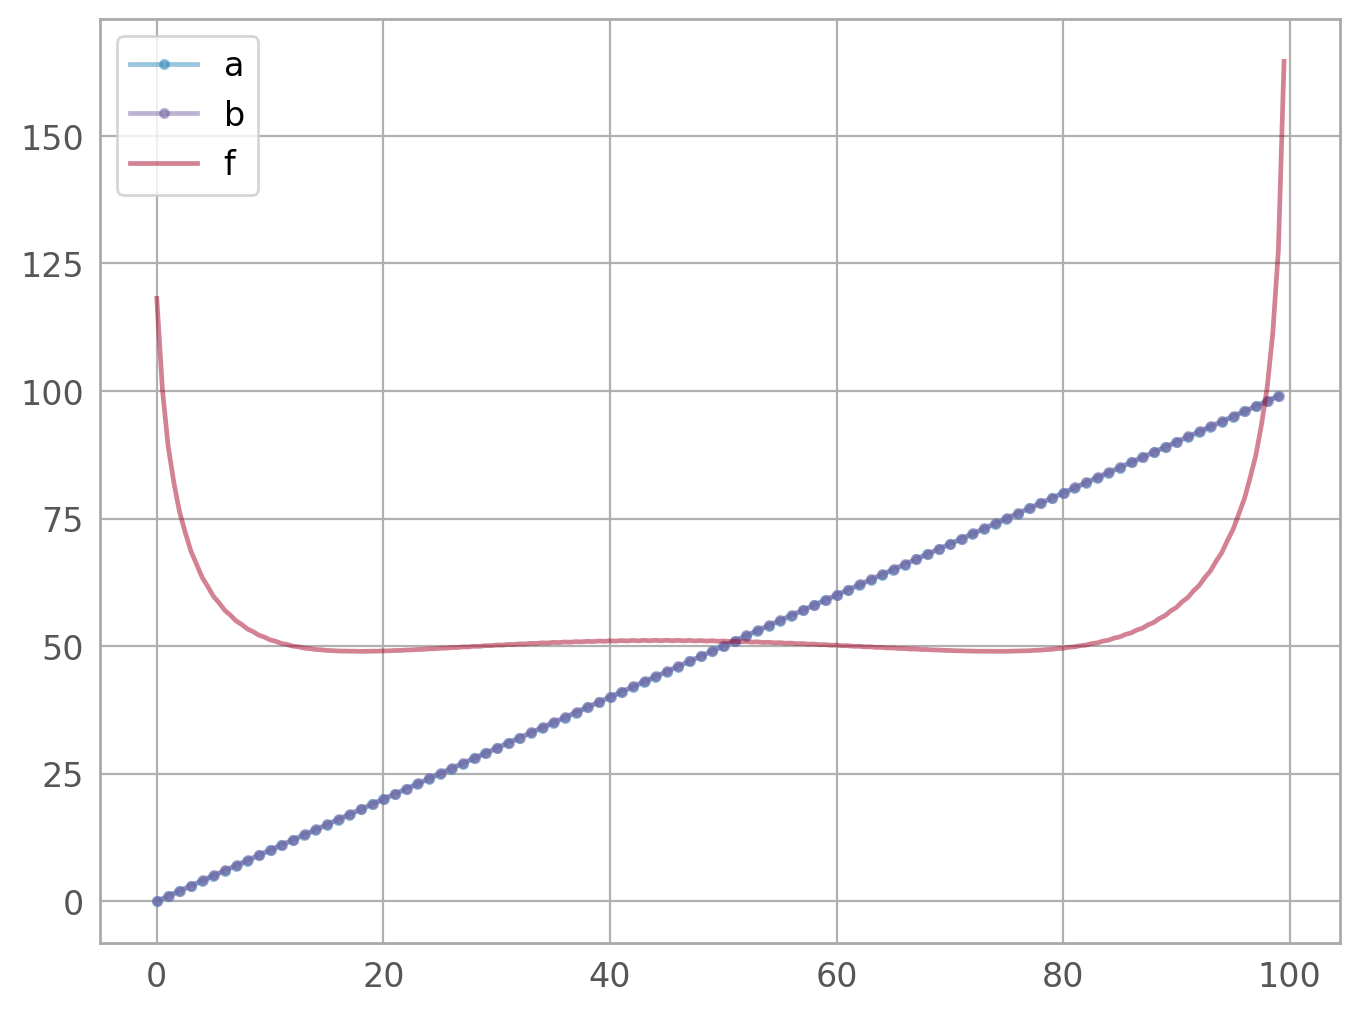

In [914]:
plt.plot(np.arange(100), a[::2], label='a', alpha=0.5, marker='.')
plt.plot(np.arange(100)+x0/2, b[::2], label='b', alpha=0.5, marker='.')
plt.plot(np.arange(0, 100, 0.5), norm(fft.ifft(F_hat)), label='f', alpha=0.5)
plt.legend()

plt.show()

TEST 1D 3x dither

In [663]:
a = np.array([1, 0, 0, 4, 0, 0, 7, 0, 0, 10, 0, 0])
b = np.array([2, 0, 0, 5, 0, 0, 8, 0, 0, 11, 0, 0])
c = np.array([3, 0, 0, 6, 0, 0, 9, 0, 0, 12, 0, 0])
# c = np.zeros(12)

a_hat = fft.fft(a)
b_hat = fft.fft(b)
c_hat = fft.fft(c)

x0 = 1
x1 = 2

X = np.arange(12)/12

# b_hat_shifted = b_hat*np.exp(2*np.pi*1j*X*x0)
b_hat_shifted = b_hat*np.exp(-2*np.pi*1j*X*x0)
c_hat_shifted = c_hat*np.exp(-2*np.pi*1j*X*x1)
# print(norm(fft.ifft(b_hat_shifted)))

# x0=1 simplified
F_hat = a_hat + b_hat_shifted + c_hat_shifted

# # general case
# F_hat = 2*(b_hat_shifted - np.exp(-np.pi*1j*x0)*a_hat)/(1 - np.exp(-np.pi*1j*x0))

norm(fft.ifft(F_hat))


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

Translated from Lauer (2015) Fortran77 code

Line-by-line translation of Tod's code without implementing assertations, offset fileio, and diagonal dither

In [2394]:
PI = np.pi
RADIOAN = PI/180
NSTMAX = 140
NDIV = 3

COEFS = []

[[0.  0.  1. ]
 [0.  0.5 1. ]
 [0.5 0.  1. ]
 [0.5 0.5 1. ]]
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
f

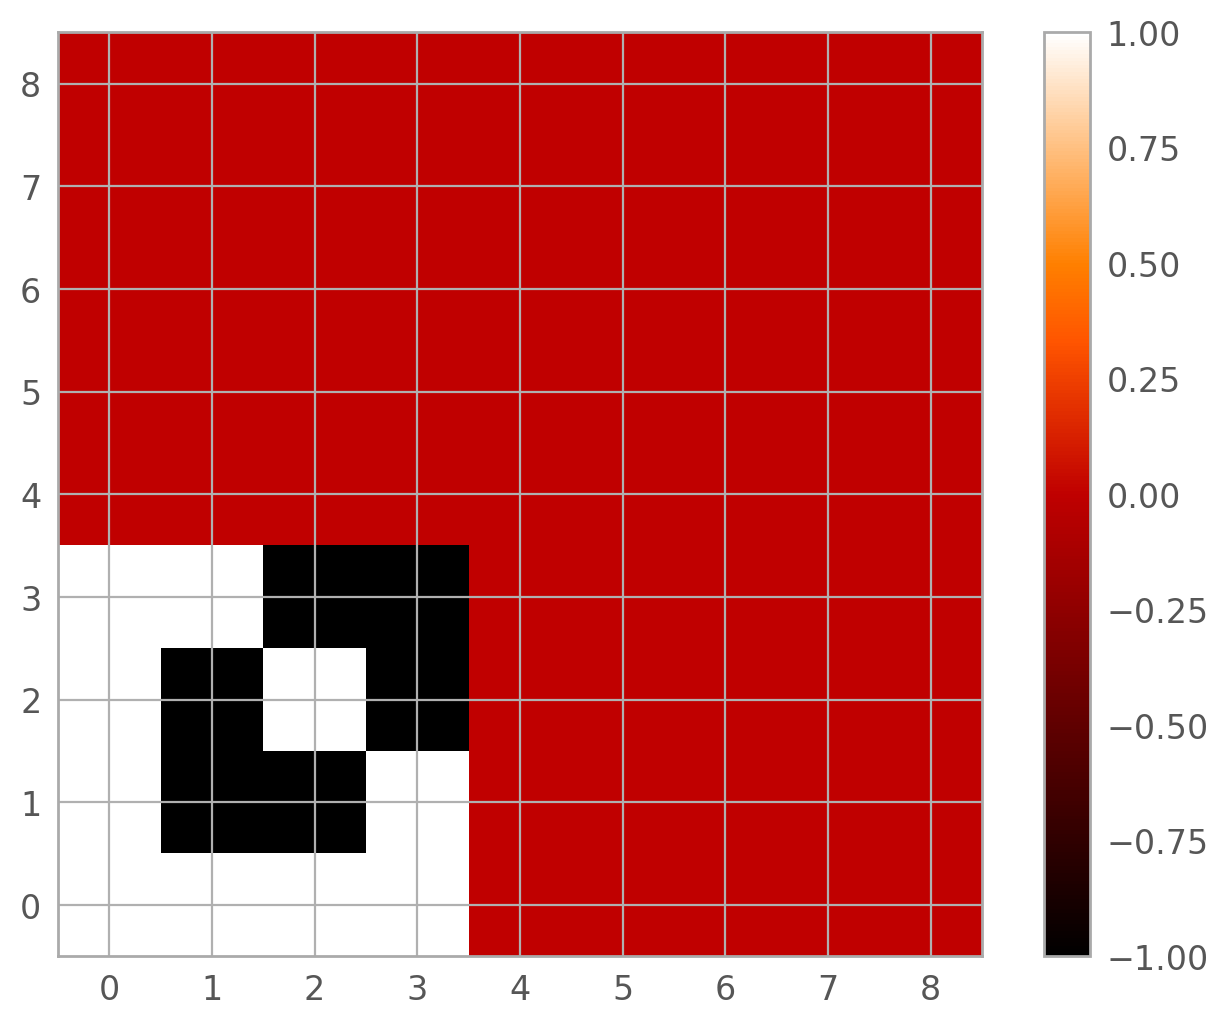

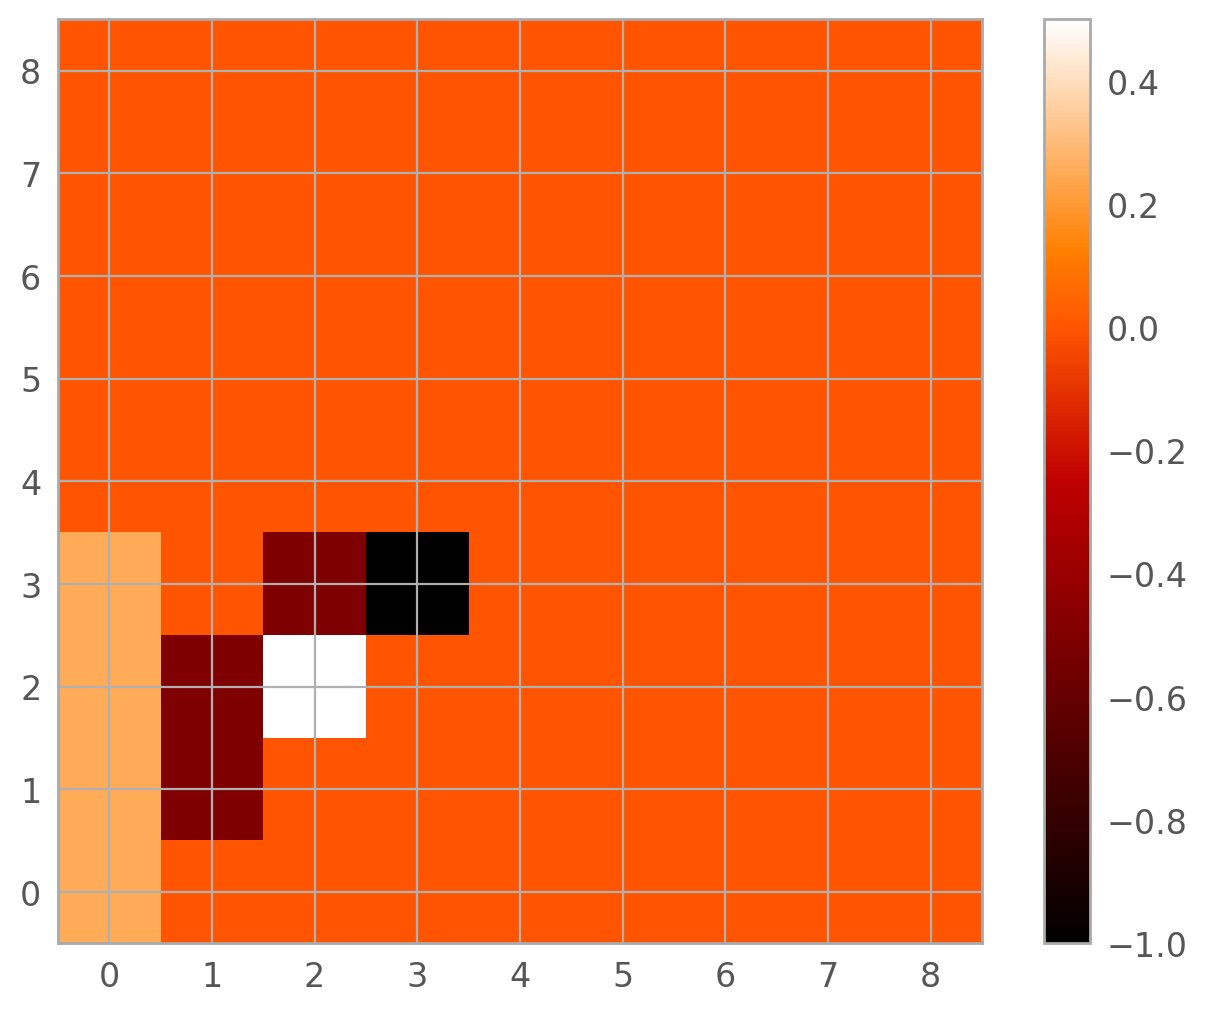

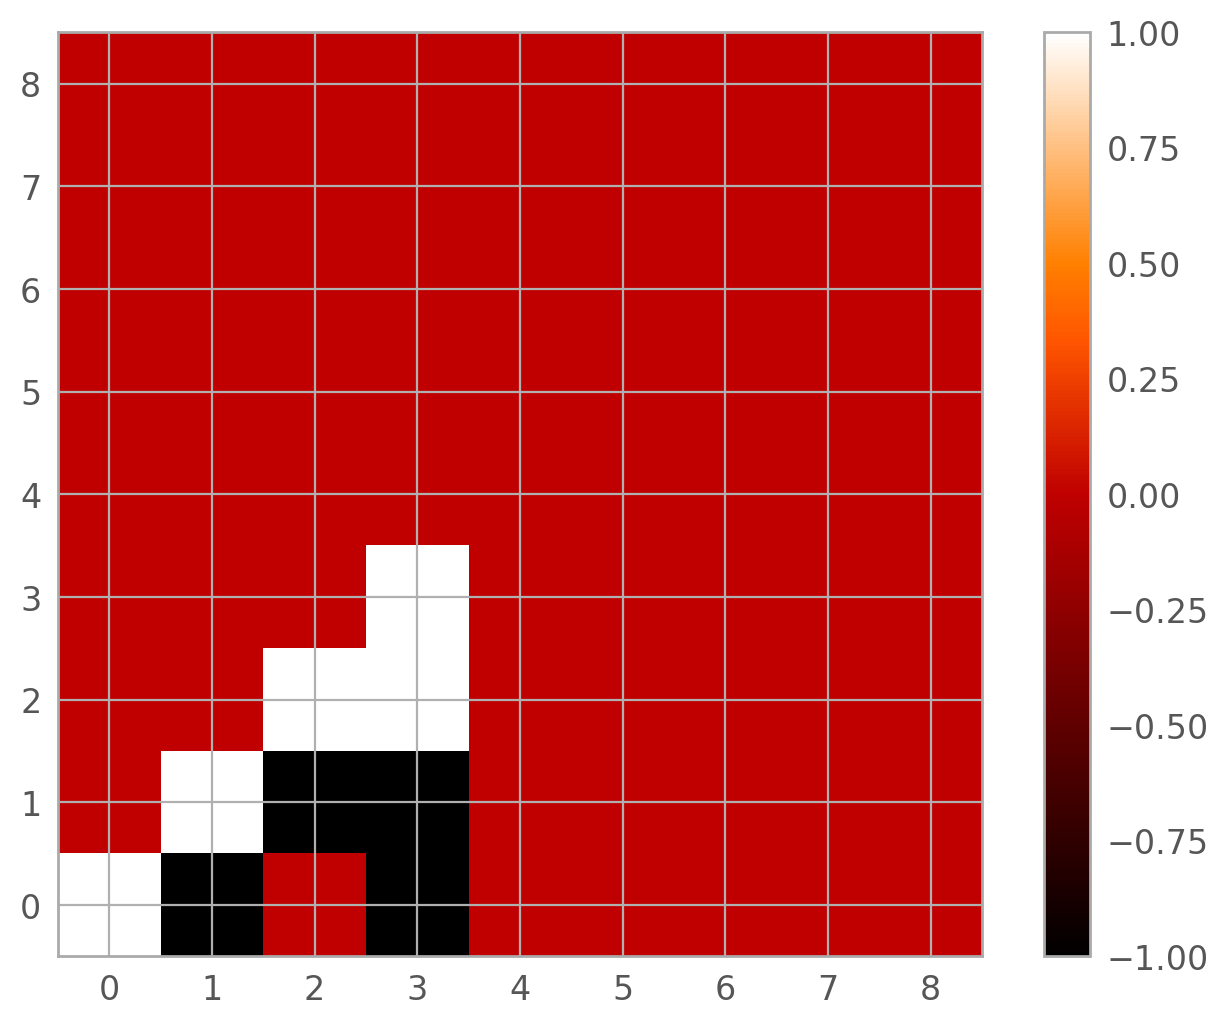

four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
four1 120 60
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 29
four1 60 29
realft 60 

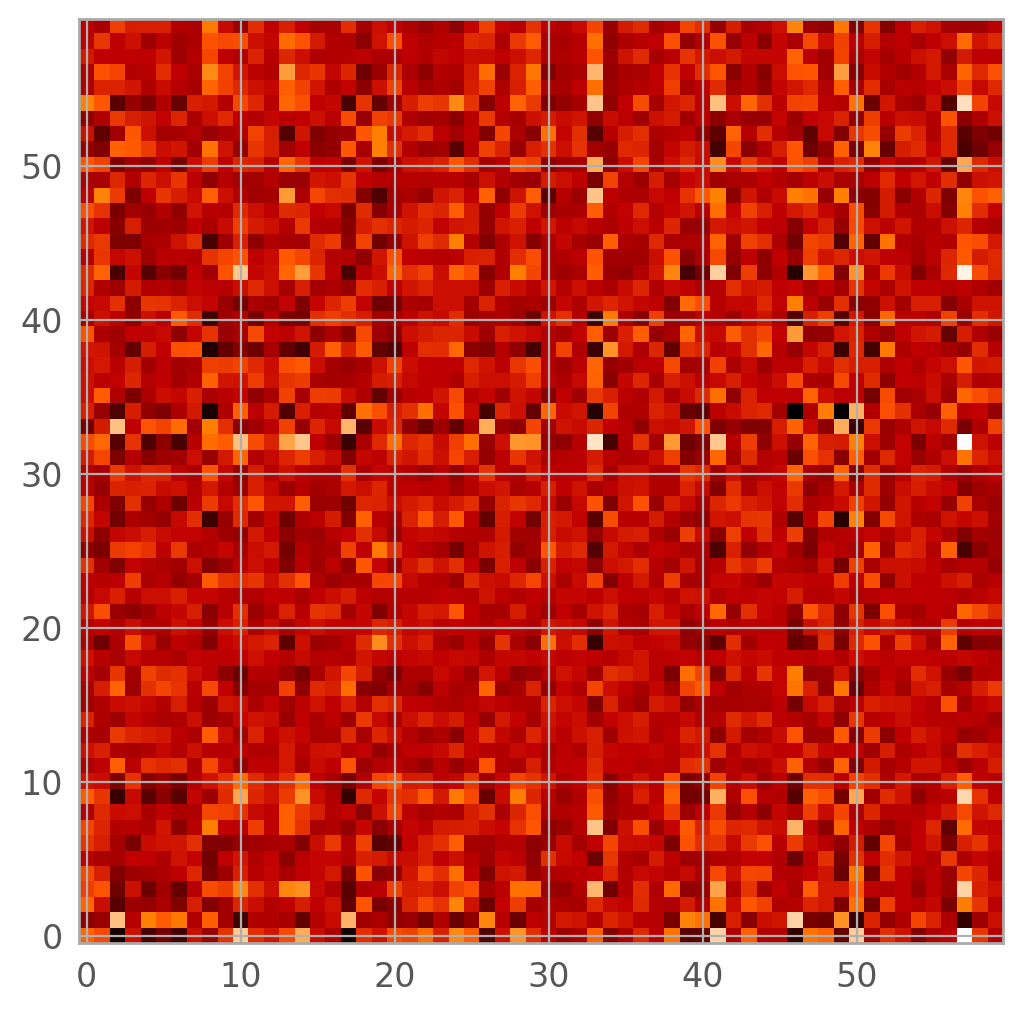

In [3396]:
def comptoreal(d_hat): 
    ncol, nrow = d_hat.shape
    A = np.zeros((ncol*2, nrow))
    for col in range(ncol): 
        A[2*col, :] = d_hat.real[col, :]
        A[2*col+1, :] = d_hat.imag[col, :]
    return A

def realtocomp(A): 
    ncol2, nrow = A.shape
    ncol = ncol2//2
    d_hat = np.zeros((ncol, nrow), dtype = np.complex128)
    for col in range(ncol): 
        d_hat.real[col, :] = A[2*col, :]
        d_hat.imag[col, :] = A[2*col+1, :]
    return d_hat

def phase(A_in, nrow, ncol, shift, DR, DC, offsets, npos):
    # TODO: check if they are all in use
    A = A_in.copy()
    phix = np.zeros(NSTMAX)
    # spr, spi, rpr, rpi, cpr, cpi, ypr, ypi, tpr, tpi = 0
    # fr, fi = 0
    phasem = np.zeros((NDIV**2, NDIV**2), dtype=np.complex128)
    vec = np.zeros((NDIV**2, NDIV**2), dtype=np.complex128)
    coef = np.zeros((NDIV**2), dtype=np.complex128)
    phases = np.zeros((NDIV**2, NSTMAX), dtype=np.complex128)
    # row, col, vrow = 0
    key = np.zeros(NDIV**2)

    # LINE 165
    
    if shift: 
        for row in range(1, nrow+1): 
            # U = 0
            if row<=nrow//2: 
                U = row/nrow
            else: 
                U = (row - nrow - 1)/nrow
            rphase = 2*PI*DR*U
            rpr = np.cos(rphase)
            rpi = np.sin(rphase)
            for col in range(1, ncol+1, 2):
                V = (col - 1)/ncol/2
                cphase = 2*PI*DC*V
                cpr = np.cos(cphase)
                cpi = np.sin(cphase)
                fr = A[col-2, row-1]
                fi = A[col+1-2, row-1]
                tpr = rpr*cpr - rpi*cpi
                tpi = rpi*cpr + rpr*cpi
                # print(tpr, tpi)
                # print(rphase, cphase, row)
                A[col-2, row-1] = fr*tpr - fi*tpi
                A[col+1-2, row-1] = fi*tpr + fr*tpi
                # print(A[col, row] - A_in[col, row])
                # print(A[col+1, row] - A_in[col+1, row])
        return A
    
    # LINE 247 - read offsets (totally different from the original code)

    offsets = np.array(offsets)
    ycr = offsets[0, 1]
    xcr = offsets[0, 0]
    dy = offsets[:, 1] - ycr
    dx = offsets[:, 0] - xcr
    phiy = NSUB*PI*dy
    phix = NSUB*PI*dx
    wt = offsets[:, 2]
    npp = len(offsets)

    # LINE 289 - Calculate the coefficients for each image. 

    nsy = NSUB # 2
    nsx = (NSUB - 1)//2 + 1 # 1
    isy = -((NSUB-1)//2) + 1 # 0, NOTE: added a bracket to regulate different handling of integer division
    isy = 0
    isec = 0

    for iy in range(isy, isy+nsy): 
        for ix in range(0, nsx): 

            isec += 1

            # LINE 304

            for nim in range(1, npp+1):
                px = -phix[nim-1]*2/NSUB
                py = -phiy[nim-1]*2/NSUB
                nuin = ix - (NSUB - 1)//2
                nvin = iy
                pxi = nuin*px
                pyi = -nvin*py
                # print('pxi', pxi, 'pyi', pyi)

                isat = 0
                for isaty in range(0, NSUB):
                    for isatx in range(0, NSUB): 
                        isat += 1
                        phit = isatx*px + pxi + isaty*py + pyi
                        # print(isat-1, nim-1, phit)
                        phases[isat-1, nim-1] = (np.cos(phit) + np.sin(phit)*1j)/NSUB**2
                    #     break
                    # break

                # LINE 344 - Pivot if required so that the fundamental is always in column 1

                nfund = 1 + NSUB*nvin - nuin
                print('Fundamental', nfund)
                temp = phases[0, nim-1]
                # print(nfund, nim, nvin, nuin)
                phases[0, nim-1] = phases[nfund-1, nim-1]
                phases[nfund-1, nim-1] = temp

            # print(iy, ix, phases[:4, :4].real)
            # vec[:4, :4] = la.inv(phases[:4, :4])
            # print(vec.shape, phases.shape)
            # plt.imshow(phases[:9, :9].real)

            # LINE 355 - This loads an identity matrix, which will be used to invert the phase matrix.
            
            for i in range(1, NSUB**2+1): 
                for j in range(1, NSUB**2+1):
                    vec[j-1, i-1] = 0+0j
                vec[i-1, i-1] = 1+0j
                key[i-1] = i
            
            # vec[:9, :9] = la.inv(phases[:9, :9])

            ### BEGIN MATRIX INVERSION

            # LINE 367 - If N>nsub2, then the problem is over determined

            # LINE 371 - The weighting factor is used at this point.

            if npp>NSUB**2: 
                print('npp>NSUB**2')
                for i in range(1, NSUB**2+1): 
                    for j in range(1, NSUB**2+1): 
                        phasem[j-1, i-1] = 0+0j
                        for k in range(1, npp+1): 
                            phasem[j-1, i-1] += np.conj(phases[i-1, k-1])*wt[k-1]*phases[j-1, k-1]
            else: 
                for i in range(1, NSUB**2+1): 
                    for j in range(1, NSUB**2+1): 
                        phasem[j-1, i-1] = phases[j-1, i-1]
            # print(phasem==0)
            # print(phasem.shape, phases.shape, vec.shape)

            # LINE 391 - solve for the data vector phases

            for i in range(1, NSUB**2): 
                for j in range(i+1, NSUB**2+1): 

                    # LINE 396 - Check for zero division and pivot if required.

                    # print(phasem)#, la.inv(phasem))
                    # print(i, phasem[i, i]*np.conj(phasem[i, i])==0)
                    if (phasem[i-1, i-1]*np.conj(phasem[i-1, i-1])==0): 
                        pivot = False
                        k = i+1
                        while (not pivot) and (k<=NSUB**2): 
                            if (phasem[i-1, k-1]*np.conj(phasem[i-1, k-1])!=0): 
                                
                                pivot = True
                                itemp = key[i-1]
                                key[i-1] = key[k-1]
                                key[k-1] = itemp
                                for kk in range(1, NSUB**2+1): 
                                    temp = phasem[kk-1, i-1]
                                    phasem[kk-1, i-1] = phasem[kk-1, k-1]
                                    phasem[kk-1, k-1] = temp
                                    temp = vec[kk-1, i-1]
                                    vec[kk-1, i-1] = vec[kk-1, k-1]
                                    vec[kk-1, k-1] = temp
                            else: 
                                k += 1

                        if not pivot: 
                            raise ValueError('singular phase matrix')
                    
                    # if phasem[i-1, i-1]==0: return

                    # LINE 436 - Any pivoting required is now completed
                    # print(i, j, 'phasem', phasem[i-1, i-1])
                    # print(phasem[:4, :4])
                    rat = phasem[i-1, j-1]/phasem[i-1, i-1]
                    for k in range(i, NSUB**2+1): 
                        phasem[k-1, j-1] -= rat*phasem[k-1, i-1]
                    for k in range(1, NSUB**2+1): 
                        vec[k-1, j-1] -= rat*vec[k-1, i-1]
                    # print(i, phasem[i, i])
                    # print(phasem)
                # return
            
            for i in range(NSUB**2, 1, -1):
                rat = phasem[i-1, i-1]
                for j in range(1, NSUB**2+1):
                    # print('rat', rat, i, phasem[i-1, i-1])
                    # print(phasem)
                    # print(phases[:4, :4]==0)
                    vec[j-1, i-1] /= rat
                for j in range(i-1, 0, -1):
                    rat = phasem[i-1, j-1]
                    for k in range(1, NSUB**2+1):
                        vec[k-1, j-1] -= rat*vec[k-1, i-1]
            for j in range(1, NSUB**2+1):
                vec[j-1, 0] /= phasem[0, 0]

            # LINE 467 - The vec array now holds the inverse of the original phasem array.

            ### END MATRIX INVERSION

            # LINE 469 - If any pivoting has been done, undo it.

            for i in range(1, NSUB**2+1):
                if key[i-1]!=i: 
                    k = i+1
                    # print(key)
                    while (key[k-1]!=i) and (k<NSUB**2): 
                        k += 1
                    for kk in range(1, NSUB**2+1):
                        temp = vec[kk-1, i-1]
                        vec[kk-1, i-1] = vec[kk-1, k-1]
                        vec[kk-1, k-1] = temp
                    key[k-1] = key[i-1]

            # # LINE 490 - For NSUB2 images, we are done
            
            if npp==NSUB**2:
                print('npp==NSUB**2')
                # print('coef', coef)
                # print('vec', vec[:, 0], npos-1)
                coef[isec-1] = vec[npos-1, 0]

            # LINE 495 - Otherwise, we need to do a little more work.  Here we just solve for the fundamental image.
            
            else: 
                coef[isec-1] = 0
                for i in range(1, NSUB**2+1):
                    coef[isec-1] += vec[i-1, 0]*np.conj(phases[i-1, npos-1])
            # print(isec, npos, coef[isec], coef)

            # LINE 505 - Addin weighting factor

            coef[isec-1] *= wt[npos-1]

            # print(f'Image {npos}, power {coef[isec-1]*np.conj(coef[isec-1])}, sector {isec}')
            print(f'Image {npos}, power {coef[isec-1]}, sector {isec}')
        #     break
        # break

    print('coef', coef)

    # LINE 516 - apply the complex scale factor to the transform

    isec = 0
    isv = nrow//2
    iev = isv - nrow//NSUB + 1 
    # print(A)
    # print('phix', phix)
    # print('phiy', phiy)
    # print(isv, iev)
    # print(nsy)
    # print(nsx)
    # print(isv-(iev-1))
    for iy in range(isy, isy+nsy):
        ieu = ncol - (NSUB - 1)*(nsx - 1)*ncol//NSUB
        # print(ieu) # TODO: verify that ieu==ncol if nsx = 1
        isu = 1
        for ix in range(0, nsx):
            isec += 1
            # print(isec, coef[isec-1])
            spr = coef[isec-1].real # NOTE Fortran casts Complex to Real directly
            spi = coef[isec-1].imag
            print('this coef', coef[isec-1])
            # COEFS.append(coef[isec-1])
            for vrow in range(isv, iev-1, -1): 
                # print('vrow', vrow, 'isv', isv, 'iev', iev)
                if vrow>0:
                    row = vrow
                else: 
                    row = nrow + vrow
                if row>nrow//2: 
                    V = (row - nrow - 1)/nrow
                else: 
                    V = (row - 1)/nrow
                rphase = -2*phiy[npos-1]*V
                # rphase = rphase/2-1
                # print(rphase)
                rpr = np.cos(rphase)
                rpi = np.sin(rphase)
                ypr = rpr*spr - rpi*spi
                ypi = rpi*spr + rpr*spi
                # print(rphase, rpr, rpi, spr, spi, ypr, ypi, rpr*spr)
                # print((ieu+1-isu)//2)
                for col in range(isu, ieu+1, 2):
                    # print(row, isv, iev, col, isu, ieu)
                    U = (col - 1)/(ncol - 2)/2
                    cphase = -2*phix[npos-1]*U
                    print(U, V)
                    # print(rphase, cphase, phiy[npos-1], phiy[npos-1])
                    # print(' ', cphase)
                    # print(rphase, cphase)
                    cpr = np.cos(cphase)
                    cpi = np.sin(cphase)
                    tpr = ypr*cpr - ypi*cpi
                    tpi = ypi*cpr + ypr*cpi
                    # print(vrow, row, col, isu, ieu+2)
                    fr = A[col-2, row-1]
                    fi = A[col+1-2, row-1]
                    # print('ypr', ypr, cpr, ypr*cpr, ypi, cpi, ypr*cpr - ypi*cpi, tpr,tpi)
                    # print()
                    A[col-2, row-1] = fr*tpr - fi*tpi
                    A[col+1-2, row-1] = fi*tpr + fr*tpi
            isu = ieu + 1
            ieu = ncol - (nsx - 2 - ix)*ncol//NSUB # TODO: check values
        isv = iev - 1
        iev = isv - nrow//NSUB + 1 # TODO: check values
        if iy==(isy + nsy - 2): 
            iev = -(nrow//2) + 1 # NOTE: add a bracket to change negative sign to minus sign

    print(vec)
    print(phasem)
    plt.imshow(vec.real)
    plt.colorbar()
    plt.show()
    plt.imshow(phasem.real)
    plt.colorbar()
    plt.show()
    plt.imshow((vec@phasem).real)
    plt.colorbar()
    plt.show()
    return A
    
### initialization, for indexing, +=1 position, -1 in every array index

# why coef changes




NSUB = 2

DR = 0.5
DC = 0.5
shift = False
# offsets dx dy wt
# offsets = np.array([[0, 0, 1], 
#                     [0, -1/3, 1], 
#                     [-1/3, 0, 1], 
#                     [-1/3, -1/3, 1]])
# offsets = [[0, 0, 1], 
#            [0, 1/3, 1], 
#            [0, 2/3, 1], 
#            [1/3, 0, 1], 
#            [1/3, 1/3, 1], 
#            [1/3, 2/3, 1], 
#            [2/3, 0, 1], 
#            [2/3, 1/3, 1], 
#            [2/3, 2/3, 1]]
offsets = np.array([
    [0, 0, 1], 
    [0, 0.5, 1], 
    [0.5, 0, 1], 
    [0.5, 0.5, 1],
])

offsets[:, 0] *= 1
offsets[:, 1] *= 1
print(offsets)



Atotal = np.zeros((30*NSUB, 30*NSUB))
for i in range(4): 
    data = test_atlas_2x[i]
    data_large = np.zeros(np.array(data.shape)*NSUB)
    data_large[::NSUB, ::NSUB] = data
    # data_hat = fft.fft2(data_large, axes=[-2, -1])
    # A = comptoreal(data_hat)
    b = data_large
    nrb, ncb = b.shape
    a = np.zeros((nrb, ncb))
    nra, nca = a.shape
    isign = 1
    work = np.zeros((2, nrb))
    A = real2dfft(a, nra, nca, b, nrb, ncb, isign, work, onedim=False)
    # plt.imshow(A)
    # plt.show()
    ncol, nrow = A.shape
    # n = i + 1
    n = 1
    # n=9 # starting from 1

    Atotal += phase(A, nrow, ncol, shift, DR, DC, offsets, n)


    # print(Atotal)
    break

b = Atotal
nrb, ncb = b.shape
a = np.zeros((nrb, ncb))
nra, nca = a.shape
isign = -1
work = np.zeros((2, nrb))
d = real2dfft(a, nra, nca, b, nrb, ncb, isign, work, onedim=False)
# d = fft.ifft2(d_hat, axes=[-2, -1])
# plt.imshow(stretch(norm(data_large)))
# plt.imshow(stretch(norm(d-data_large)))
# plt.imshow(stretch(norm(d)))
plt.imshow(d)
print(COEFS)

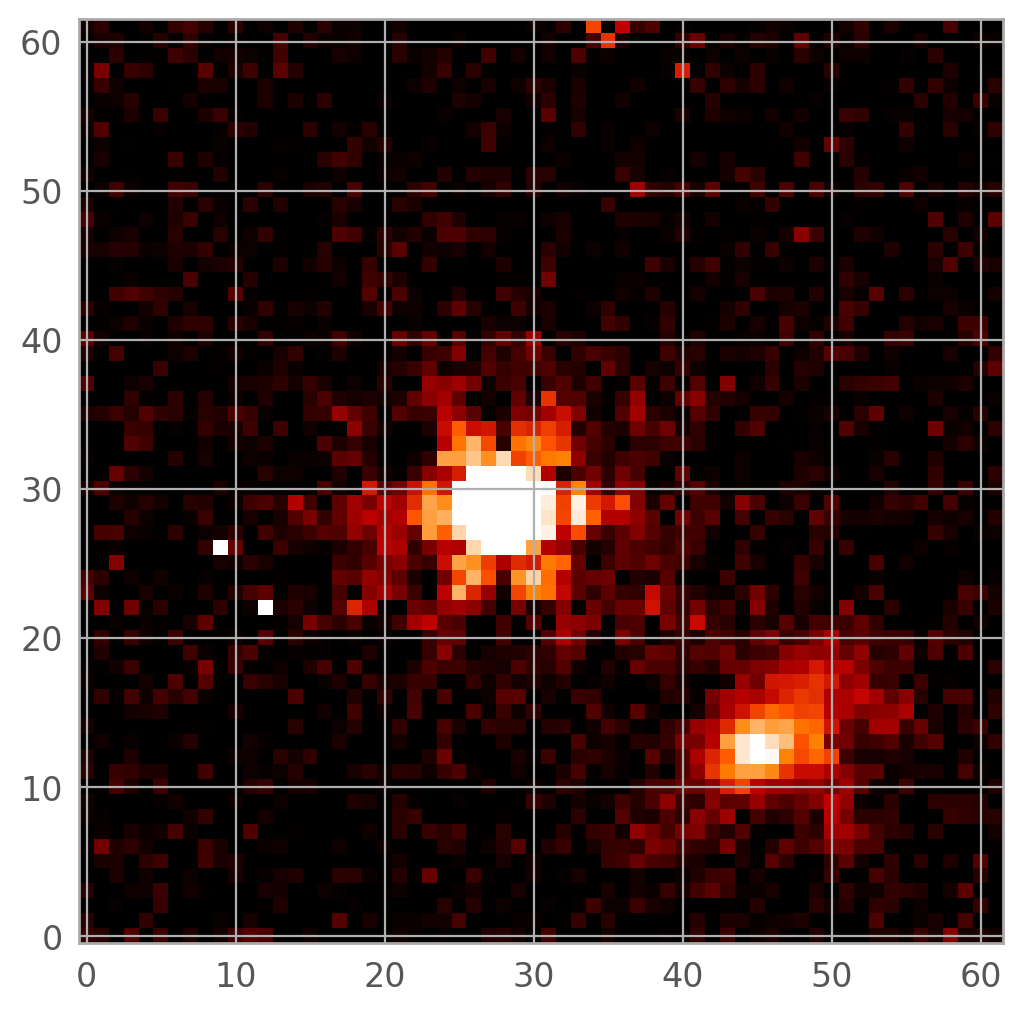

In [2878]:
plt.imshow(stretch(orig))

# plt.imshow(stretch(shift(orig, (1/3, 1/3))))


0 0
0 1
1 0
1 1


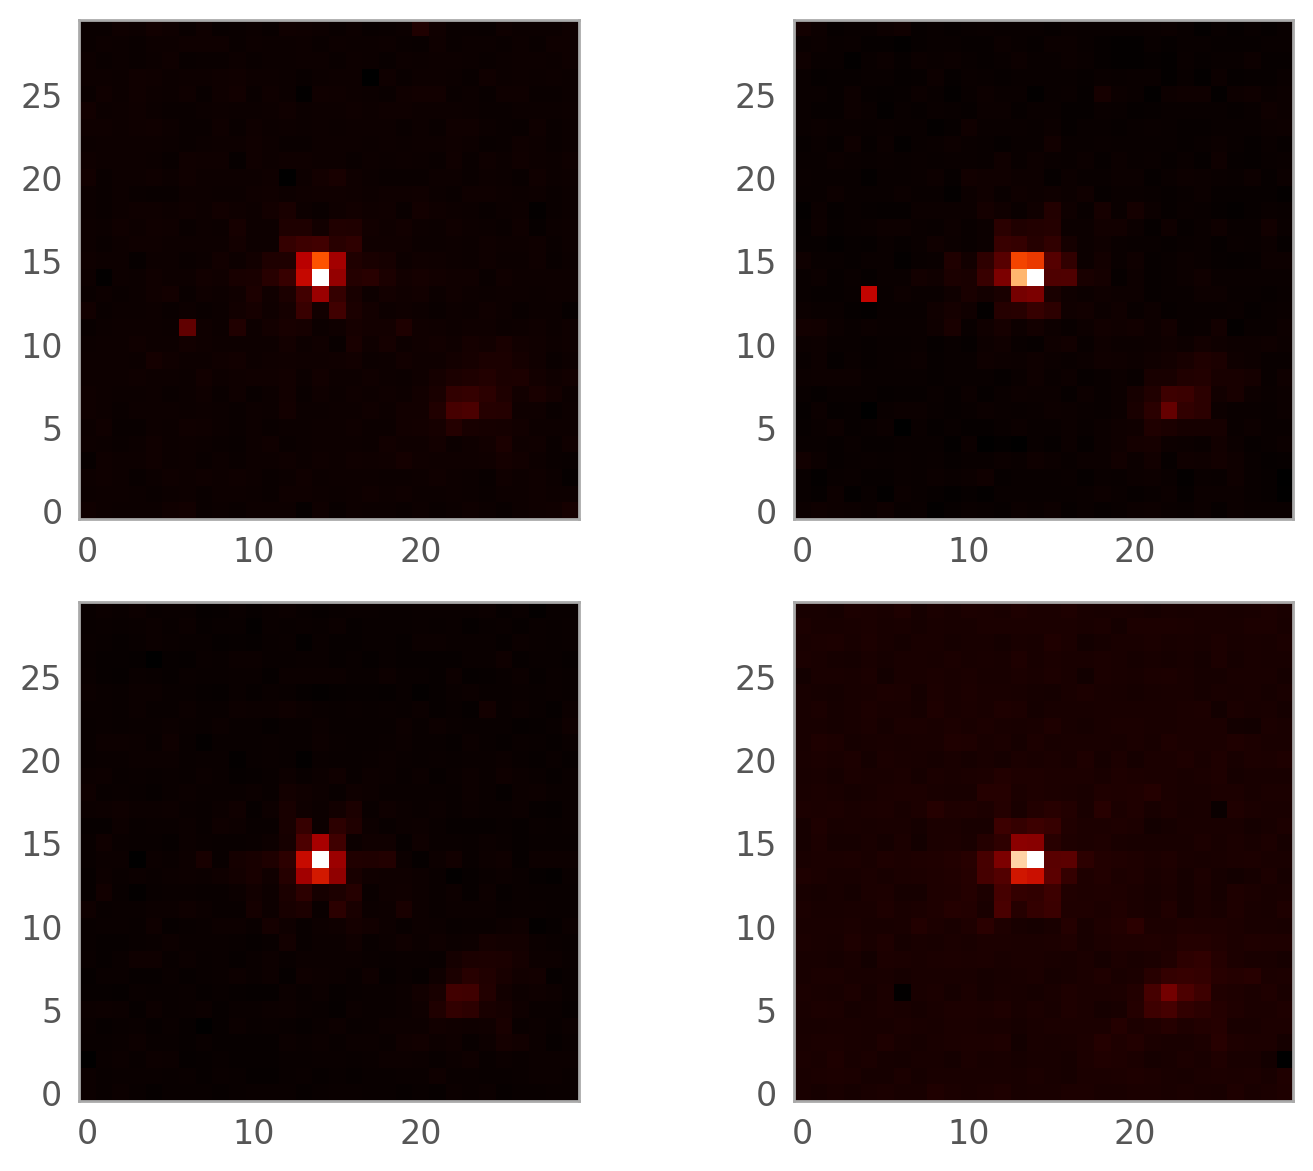

In [985]:
nx = 60
ny = 60

X, Y = np.meshgrid(np.arange(nx)/nx, np.arange(ny)/ny)

with fits.open(cutout_paths[0]) as hdul: 
    orig = hdul[1].data

test_atlas_2x = []
for i in range(2): 
    for j in range(2): 
        test_slice = orig[i:60+i:2, j:60+j:2]
        print(i, j)
        # test_slice = orig[i:60+i, j:60+j].reshape(20, 3, 20, 3).mean(axis=(1, 3))
        test_atlas_2x.append(test_slice)

fig, axs = plt.subplots(2, 2)
axs = axs.flat
for i in range(4): 
    data = test_atlas_2x[i]
    # print(data.shape)
    axs[i].imshow(np.arcsinh(data))
    axs[i].grid(False)

plt.tight_layout()

translating fft.F

In [3578]:
import numpy as np

def four1(data, nn, isign):
    print('four1', data.size, nn)
    n = 2*nn
    # data = np.asarray(data, dtype=np.float64)
    data = np.concatenate((data, np.zeros(10)))
    j = 1
    for i in range(1, n+1, 2):
        if j > i:
            data[j-1], data[i-1] = data[i-1], data[j-1]
            data[j+1-1], data[i+1-1] = data[i+1-1], data[j+1-1]
        
        m = n//2
        while m>=2 and j>m:
            j -= m
            m //= 2
        j += m
    
    # FFT computation
    mmax = 2
    while n>mmax:
        istep = 2*mmax
        theta = 2*np.pi/(isign*mmax)
        wpr = -2.0*np.sin(0.5*theta)**2
        wpi = np.sin(theta)
        wr = 1.0
        wi = 0.0
        for m in range(1, mmax+1, 2):
            for i in range(m, n+1, istep):
                j = i + mmax
                print(i, j, mmax, nn, n, istep, len(data))
                tempr = wr*data[j-1] - wi*data[j]
                tempi = wr*data[j] + wi*data[j-1]
                data[j-1]  = data[i-1] - tempr
                data[j] = data[i] - tempi
                data[i-1] += tempr
                data[i] += tempi
            wtemp = wr
            wr = wr*wpr - wi*wpi + wr
            wi = wi*wpr + wtemp*wpi + wi
        
        mmax = istep
    return data[:-10]

def realft(data, n, isign):
    print('realft', data.size, n)
    theta = 2*np.pi/(2*n)
    data = np.asarray(data, dtype=np.float64)
    wr = 1.0
    wi = 0.0
    c1 = 0.5
    if isign == 1:
        c2 = -0.5
        # print(data, n)
        data = four1(data, n, 1)
        # print(data)
        data[2*n] = data[0]
        data[2*n+1] = data[1]
    else:
        c2 = 0.5
        theta = -theta
    wpr = -2.0*np.sin(0.5*theta)**2
    wpi = np.sin(theta)
    n2p3 = 2*n + 3
    for i in range(1, n//2+2):
        i1 = 2*i - 1
        i2 = i1 + 1
        i3 = n2p3 - i2
        i4 = i3 + 1
        wrs = wr
        wis = wi
        h1r = c1*(data[i1-1] + data[i3-1])
        h1i = c1*(data[i2-1] - data[i4-1])
        h2r = -c2*(data[i2-1] + data[i4-1])
        h2i = c2*(data[i1-1] - data[i3-1])
        data[i1-1] = h1r + wrs*h2r - wis*h2i
        data[i2-1] = h1i + wrs*h2i + wis*h2r
        data[i3-1] = h1r - wrs*h2r + wis*h2i
        data[i4-1] = -h1i + wrs*h2i + wis*h2r
        wtemp = wr
        wr = wr*wpr - wi*wpi + wr
        wi = wi*wpr + wtemp*wpi + wi
    if isign == -1:
        data = four1(data, n, -1)
    return data

def real2dfft(a, nra, nca, b, nrb, ncb, isign, work, onedim=False):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    work = np.zeros((2, max(nra, nrb)))
    if isign >= 0:
        a[:ncb, :nrb] = b
        # a[ncb:, :] = 0
        nhc = (nca - 2)//2
        # print(nhc)
        for ir in range(nrb):
            a[:, ir] = realft(a[:, ir], nhc, isign)
        # print(a)
        # print(a[0, :].size, nhc)
        # a[0, :] = realft(a[0, :], nhc, isign)
        if onedim:
            return a
        for ic in range(1, nca+1, 2):
            # print('ic', ic, a[ic+1-1, :nrb])
            # print(a)
            work[0, :nrb] = a[ic-1, :nrb]
            work[1, :nrb] = a[ic+1-1, :nrb]
            # work[:, nrb:] = 0
            # print(work)
            work = four1(work.T.flatten(), nra, isign).reshape(-1, 2).T
            # print(work)
            a[ic-1, :] = work[0, :]
            a[ic+1-1, :] = work[1, :]
    else:
        if not onedim:
            for ic in range(1, ncb+1, 2):
                work[0, :nrb] = b[ic-1, :nrb]
                work[1, :nrb] = b[ic+1-1, :nrb]
                work = four1(work.T.flatten(), nra, isign).reshape(-1, 2).T
                b[ic-1, :] = work[0, :]
                b[ic+1-1, :] = work[1, :]
        nhc = (ncb - 2)//2
        for ir in range(nra):
            b[:, ir] = realft(b[:, ir], nhc, isign)
        if onedim:
            tmp = 1.0/nhc
        else:
            tmp = 1.0/(nrb*nhc)
        a = b*tmp

    return a

# b = orig.copy()

# b = np.array([[2, 3, 4, 5], 
#               [3, 4, 5, 6], 
#               [4, 5, 6, 7], 
#               [5, 6, 7, 8]])

b = np.ones((14, 14))

nrb, ncb = b.shape
a = np.zeros((nrb, ncb))
nra, nca = a.shape
isign = 1
work = np.zeros((2, nrb))

a_hat = real2dfft(a, nra, nca, b, nrb, ncb, isign, work, onedim=False)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
a_hat

realft 14 6
four1 14 6
1 3 2 6 12 4 24
5 7 2 6 12 4 24
9 11 2 6 12 4 24
1 5 4 6 12 8 24
9 13 4 6 12 8 24
3 7 4 6 12 8 24
11 15 4 6 12 8 24
1 9 8 6 12 16 24
3 11 8 6 12 16 24
5 13 8 6 12 16 24
7 15 8 6 12 16 24
realft 14 6
four1 14 6
1 3 2 6 12 4 24
5 7 2 6 12 4 24
9 11 2 6 12 4 24
1 5 4 6 12 8 24
9 13 4 6 12 8 24
3 7 4 6 12 8 24
11 15 4 6 12 8 24
1 9 8 6 12 16 24
3 11 8 6 12 16 24
5 13 8 6 12 16 24
7 15 8 6 12 16 24
realft 14 6
four1 14 6
1 3 2 6 12 4 24
5 7 2 6 12 4 24
9 11 2 6 12 4 24
1 5 4 6 12 8 24
9 13 4 6 12 8 24
3 7 4 6 12 8 24
11 15 4 6 12 8 24
1 9 8 6 12 16 24
3 11 8 6 12 16 24
5 13 8 6 12 16 24
7 15 8 6 12 16 24
realft 14 6
four1 14 6
1 3 2 6 12 4 24
5 7 2 6 12 4 24
9 11 2 6 12 4 24
1 5 4 6 12 8 24
9 13 4 6 12 8 24
3 7 4 6 12 8 24
11 15 4 6 12 8 24
1 9 8 6 12 16 24
3 11 8 6 12 16 24
5 13 8 6 12 16 24
7 15 8 6 12 16 24
realft 14 6
four1 14 6
1 3 2 6 12 4 24
5 7 2 6 12 4 24
9 11 2 6 12 4 24
1 5 4 6 12 8 24
9 13 4 6 12 8 24
3 7 4 6 12 8 24
11 15 4 6 12 8 24
1 9 8 6 12 16 24
3 11

array([[126.   ,   4.542, -15.698,   7.68 , -28.   , -22.834,  71.698,
        -41.126, -14.   ,  15.257,  43.698,  12.119,  28.   ,   3.035],
       [ 70.   ,   3.035, -46.101,  41.126,  28.   ,   4.542,   9.899,
        -12.119,  14.   , -22.834, -65.899, -21.327,   0.   ,  15.257],
       [  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ],
       [  3.536,  -0.562,  -1.922,  -0.95 ,   0.732,   2.825,  -8.87 ,
          5.088,   4.464,  -1.888,  -1.543,  -1.499,  -0.732,  -0.375],
       [ 10.464,  -0.375,   5.703,  -5.088,  -0.732,  -0.562,   2.639,
          1.499,   1.   ,   2.825,   8.153,   2.638,  -2.732,  -1.888],
       [  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ],

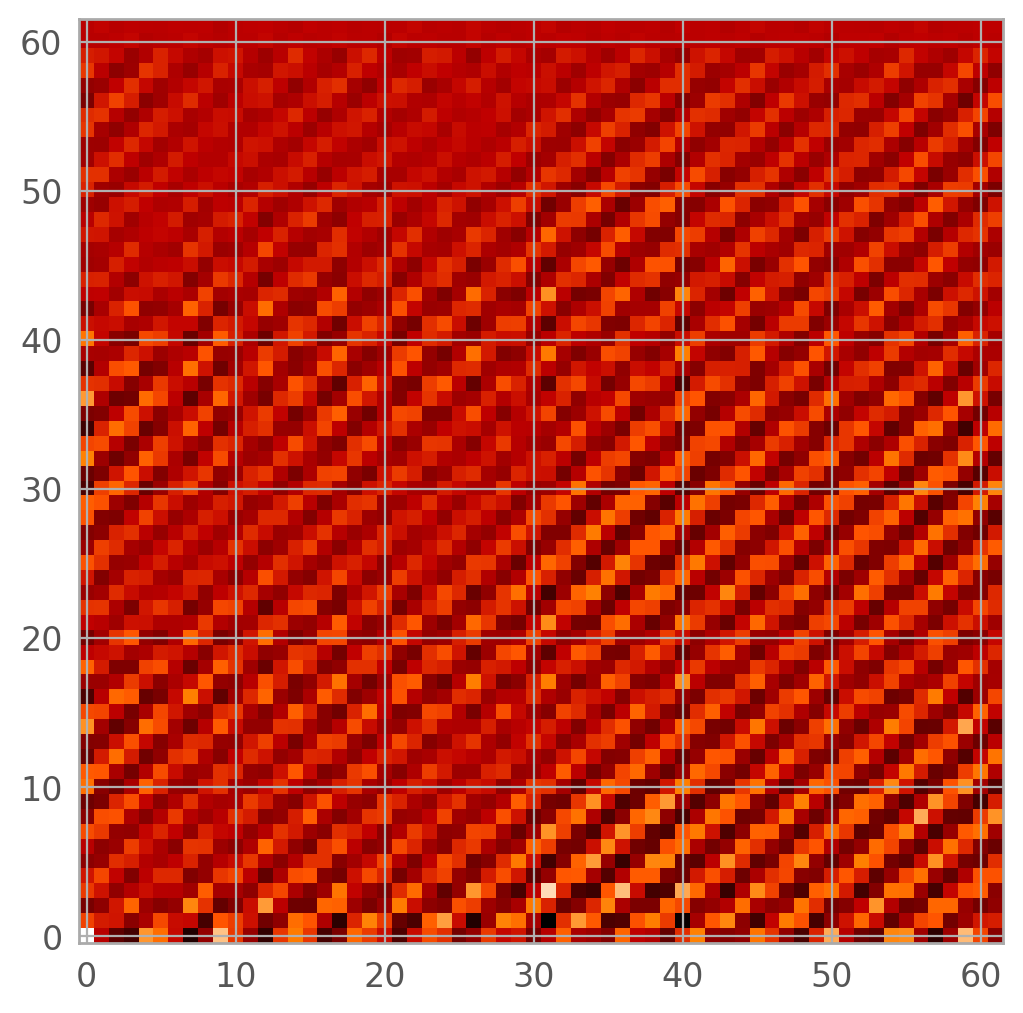

In [2845]:
plt.imshow(a_hat)

In [ ]:
            b[1, ir-1] = realft(b[1, ir-1], nhc, isign)
        if onedim:
            tmp = 1.0/nhc
        else:
            tmp = 1.0/(nrb*nhc)
        a = b*tmp

    return a

b = orig.copy()
nrb, ncb = b.shape
a = np.zeros((nrb, ncb))
nra, nca = a.shape
isign = 1
work = np.zeros((2, nrb))

a_hat = real2dfft(a, nra, nca, b, nrb, ncb, isign, work, onedim=False)


In [3262]:
x1 = 0
y1 = 0

x2 = -2/3
y2 = 0

x3 = 0
y3 = -4/3

x4 = -4/3
y4 = -4/3

# enlarged scale

coeffs4 = []
for i in [1, -1]:
    for j in [1, -1]:
        F = np.array([[1, np.exp(-np.pi*1j*i*x1), np.exp(-np.pi*1j*j*y1), np.exp(-np.pi*1j*(i*x1+j*y1))], 
                      [1, np.exp(-np.pi*1j*i*x2), np.exp(-np.pi*1j*j*y2), np.exp(-np.pi*1j*(i*x2+j*y2))],
                      [1, np.exp(-np.pi*1j*i*x3), np.exp(-np.pi*1j*j*y3), np.exp(-np.pi*1j*(i*x3+j*y3))],
                      [1, np.exp(-np.pi*1j*i*x4), np.exp(-np.pi*1j*j*y4), np.exp(-np.pi*1j*(i*x4+j*y4))]])
        F /= 4
        F_inv = la.inv(F)
        coeffs = F_inv[:, 0]
        coeffs4.append(coeffs)

coeffs4 = np.array(coeffs4)
coeffs4

array([[1.333-0.j   , 0.667+1.155j, 0.667-1.155j, 1.333+0.j   ],
       [0.667-1.155j, 1.333+0.j   , 1.333-0.j   , 0.667+1.155j],
       [0.667+1.155j, 1.333-0.j   , 1.333+0.j   , 0.667-1.155j],
       [1.333+0.j   , 0.667-1.155j, 0.667+1.155j, 1.333-0.j   ]])

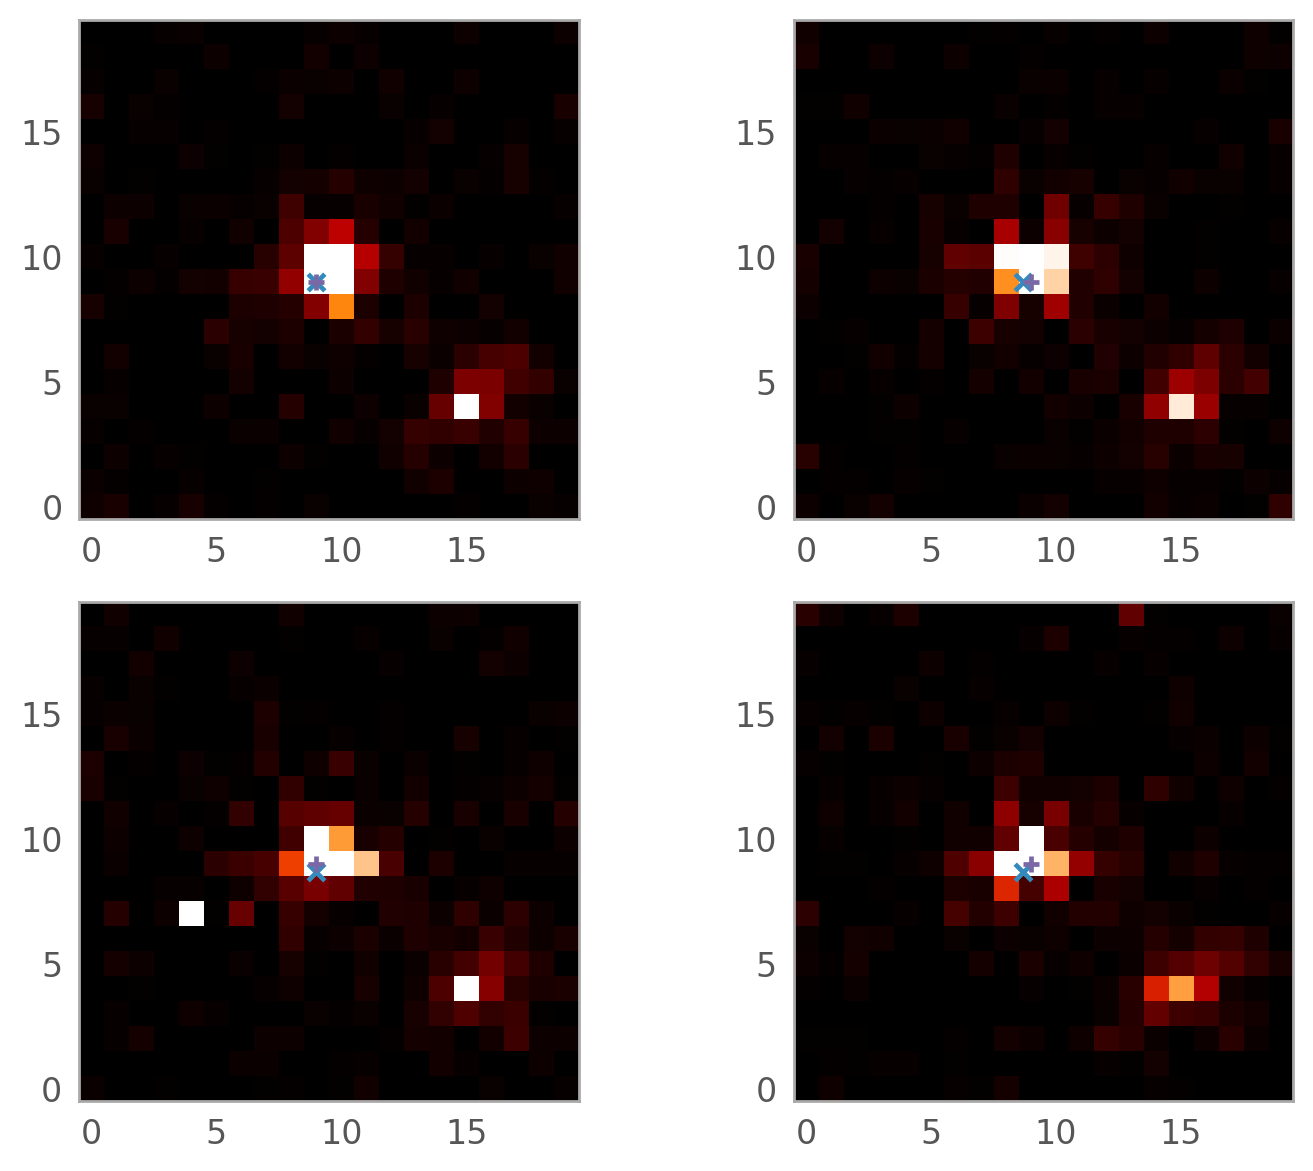

In [767]:
fig, axs = plt.subplots(2, 2)
axs = axs.flat

for i in range(factor**2): 
    data = test_atlas[i]
    qso_center = [9 - centroids[i, 1], 
                  9 - centroids[i, 0]]
    img_center = [9, 9]
    axs[i].imshow(data, vmin=0, vmax=1)
    axs[i].scatter(*qso_center, marker='x')
    axs[i].scatter(*img_center, marker='+')
    # axs[i].set_xlim(30, 35)
    # axs[i].set_ylim(30, 35)
    # axs[i].set_xlim(int(nx/5*2), int(nx/5*3))
    # axs[i].set_ylim(int(ny/5*2), int(ny/5*3))
    axs[i].grid(False)

plt.tight_layout()
plt.show()

In [2406]:
a = [[2, 3, 4, 5], 
     [3, 4, 5, 6], 
     [4, 5, 6, 7], 
     [5, 6, 7, 8]]

fft.fft2(a)

array([[80.+0.j, -8.+8.j, -8.+0.j, -8.-8.j],
       [-8.+8.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [-8.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [-8.-8.j,  0.+0.j,  0.+0.j,  0.+0.j]])

In [941]:
b = fft.fft(a, axis=1)
# fft.fft(b, axis=0)
b

array([[14.+0.j, -2.+2.j, -2.+0.j, -2.-2.j],
       [18.+0.j, -2.+2.j, -2.+0.j, -2.-2.j],
       [22.+0.j, -2.+2.j, -2.+0.j, -2.-2.j],
       [26.+0.j, -2.+2.j, -2.+0.j, -2.-2.j]])

In [2443]:
a = np.random.rand(4, 4)

fft.fft(fft.fft(a, axis=1).real, axis=0).real

array([[ 6.7  , -0.279,  0.973, -0.279],
       [ 0.835,  0.84 , -0.493,  0.84 ],
       [ 1.052,  0.477,  1.743,  0.477],
       [ 0.835,  0.84 , -0.493,  0.84 ]])

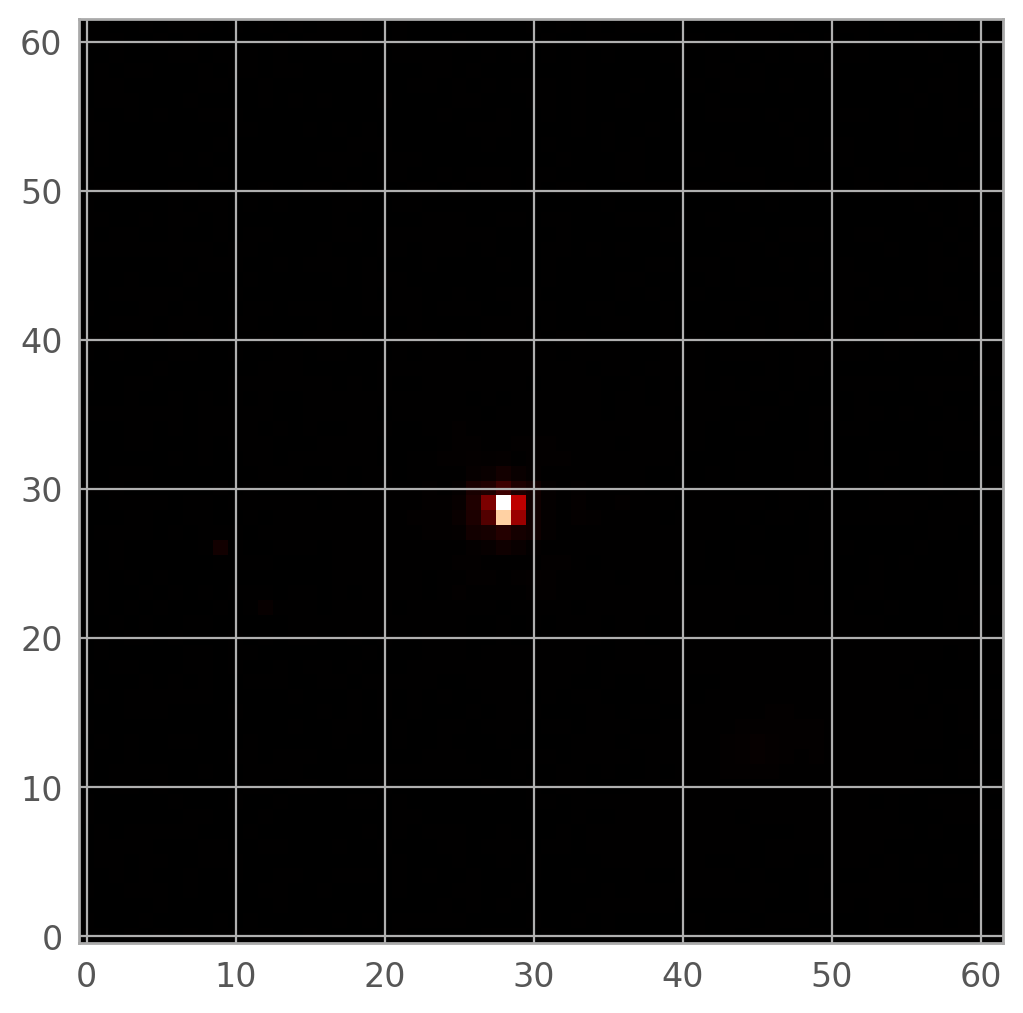

In [3150]:
plt.imshow(orig)

In [3152]:
orig.shape

(62, 62)

In [3151]:
import numpy as np
import sys

# Create a 3x3 NumPy array
array = orig

# Print the array to the console in the same format as np.savetxt
np.savetxt(sys.stdout, array, fmt='%.6f', delimiter=' ')


0.041774 0.031836 -0.000145 0.066031 -0.015886 0.047934 -0.013774 0.023715 -0.006990 0.016399 0.051063 0.072426 0.058633 -0.007550 -0.034754 0.013162 -0.022715 -0.068522 -0.030911 -0.015840 0.001757 0.013915 0.004696 -0.003158 0.005681 -0.013922 -0.095435 0.027218 0.029236 0.017382 -0.048791 0.053445 0.002444 -0.016097 -0.008220 0.019546 -0.014918 -0.013539 -0.030082 0.006062 0.002953 0.040505 -0.040807 0.047494 -0.004585 0.012678 0.022990 0.006460 -0.004030 0.028018 -0.051324 -0.023389 -0.001296 0.025678 0.025728 0.010967 0.046702 0.020717 0.122973 0.017906 0.024810 0.013279
0.029671 0.000572 -0.015101 -0.039232 0.040014 -0.007563 -0.001228 -0.031167 -0.056637 0.007942 -0.012872 0.018669 -0.019299 -0.014229 -0.016479 -0.018202 -0.027143 0.072921 -0.003259 0.018869 0.001481 0.008799 0.008194 0.016468 0.015396 0.056816 -0.020913 -0.023022 -0.001619 0.006595 0.008907 0.001822 0.004425 0.043234 -0.004029 0.031792 -0.009654 -0.004379 -0.038189 -0.000162 -0.008931 0.029298 -0.036819 0.02340